# 1 赛题分析

# 2 数据探索

## 理解数据背景与目标

#### **概述**

共享单车系统是一种租赁自行车的方式，通过城市各处的自动化站点网络，实现会员注册、租赁和还车的自动化过程。使用这些系统，人们可以在一个地点租车，并在需要时将其归还到不同的地点。目前，全球有超过500个共享单车项目。
http://archive.ics.uci.edu/dataset/275/bike+sharing+dataset


https://www.selectdataset.com/data_all_allset/7634a227fafb8431d343eaf30a49e802

#### **数据字段**

* datetime - 小时日期 + 时间戳
* season - 1 = 春季, 2 = 夏季, 3 = 秋季, 4 = 冬季
* holiday - 是否为假日
* workingday - 是否为工作日（非周末或假日）
* weather - 天气情况：
    * 1: 晴天、少云、局部多云
    * 2: 薄雾 + 多云、薄雾 + 碎云、薄雾 + 少云、薄雾
    * 3: 小雪、小雨 + 雷暴 + 散云、小雨 + 散云
    * 4: 大雨 + 冰雹 + 雷暴 + 薄雾、雪 + 雾
* temp - 温度（摄氏度）
* atemp - "体感"温度（摄氏度）
* humidity - 相对湿度
* windspeed - 风速
* casual - 非注册用户租赁数量
* registered - 注册用户租赁数量
* count - 租赁总数量（因变量）

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## 数据初步观察与概览

**加载数据集**

In [2]:
train_data = pd.read_csv("./data/train.csv")
submit_data = pd.read_csv("./data/test.csv")

**查看数据集维度**

In [3]:
train_data.shape

(10886, 12)

**查看数据集前几行**

In [4]:
train_data.head(2)

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40

**查看各个特征的数据类型**

In [5]:
# 使用info()查看信息
print(train_data.info())
print(submit_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6

## 时间特征处理和分类特征转换

In [6]:
import pandas as pd
from dateutil import parser

def process_time_features(data, time_col_name):
    """
    处理各种格式的时间特征列，提取年、月、日、小时、分钟、星期几，以及其他时间特征。

    Args:
        data: Pandas DataFrame，包含时间特征的原始数据。
        time_col_name: str，时间特征在 DataFrame 中的列名。

    Returns:
        Pandas DataFrame，包含原始数据和新增的时间特征列。
    """

    # 定义新生成的时间特征列名
    date_col = "date" # 日期列名
    year_col = "year" # 年
    month_col = "month" # 月
    day_col = "day" # 日
    hour_col = "hour" # 小时
    minute_col = "minute" # 分钟
    weekday_col = "weekday" # 星期几，0 代表星期一 
    #day_of_year_col = "dayofyear" # 一年中第几天
    quarter_col = "quarter" # 季度
    is_weekend_col = "is_weekend" # 是否为周末（1 表示是，0 表示否）
    #is_month_start_col = "is_month_start" # 否为月初
    #is_month_end_col = "is_month_end" # 否为月末
    


    # 使用 dateutil.parser 解析各种格式的时间字符串
    datetime_series = data[time_col_name].apply(lambda x: parser.parse(str(x)))

    # 创建一个新的 DataFrame 以避免修改原始数据
    processed_data = data.copy()

    # 提取时间特征
    processed_data[date_col] = pd.to_datetime(datetime_series.apply(lambda x: x.date()))
    processed_data[year_col] = datetime_series.apply(lambda x: x.year).astype('int')
    processed_data[month_col] = datetime_series.apply(lambda x: x.month).astype('int')
    processed_data[day_col] = datetime_series.apply(lambda x: x.day).astype('int')
    processed_data[hour_col] = datetime_series.apply(lambda x: x.hour).astype('int')
    processed_data[minute_col] = datetime_series.apply(lambda x: x.minute).astype('int')
    processed_data[weekday_col] = datetime_series.apply(lambda x: x.weekday()).astype('int')
    #processed_data[day_of_year_col] = datetime_series.apply(lambda x: x.timetuple().tm_yday).astype('int')
    processed_data[quarter_col] = datetime_series.apply(lambda x: x.quarter).astype('int')
    processed_data[is_weekend_col] = datetime_series.apply(lambda x: 1 if x.weekday() >= 5 else 0).astype('int')
    #processed_data[is_month_start_col] = datetime_series.apply(lambda x: int(x.is_month_start)).astype('int')
    #processed_data[is_month_end_col] = datetime_series.apply(lambda x: int(x.is_month_end)).astype('int')


    return processed_data

# 同时处理训练集和提交集的时间特征
train_data = process_time_features(train_data,"datetime")
submit_data = process_time_features(submit_data,"datetime")


## 时间特征可视化

 - 很明显，人们倾向于在夏季租用自行车，因为那个季节骑自行车的条件真的很好。因此，六月、七月和八月的自行车需求相对较高。
 - 在工作日，更多人倾向于在上午7-8点和下午5-6点租用自行车。如前所述，这可以归因于常规的上学和上班通勤者。
 - 在"周六"和"周日"没有观察到上述模式。更多人倾向于在上午10点到下午4点之间租用自行车。


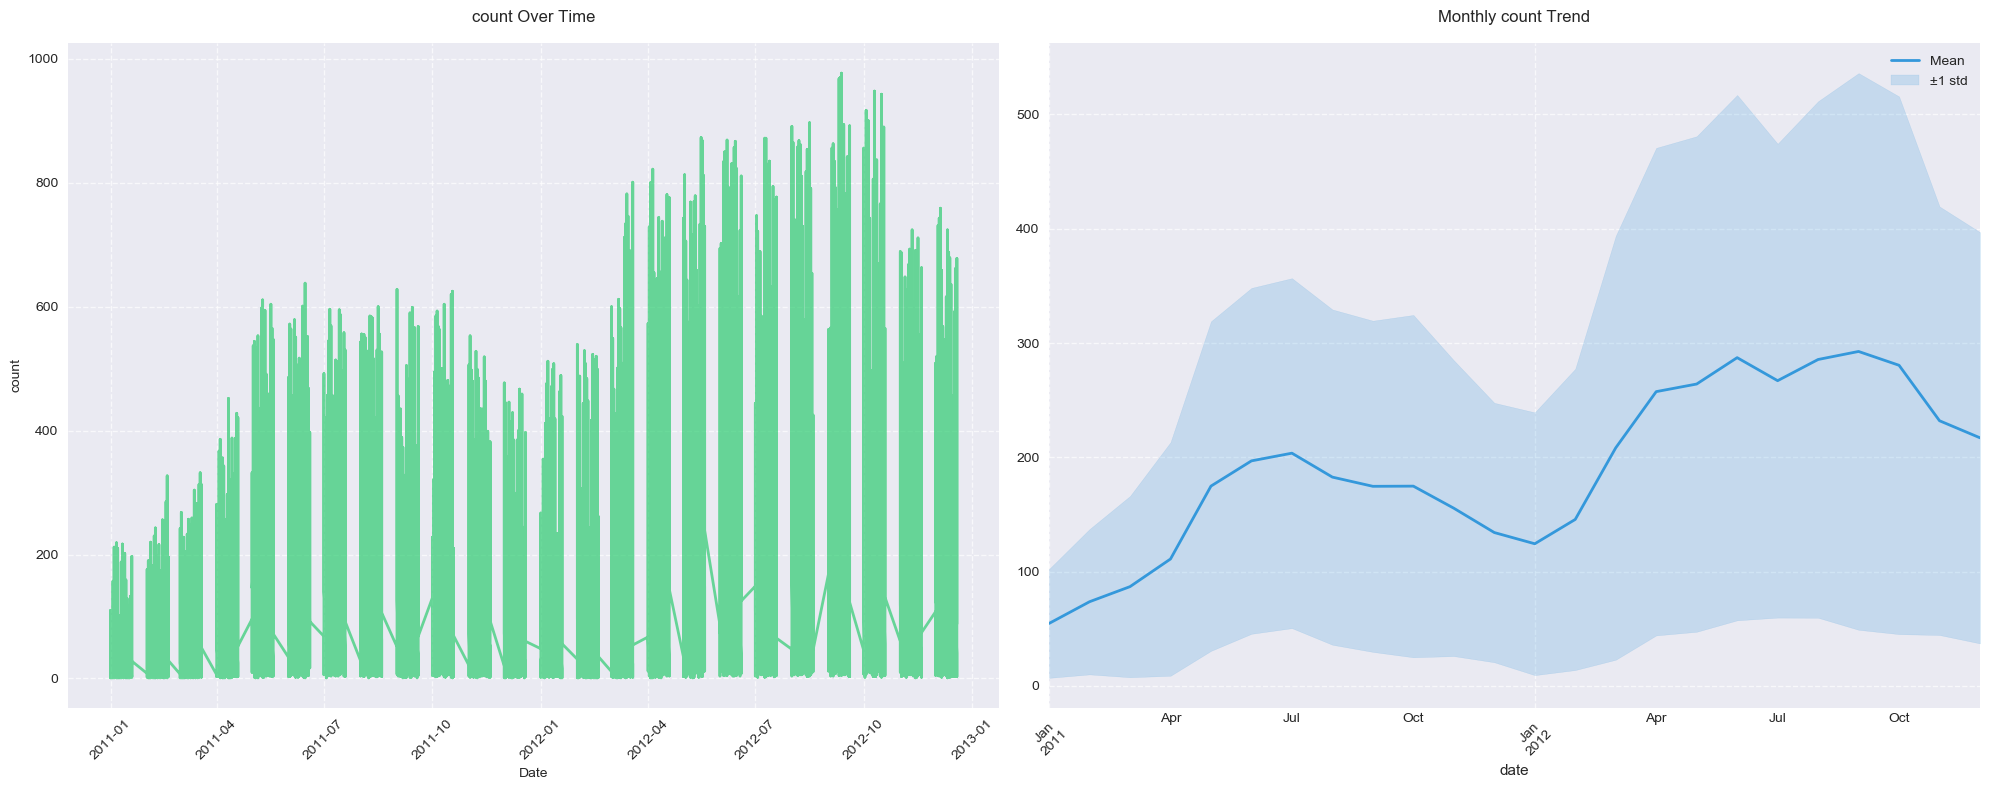

In [7]:
def analyze_basic_time_series(data, target='count', n_cols=2, figsize=(20, 8)):
    """
    基础时间序列分析：展示目标变量随时间的整体趋势
    
    参数:
    - data: DataFrame, 输入数据
    - target: str, 目标变量名称
    - n_cols: int, 图表列数
    - figsize: tuple, 图形大小
    """
    plt.style.use('seaborn')
    
    if n_cols == 1:
        # 单图布局
        fig, ax = plt.subplots(figsize=figsize)
        
        # 1.1 原始时间序列
        ax.plot(data['date'], data[target], color='#2ecc71', alpha=0.7, linewidth=2, label='Original')
        
        # 1.2 月度趋势（带标准差区间）
        df_temp = data.copy()
        df_temp.set_index('date', inplace=True)
        resampled = df_temp[target].resample('M')
        mean_values = resampled.mean()
        std_values = resampled.std()
        
        mean_values.plot(ax=ax, color='#3498db', label='Monthly Mean', linewidth=2)
        ax.fill_between(
            mean_values.index,
            mean_values - std_values,
            mean_values + std_values,
            color='#3498db',
            alpha=0.2,
            label='±1 std'
        )
        
        # 设置图表样式
        ax.set_title(f'{target} Over Time with Monthly Trend', fontsize=12, pad=15)
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel(target, fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize=10)
        
    else:
        # 双图布局
        fig, axes = plt.subplots(1, n_cols, figsize=figsize)
        
        # 1.1 原始时间序列
        axes[0].plot(data['date'], data[target], color='#2ecc71', alpha=0.7, linewidth=2)
        axes[0].set_title(f'{target} Over Time', fontsize=12, pad=15)
        axes[0].set_xlabel('Date', fontsize=10)
        axes[0].set_ylabel(target, fontsize=10)
        axes[0].grid(True, linestyle='--', alpha=0.7)
        axes[0].tick_params(axis='x', rotation=45)
        
        # 1.2 月度趋势（带标准差区间）
        df_temp = data.copy()
        df_temp.set_index('date', inplace=True)
        resampled = df_temp[target].resample('M')
        mean_values = resampled.mean()
        std_values = resampled.std()
        
        mean_values.plot(ax=axes[1], color='#3498db', label='Mean', linewidth=2)
        axes[1].fill_between(
            mean_values.index,
            mean_values - std_values,
            mean_values + std_values,
            color='#3498db',
            alpha=0.2,
            label='±1 std'
        )
        axes[1].set_title(f'Monthly {target} Trend', fontsize=12, pad=15)
        axes[1].legend(fontsize=10)
        axes[1].grid(True, linestyle='--', alpha=0.7)
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()



analyze_basic_time_series(train_data, target='count', n_cols=2, figsize=(20, 8))

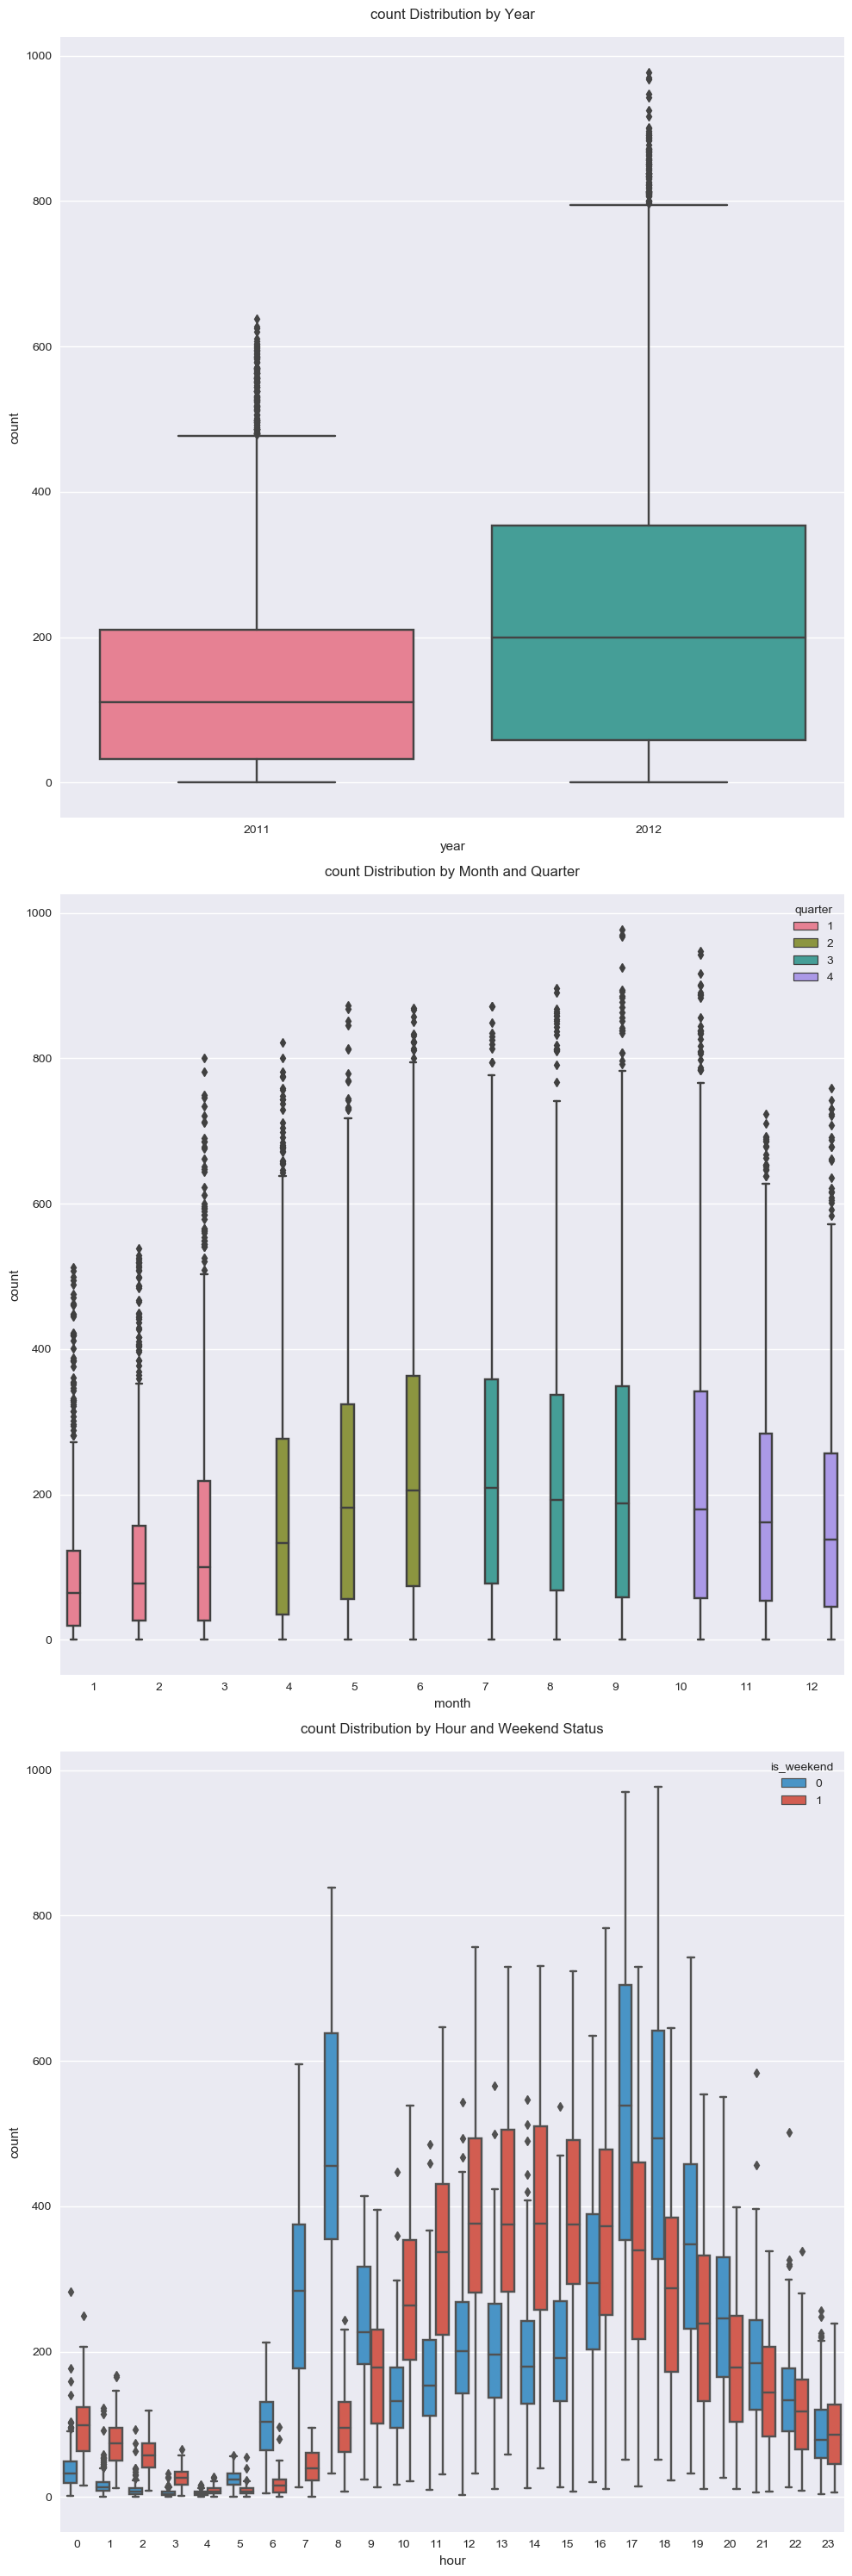

In [8]:
def analyze_time_distributions(data, target='count', n_cols=1, figsize=(20, 15)):
    """
    时间分布分析：展示目标变量在不同时间维度上的分布
    
    参数:
    - data: DataFrame, 输入数据
    - target: str, 目标变量名称
    - n_cols: int, 图表列数，默认为2
    - figsize: tuple, 图形大小
    """
    plt.style.use('seaborn')
    
    # 计算所需的行数
    n_plots = 3  # 总共需要4个图表
    n_rows = (n_plots + n_cols - 1) // n_cols  # 向上取整
    
    # 创建子图
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    # 确保axes是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 设置颜色
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f1c40f', '#9b59b6']
    
    # 获取每个图表在网格中的位置
    plot_positions = [(i // n_cols, i % n_cols) for i in range(n_plots)]
    
    # 2.1 年度分布
    row, col = plot_positions[0]
    sns.boxplot(x='year', y=target, data=data, ax=axes[row, col], palette='husl')
    axes[row, col].set_title(f'{target} Distribution by Year', fontsize=12, pad=15)
    axes[row, col].tick_params(labelsize=10)
    
    # 2.2 季度-月份分布
    row, col = plot_positions[1]
    sns.boxplot(x='month', y=target, hue='quarter', data=data, ax=axes[row, col], palette='husl')
    axes[row, col].set_title(f'{target} Distribution by Month and Quarter', fontsize=12, pad=15)
    axes[row, col].tick_params(labelsize=10)
    
    # 2.3 工作日-时间段分布
    row, col = plot_positions[2]
    sns.boxplot(x='hour', y=target, hue='is_weekend', data=data, ax=axes[row, col], palette=['#3498db', '#e74c3c'])
    axes[row, col].set_title(f'{target} Distribution by Hour and Weekend Status', fontsize=12, pad=15)
    axes[row, col].tick_params(labelsize=10)
    
    
    # 隐藏多余的子图
    for i in range(n_plots, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

analyze_time_distributions(train_data, target='count', n_cols=1, figsize=(10, 30))


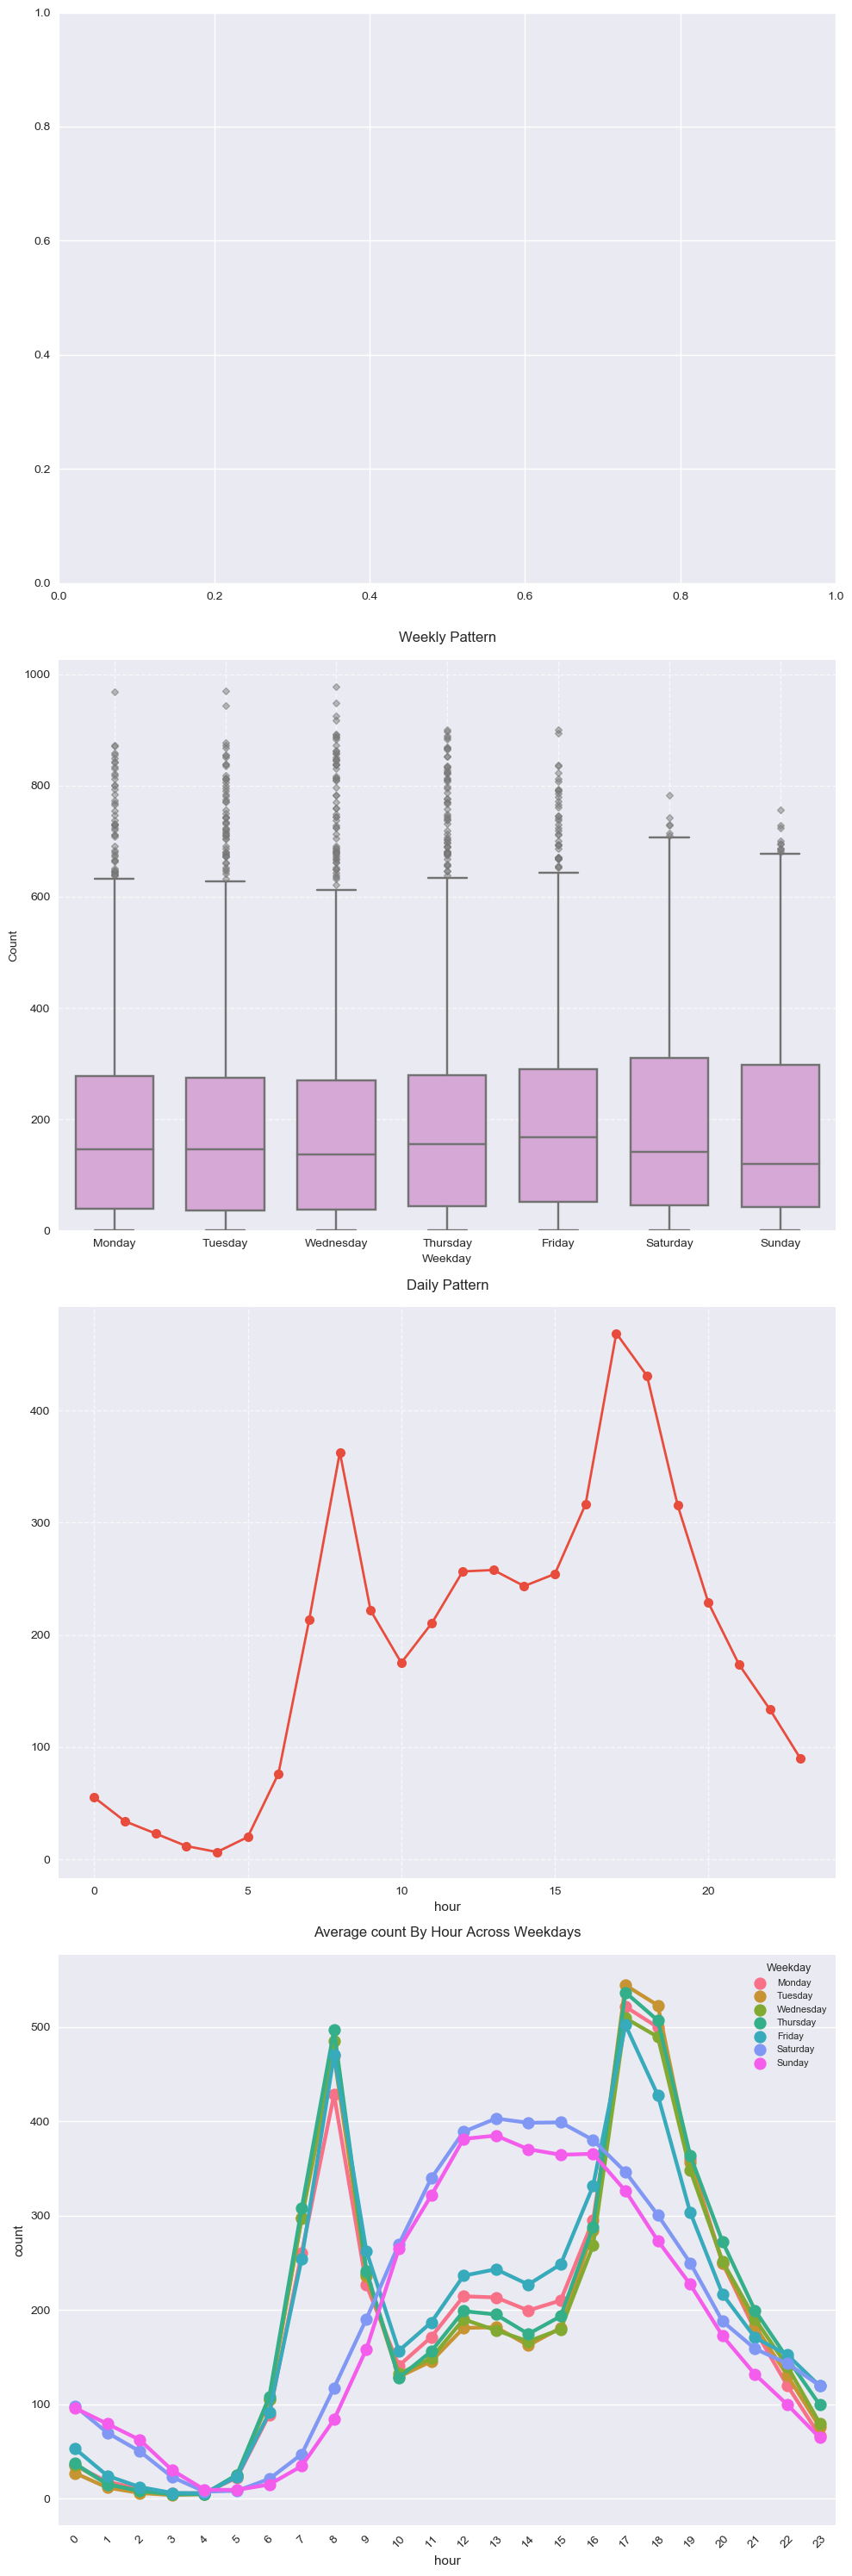

In [9]:
def analyze_cyclical_patterns(data, target='count', n_cols=2, figsize=(20, 15)):


    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

    """
    时间周期模式分析：展示目标变量在不同周期上的变化模式
    
    参数:
    - data: DataFrame, 输入数据
    - target: str, 目标变量名称
    - n_cols: int, 图表列数
    - figsize: tuple, 图形大小
    """
    plt.style.use('seaborn')
    feature_maps = {
        'weekday': {
            0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday",
            4:"Friday", 5:"Saturday", 6:"Sunday"
        }
    }
    
    # 计算所需的行数
    n_plots = 4  # 总共需要4个图表
    n_rows = (n_plots + n_cols - 1) // n_cols  # 向上取整
    
    # 创建子图
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    # 确保axes是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 设置颜色
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f1c40f']
    
    # 获取每个图表在网格中的位置
    plot_positions = [(i // n_cols, i % n_cols) for i in range(n_plots)]
    
    # # 3.1 月度模式
    # row, col = plot_positions[0]
    # monthly_pattern = data.groupby('month')[target].mean()
    # monthly_pattern.plot(
    #     kind='line', 
    #     ax=axes[row, col], 
    #     marker='o',
    #     color=colors[0],
    #     linewidth=2,
    #     markersize=8
    # )
    # axes[row, col].set_title('Monthly Pattern', fontsize=12, pad=15)
    # axes[row, col].grid(True, linestyle='--', alpha=0.7)
    # axes[row, col].tick_params(labelsize=10)
    
    # 3.2 每周模式
    row, col = plot_positions[1]

    # 绘制箱型图
    sns.boxplot(
        data=data,
        x='weekday',
        y=target,
        ax=axes[row, col],
        color='plum',  # 设置为紫色
        width=0.7,
        flierprops={   # 异常值点的样式
            'marker': 'D',
            'markerfacecolor': 'gray',
            'markersize': 4,
            'alpha': 0.5
        }
    )

    # 设置x轴标签
    axes[row, col].set_xticks(range(7))
    axes[row, col].set_xticklabels(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        rotation=0  # 不旋转标签
    )

    # 设置图表样式
    axes[row, col].set_title('Weekly Pattern', fontsize=12, pad=15)
    axes[row, col].set_xlabel('Weekday', fontsize=10)
    axes[row, col].set_ylabel('Count', fontsize=10)
    axes[row, col].grid(True, linestyle='--', alpha=0.7)
    axes[row, col].tick_params(labelsize=10)

    # 设置y轴范围，使其从0开始
    axes[row, col].set_ylim(bottom=0)

    # 设置背景样式
    # axes[row, col].set_facecolor('#F0F0F0')  # 浅灰色背景


    
    # 3.3 每日模式
    row, col = plot_positions[2]
    daily_pattern = data.groupby('hour')[target].mean()
    daily_pattern.plot(
        kind='line', 
        ax=axes[row, col], 
        marker='o',
        color=colors[2],
        linewidth=2,
        markersize=8
    )
    axes[row, col].set_title('Daily Pattern', fontsize=12, pad=15)
    axes[row, col].grid(True, linestyle='--', alpha=0.7)
    axes[row, col].tick_params(labelsize=10)
    
    # 3.4 工作日-小时模式
    row, col = plot_positions[3]
    hour_weekday_agg = pd.DataFrame(
        data.groupby(["hour","weekday"], sort=True)[target].mean()
    ).reset_index()
    hour_weekday_agg['weekday'] = hour_weekday_agg['weekday'].map(feature_maps['weekday'])
    
    sns.pointplot(
        data=hour_weekday_agg, 
        x="hour", 
        y=target, 
        hue="weekday", 
        ax=axes[row, col],
        palette='husl'
    )
    axes[row, col].set_title(f"Average {target} By Hour Across Weekdays", fontsize=12, pad=15)
    axes[row, col].tick_params(axis='x', rotation=45, labelsize=10)
    
    # 修改图例位置：放在图表内部的右上角
    axes[row, col].legend(
        title='Weekday', 
        loc='upper right',  # 放在右上角
        bbox_to_anchor=(1, 1),  # 微调位置
        fontsize=8,  # 减小字体大小
        title_fontsize=9,  # 减小标题字体大小
        ncol=1  # 可以根据需要调整列数
    )
    
    # 隐藏多余的子图
    for i in range(n_plots, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

analyze_cyclical_patterns(train_data, target='count', n_cols=1, figsize=(10, 30))

## 统计量分析- 单变量分析

### 数值型特征

#### 描述性统计量

In [10]:
train_data.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count          year         month           day          hour  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean     191.574132   2011.501929      6.521495      9.992559     11.541613   
std      181.144454      0.500019      3.444373      5.476608      6.915838   
min        1.000000   2011.000000      1.000000      1.000000      0.000000   
25%       42.000000   2011.000000      4.000000      5.000000      6.000000   
50%      145.000000   2012.000000      7.000000     10.000000     12.000000   
75%      284.000000   2012.000000     10.000000     15.000000     18.000000   
max      977.000000   2012.000000     12.000000     19.000000     23.000000   

        minute       weekday       quarter    is_weekend  
count  10886.0  10886.000000  10886.000000  10886.000000  
mean       0.0      3.013963      2.506614      0.290557  
std        0.0      2.004585      1.116174      0.454040  
min        0.0      0.000000      1.000000      0.000000  
25%        0.0      1.000000      2.000000      0.000000  
50%        0.0      3.000000      3.000000      0.000000  
75%        0.0      5.000000      4.000000      1.000000  
max        0.0      6.000000      4.000000      1.000000

#### 直方图和Q-Q图


从下图可以看出，"count"变量向右偏斜。由于大多数机器学习技术要求因变量呈正态分布，因此最好是正态分布。一个可能的解决方案是在删除异常数据点后对"count"变量进行对数转换。转换后的数据看起来好多了，但仍然不是完全理想的正态分布。


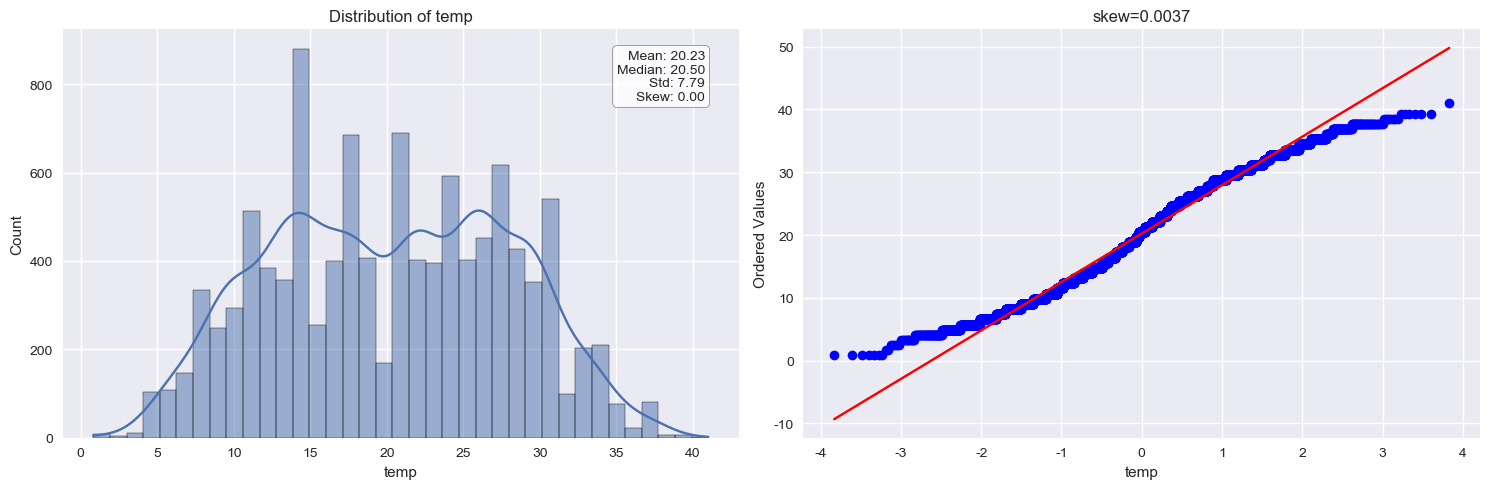

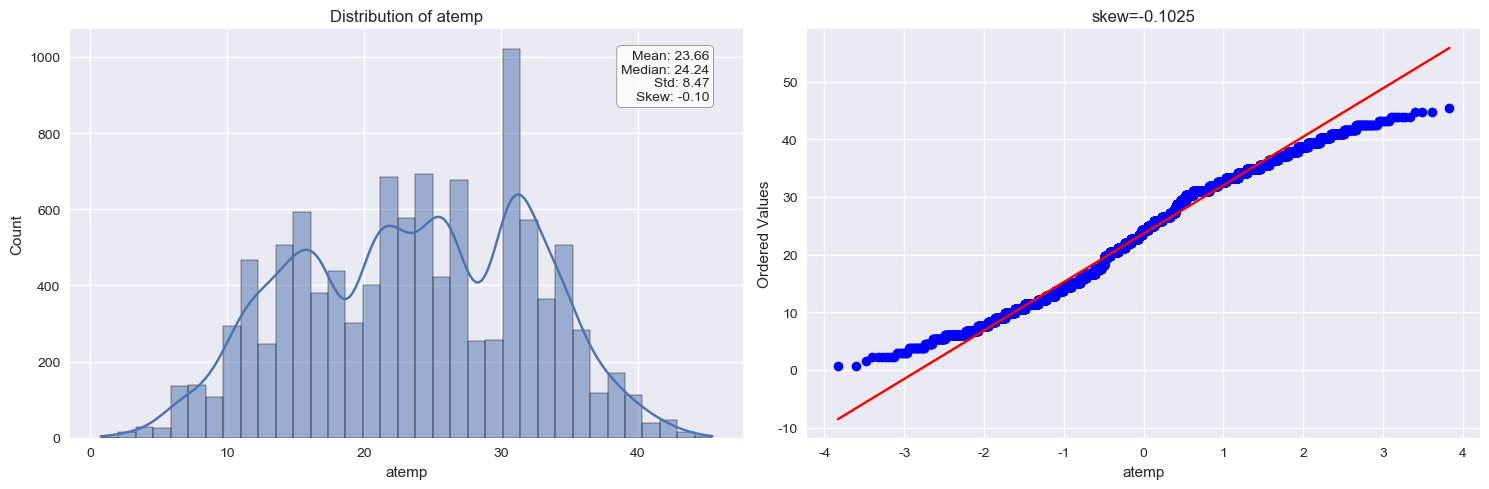

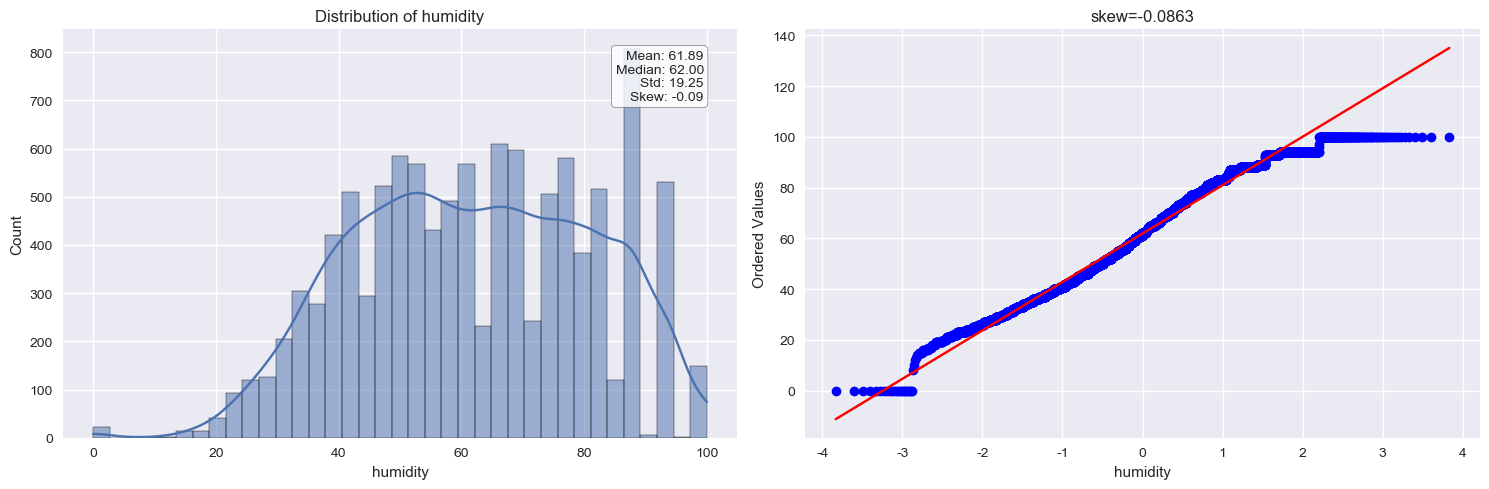

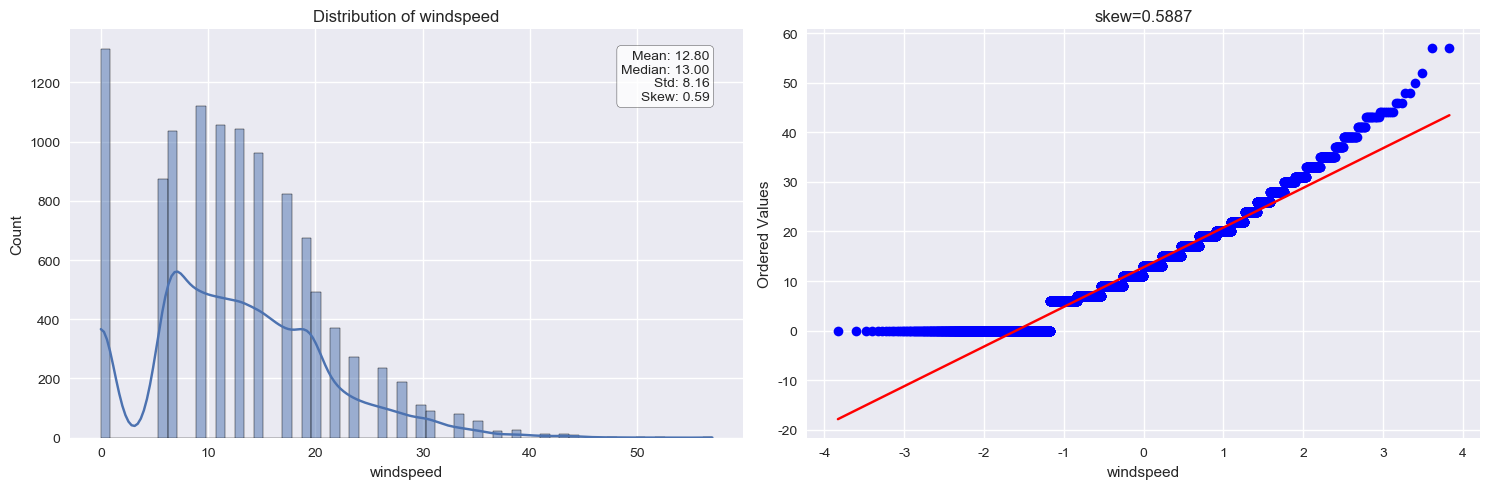

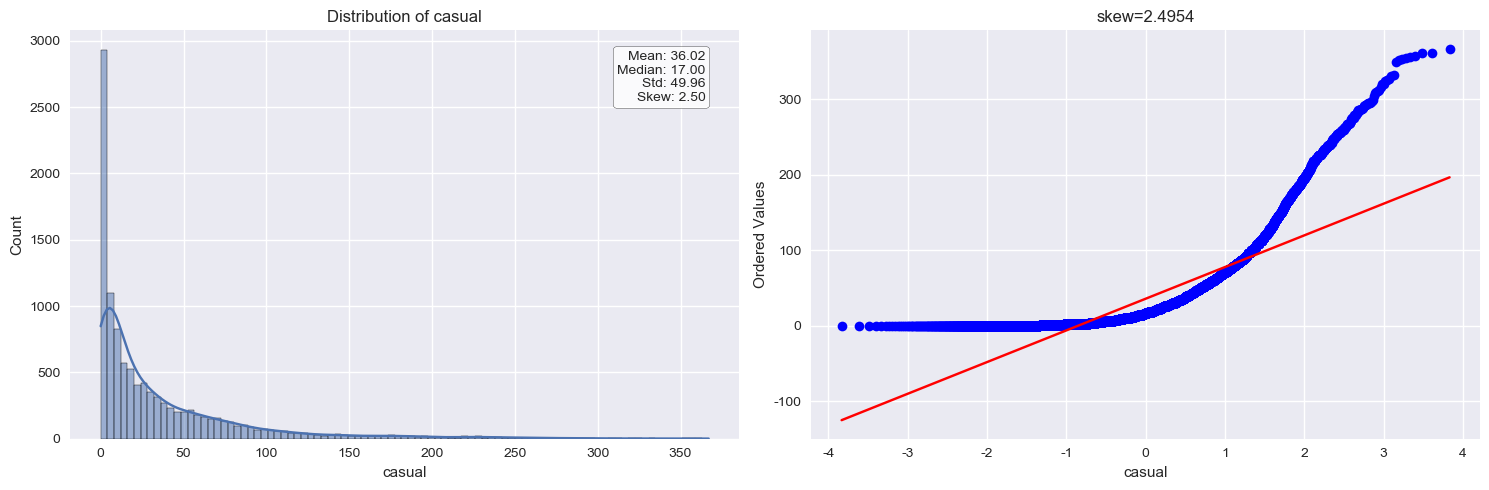

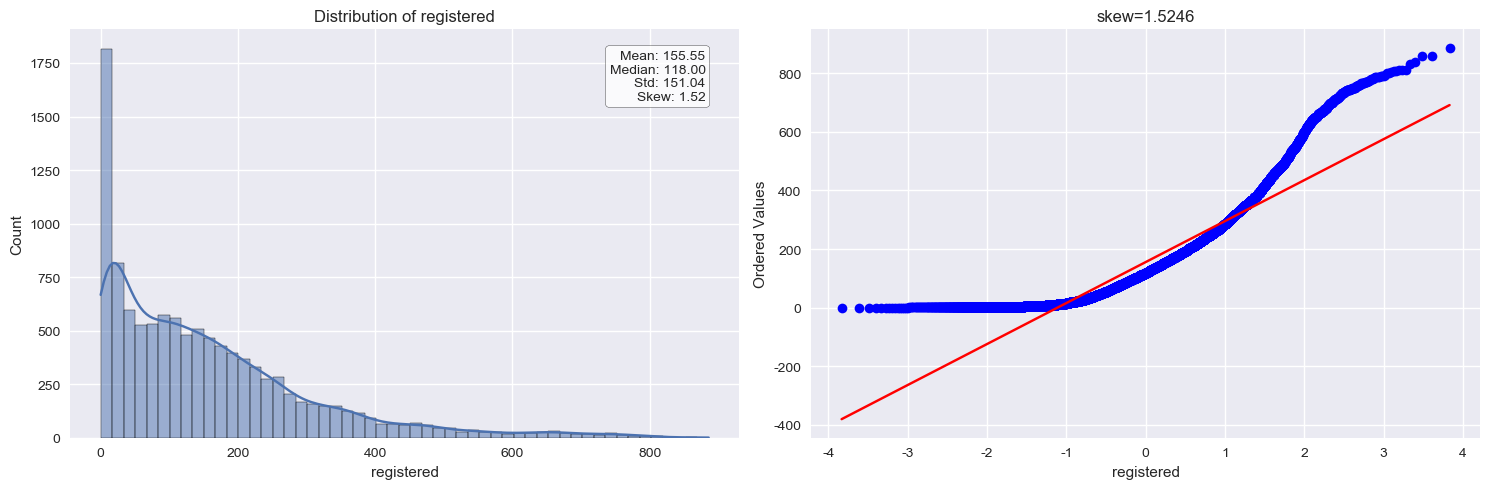

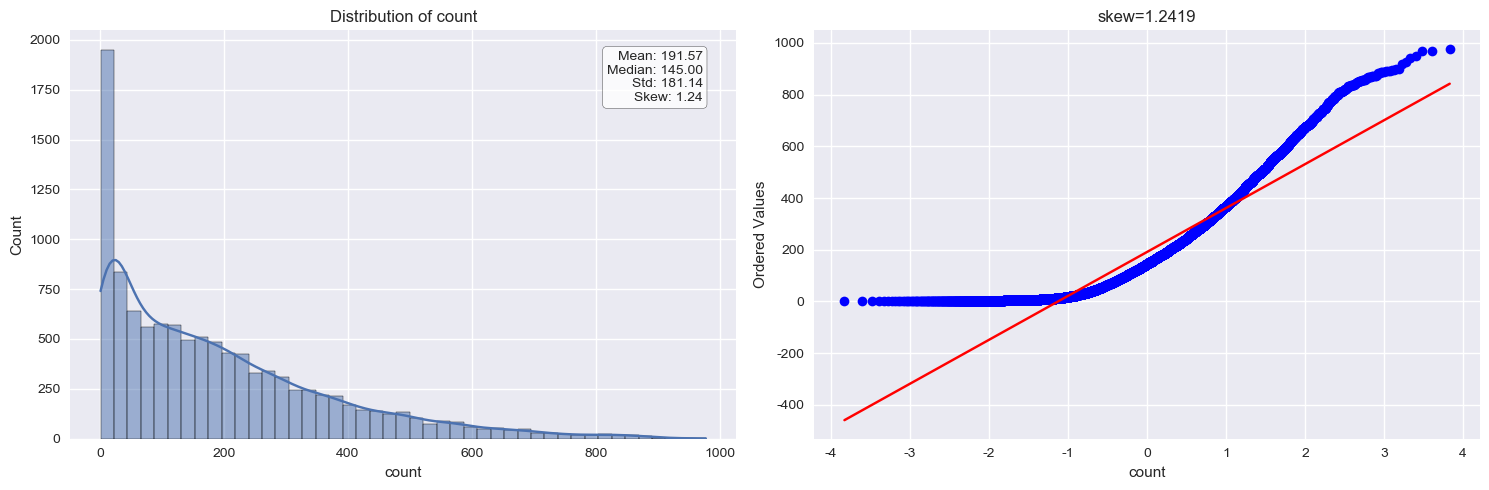

In [11]:
def plot_distributions(data, features=None, figsize=(15, 5)):
    """
    对数据集中的数值型特征进行分布可视化分析
    
    参数:
    - data: DataFrame, 输入数据
    - features: list, 需要分析的特征列表，默认为None（分析所有数值型特征）
    - figsize: tuple, 每个特征的图形大小，默认(15, 5)
    """
    # 如果未指定特征，则选择所有数值型特征
    if features is None:
        features = data.select_dtypes(include=['int64', 'float64']).columns
    
    # 忽略 UserWarning
    import warnings
    warnings.filterwarnings('ignore', 'p-value may not be accurate for N > 5000')
    
    for feature in features:
        # 检查特征是否存在且为数值型
        if feature not in data.columns:
            print(f"警告: 特征 {feature} 不存在于数据集中")
            continue
            
        if not np.issubdtype(data[feature].dtype, np.number):
            print(f"警告: 特征 {feature} 不是数值型变量")
            continue
        
        # 创建子图
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=figsize)
        
        # 1. 直方图 + 核密度估计-了解数据分布形状
        sns.histplot(data=data, x=feature, kde=True, ax=ax1)
        ax1.set_title(f"Distribution of {feature}")
        
        # 添加描述性统计信息
        stats_info = (f"Mean: {data[feature].mean():.2f}\n"
                     f"Median: {data[feature].median():.2f}\n"
                     f"Std: {data[feature].std():.2f}\n"
                     f"Skew: {stats.skew(data[feature]):.2f}")
        
        ax1.text(0.95, 0.95, stats_info,
                transform=ax1.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 2. Q-Q图-检验是否符合正态分布
        stats.probplot(data[feature], dist='norm', fit=True, plot=ax2)
        ax2.set_title(f"skew={stats.skew(data[feature]):.4f}")
        ax2.set_xlabel(feature)
        # 调整布局
        plt.tight_layout()
        plt.show()

# 使用示例:
"""
# 1. 分析所有数值型特征
plot_distributions(train_data)

# 2. 分析指定特征
selected_features = ['temp', 'humidity', 'windspeed', 'count']
plot_distributions(train_data, features=selected_features)

# 3. 自定义图形大小
plot_distributions(train_data, features=['count'], figsize=(12, 4))
"""
selected_features = ['temp' ,'atemp','humidity', 'windspeed', 'casual','registered','count']
plot_distributions(train_data, features=selected_features)

从这两张图可以得到以下重要信息：
1. 从分布图(左图)可以看出：
- 数据分布严重右偏（right-skewed）
- 大部分租赁数量集中在较低值区域（0-200左右）
- 分布呈现长尾特征，有少量高值样本
- 不符合正态分布的形状
2. 从Q-Q图(右图)可以看出：
- 数据点与红色参考线（表示理想的正态分布）有明显偏离
- 在两端的偏离特别明显，说明分布的尾部与正态分布差异较大
- 曲线呈现S形，进一步确认了数据的偏态性

**后序处理：**
- 对数据进行转换使其更接近正态分布
- 考虑使用能处理非正态分布的模型


#### 箱型图

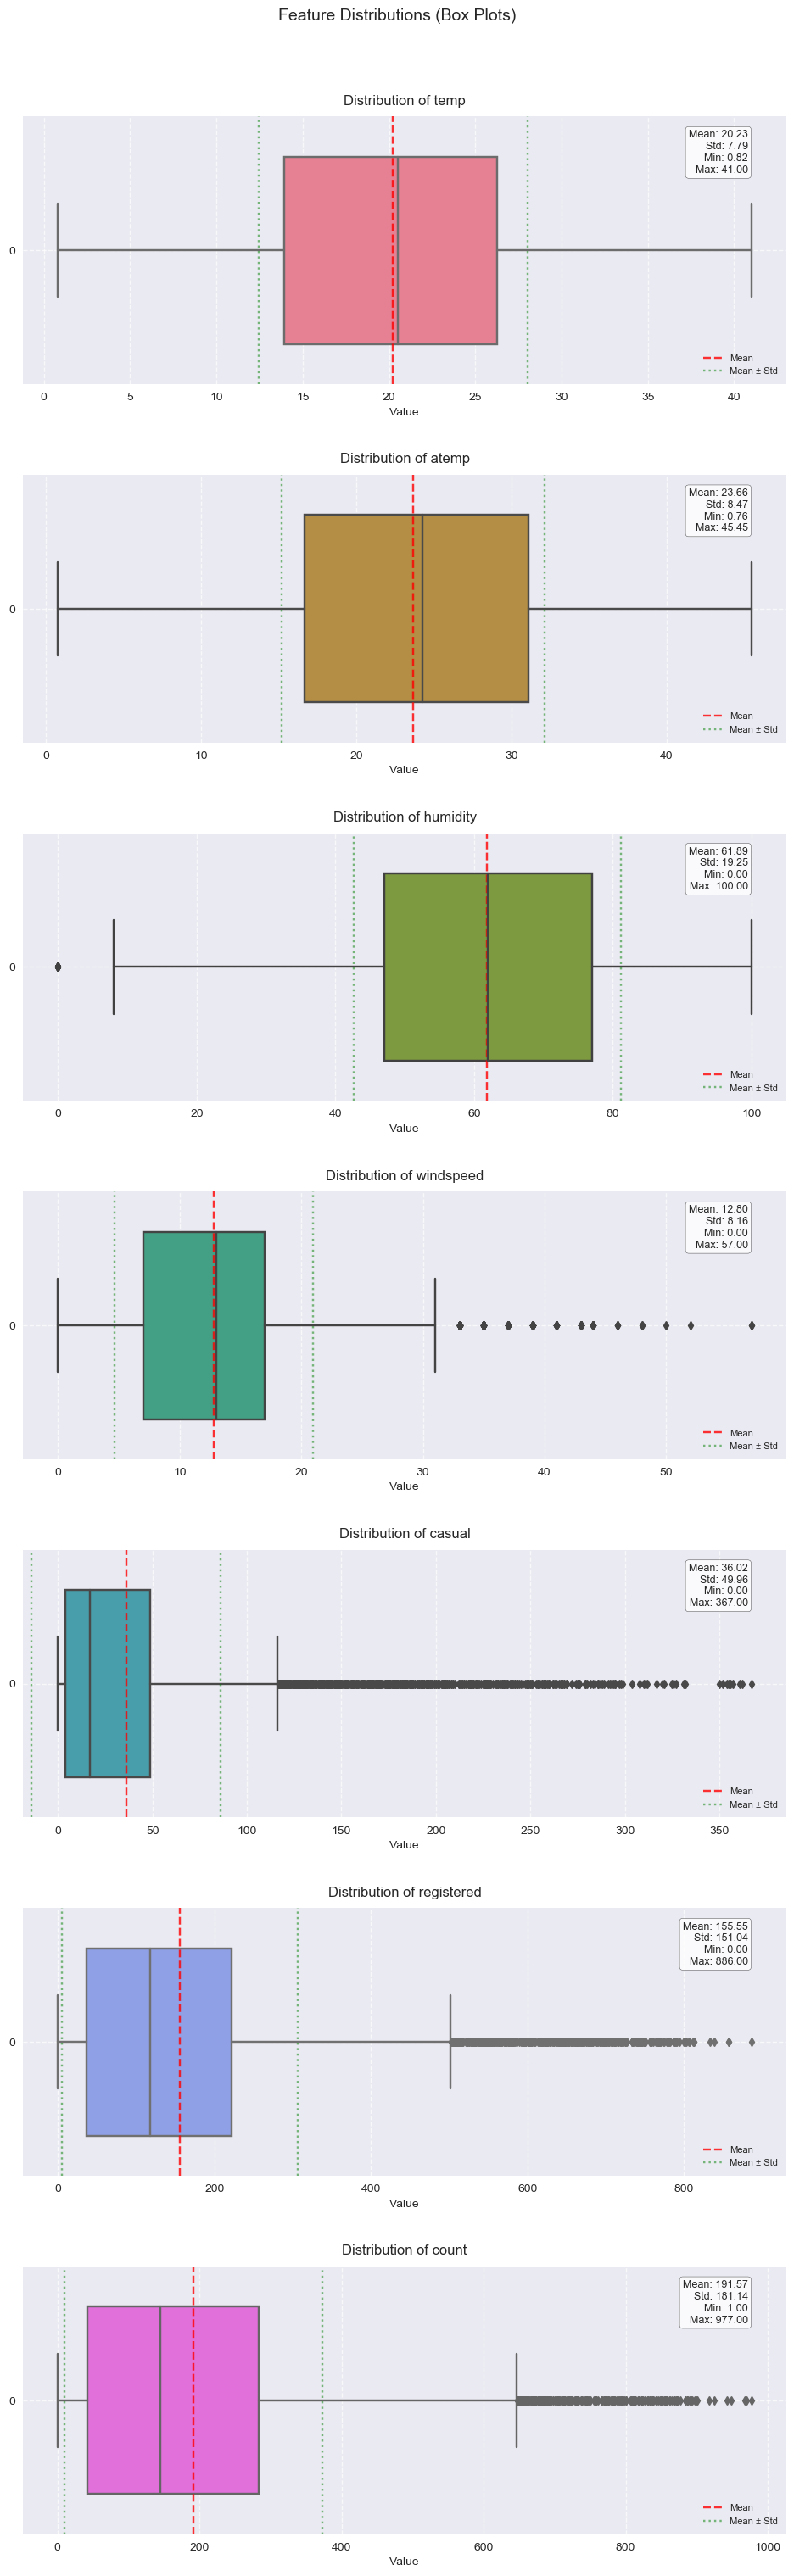

In [12]:
def plot_boxplots(data, columns_to_plot, n_cols=2,figsize=(10, 30)):
    """
    绘制箱型图
    
    参数:
    - data: DataFrame, 输入数据
    - columns_to_plot: list, 需要绘制箱型图的列名列表
    - n_cols: int, 子图列数
    - figsize: tuple, 图形大小，默认根据特征数量自动调整
    """
    # 计算所需行数
    n_features = len(columns_to_plot)
    n_rows = (n_features - 1) // n_cols + 1
    
    # 创建子图
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # 确保axes始终是二维数组
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 设置样式
    plt.style.use('seaborn')
    colors = sns.color_palette("husl", n_features)
    
    for i, (col, color) in enumerate(zip(columns_to_plot, colors)):
        row = i // n_cols
        col_idx = i % n_cols
        ax = axes[row, col_idx]
        
        # 绘制箱型图
        sns.boxplot(data=data[col], 
                   orient="h",
                   width=0.7,
                   color=color,
                   showfliers=True,  # 显示异常值
                   ax=ax)
        
        # 添加误差线
        mean = data[col].mean()
        std = data[col].std()
        ax.axvline(mean, color='red', linestyle='--', alpha=0.8, label='Mean')
        ax.axvline(mean + std, color='green', linestyle=':', alpha=0.5, label='Mean ± Std')
        ax.axvline(mean - std, color='green', linestyle=':', alpha=0.5)
        
        # 添加标题和标签
        ax.set_title(f'Distribution of {col}', 
                    fontsize=12, 
                    pad=10)
        ax.set_xlabel('Value', fontsize=10)
        
        # 添加网格线
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # 美化刻度标签
        ax.tick_params(labelsize=10)
        
        # 添加描述性统计信息
        stats = data[col].describe()
        stats_text = (f'Mean: {stats["mean"]:.2f}\n'
                     f'Std: {stats["std"]:.2f}\n'
                     f'Min: {stats["min"]:.2f}\n'
                     f'Max: {stats["max"]:.2f}')
        
        # 将统计信息放在图的右上角
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=9)
        
        # 添加图例
        ax.legend(loc='lower right', fontsize=8)
    
    # 处理多余的子图
    for i in range(i + 1, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        fig.delaxes(axes[row, col_idx])
    
    # 调整布局
    plt.tight_layout(pad=3.0)
    
    # 添加总标题
    fig.suptitle('Feature Distributions (Box Plots)', 
                fontsize=14, 
                y=1.02)
    
    plt.show()

# 使用示例
columns_to_plot = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
plot_boxplots(train_data, columns_to_plot,n_cols=1)

#### 核密度估计图 KDE

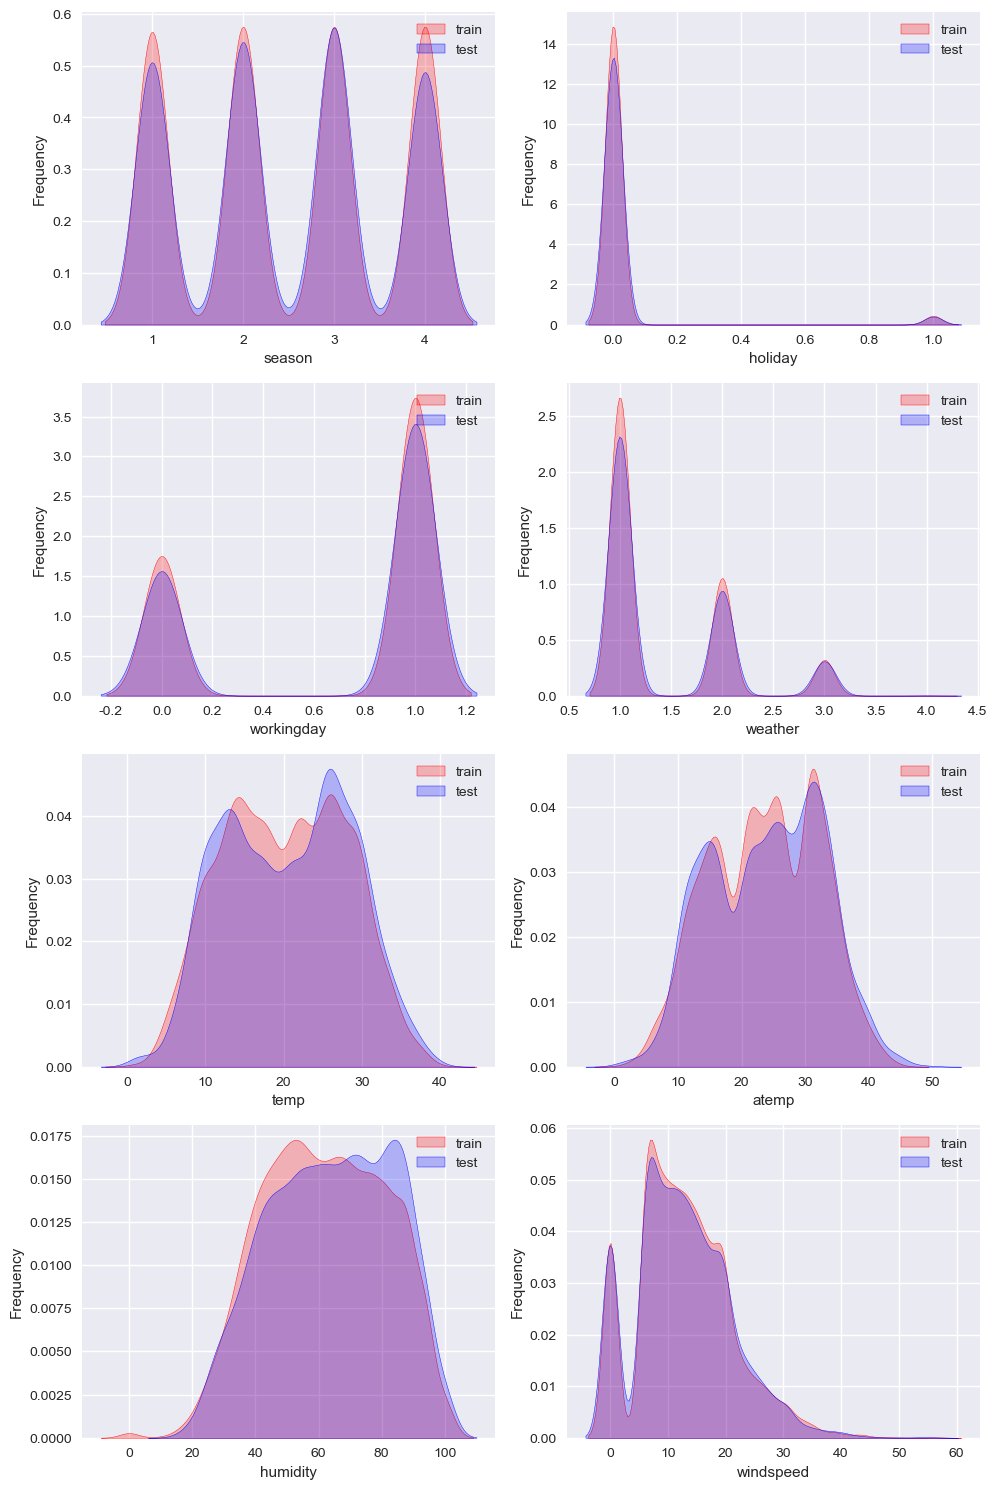

In [13]:
def plot_kde_distributions(train_data, test_data, features_to_plot=None, figsize=None, n_cols=1):
    """
    绘制训练集和测试集的KDE分布对比图
    
    参数:
    - train_data: DataFrame, 训练数据
    - test_data: DataFrame, 测试数据
    - features_to_plot: list, 需要绘制的特征列表。如果为None,则使用test_data的所有列
    - figsize: tuple, 图形大小。如果为None,则自动计算
    - n_cols: int, 图表列数，默认为1
    """
    # 如果未指定特征,则使用测试集的所有数值型列
    if features_to_plot is None:
        features_to_plot = test_data.select_dtypes(include=['int64', 'float64']).columns
    
    # 检查特征是否存在且为数值型
    valid_features = []
    for feature in features_to_plot:
        if (feature not in train_data.columns or 
            feature not in test_data.columns):
            print(f"警告: 特征 {feature} 不存在于训练集或测试集中")
            continue
            
        # 检查数据类型是否为数值型
        if not pd.api.types.is_numeric_dtype(train_data[feature].astype(float)):
            print(f"警告: 特征 {feature} 不是数值型变量")
            continue
            
        valid_features.append(feature)
    
    if not valid_features:
        print("错误: 没有有效的数值型特征可以绘制")
        return
    
    # 计算行数
    n_rows = (len(valid_features) + n_cols - 1) // n_cols
    
    # 设置图形大小
    if figsize is None:
        figsize = (6*n_cols, 4*n_rows)
    
    # 创建图形和子图网格
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # 遍历特征绘制KDE图
    for i, col in enumerate(valid_features):
        # 获取当前子图
        ax = axes[i]
        
        # 绘制训练集KDE
        sns.kdeplot(data=train_data[col].astype(float),
                   color="Red", 
                   fill=True,
                   label="train",
                   ax=ax)
        
        # 绘制测试集KDE
        sns.kdeplot(data=test_data[col].astype(float),
                   color="Blue", 
                   fill=True,
                   label="test",
                   ax=ax)
        
        # 设置标签
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.legend()
    
    # 隐藏多余的子图
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # 调整布局
    plt.tight_layout()
    plt.show()

# 使用示例:
"""
# 1. 默认单列显示
plot_kde_distributions(train_data, test_data)

# 2. 双列显示
plot_kde_distributions(
    train_data, 
    test_data,
    n_cols=2,
    figsize=(15, 20)
)

# 3. 三列显示特定特征
features_to_plot = ['temp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
plot_kde_distributions(
    train_data, 
    test_data,
    features_to_plot=features_to_plot,
    n_cols=3,
    figsize=(18, 8)
)
"""
features_to_plot = ["season","holiday","workingday","weather","temp","atemp","humidity","windspeed"]
plot_kde_distributions(
    train_data, 
    submit_data,
    features_to_plot = features_to_plot,
    n_cols=2,
    figsize=(10, 15)
)

#### 小提琴图

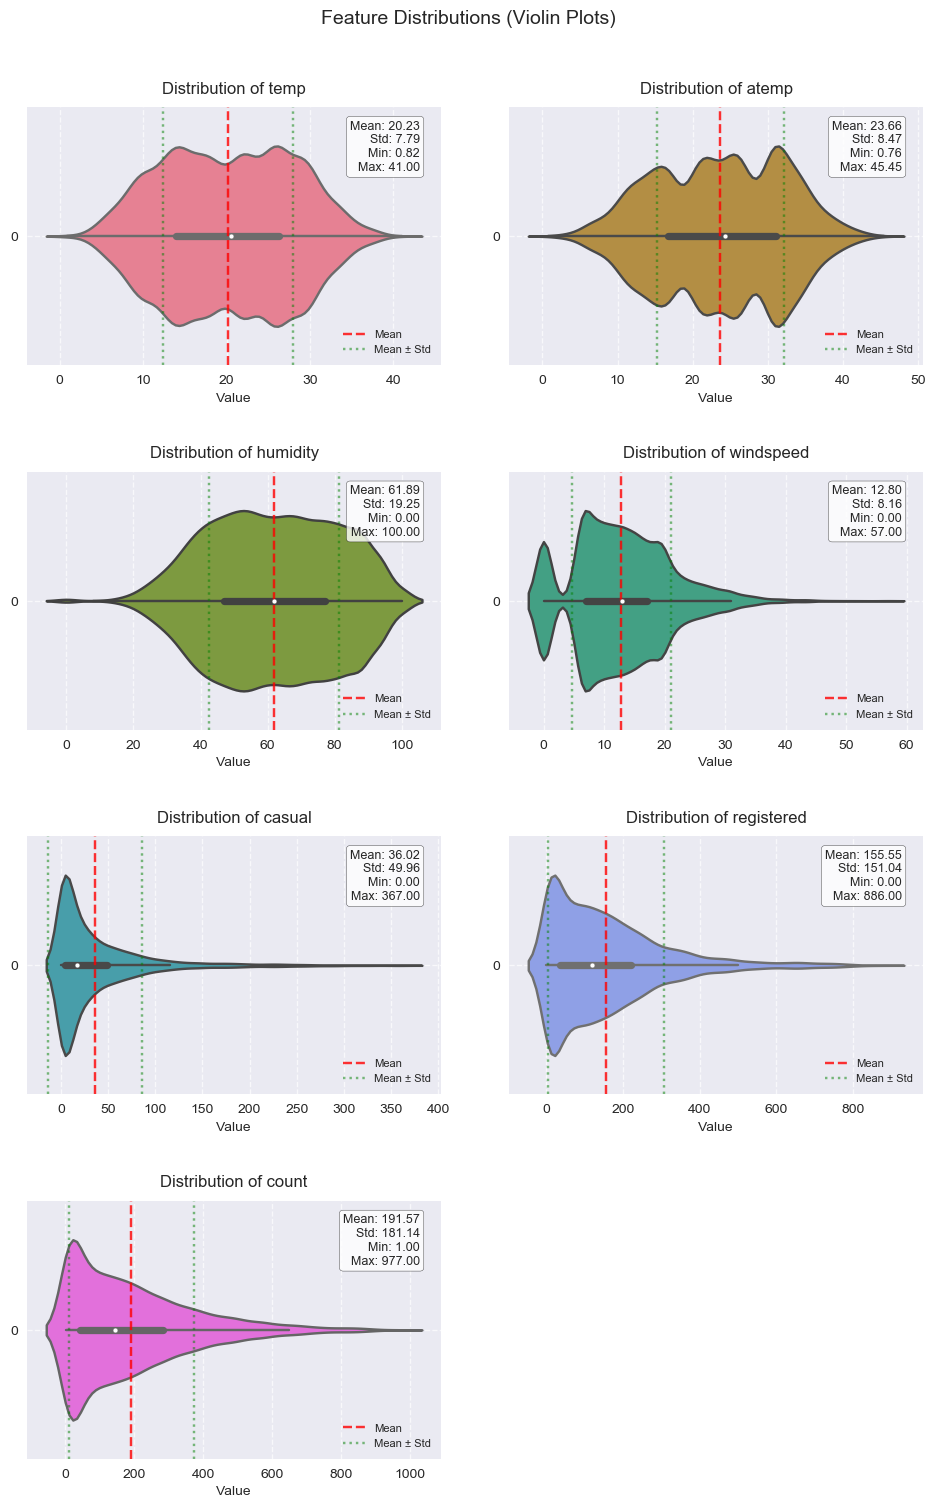

In [14]:
def plot_violinplots(data, columns_to_plot, n_cols=2,figsize=(10, 30)):
    """
    绘制小提琴图
    
    参数:
    - data: DataFrame, 输入数据
    - columns_to_plot: list, 需要绘制小提琴图的列名列表
    - n_cols: int, 子图列数
    - figsize: tuple, 图形大小，默认根据特征数量自动调整
    """
    # 计算所需行数
    n_features = len(columns_to_plot)
    n_rows = (n_features - 1) // n_cols + 1
    
    # 创建子图
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # 确保axes始终是二维数组
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 设置样式
    plt.style.use('seaborn')
    colors = sns.color_palette("husl", n_features)
    
    for i, (col, color) in enumerate(zip(columns_to_plot, colors)):
        row = i // n_cols
        col_idx = i % n_cols
        ax = axes[row, col_idx]
        
        # 绘制小提琴图
        sns.violinplot(data=data[col], 
                   orient="h",
                   width=0.7,
                   color=color,
                   ax=ax)
        
        # 添加误差线
        mean = data[col].mean()
        std = data[col].std()
        ax.axvline(mean, color='red', linestyle='--', alpha=0.8, label='Mean')
        ax.axvline(mean + std, color='green', linestyle=':', alpha=0.5, label='Mean ± Std')
        ax.axvline(mean - std, color='green', linestyle=':', alpha=0.5)
        
        # 添加标题和标签
        ax.set_title(f'Distribution of {col}', 
                    fontsize=12, 
                    pad=10)
        ax.set_xlabel('Value', fontsize=10)
        
        # 添加网格线
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # 美化刻度标签
        ax.tick_params(labelsize=10)
        
        # 添加描述性统计信息
        stats = data[col].describe()
        stats_text = (f'Mean: {stats["mean"]:.2f}\n'
                     f'Std: {stats["std"]:.2f}\n'
                     f'Min: {stats["min"]:.2f}\n'
                     f'Max: {stats["max"]:.2f}')
        
        # 将统计信息放在图的右上角
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=9)
        
        # 添加图例
        ax.legend(loc='lower right', fontsize=8)
    
    # 处理多余的子图
    for i in range(i + 1, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        fig.delaxes(axes[row, col_idx])
    
    # 调整布局
    plt.tight_layout(pad=3.0)
    
    # 添加总标题
    fig.suptitle('Feature Distributions (Violin Plots)', 
                fontsize=14, 
                y=1.02)
    
    plt.show()

# 使用示例
columns_to_plot = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
plot_violinplots(train_data, columns_to_plot,n_cols=2,figsize=(10,15))

### 类别型特征



#### 描述性统计量及条形图


=== Season 的描述性统计 ===
   Count  Percentage
4   2734   25.114826
2   2733   25.105640
3   2733   25.105640
1   2686   24.673893

=== Holiday 的描述性统计 ===
   Count  Percentage
0  10575    97.14312
1    311     2.85688

=== Workingday 的描述性统计 ===
   Count  Percentage
1   7412   68.087452
0   3474   31.912548

=== Weather 的描述性统计 ===
   Count  Percentage
1   7192   66.066507
2   2834   26.033437
3    859    7.890869
4      1    0.009186

=== Weekday 的描述性统计 ===
   Count  Percentage
5   1584   14.550799
6   1579   14.504869
3   1553   14.266030
0   1551   14.247658
2   1551   14.247658
1   1539   14.137424
4   1529   14.045563


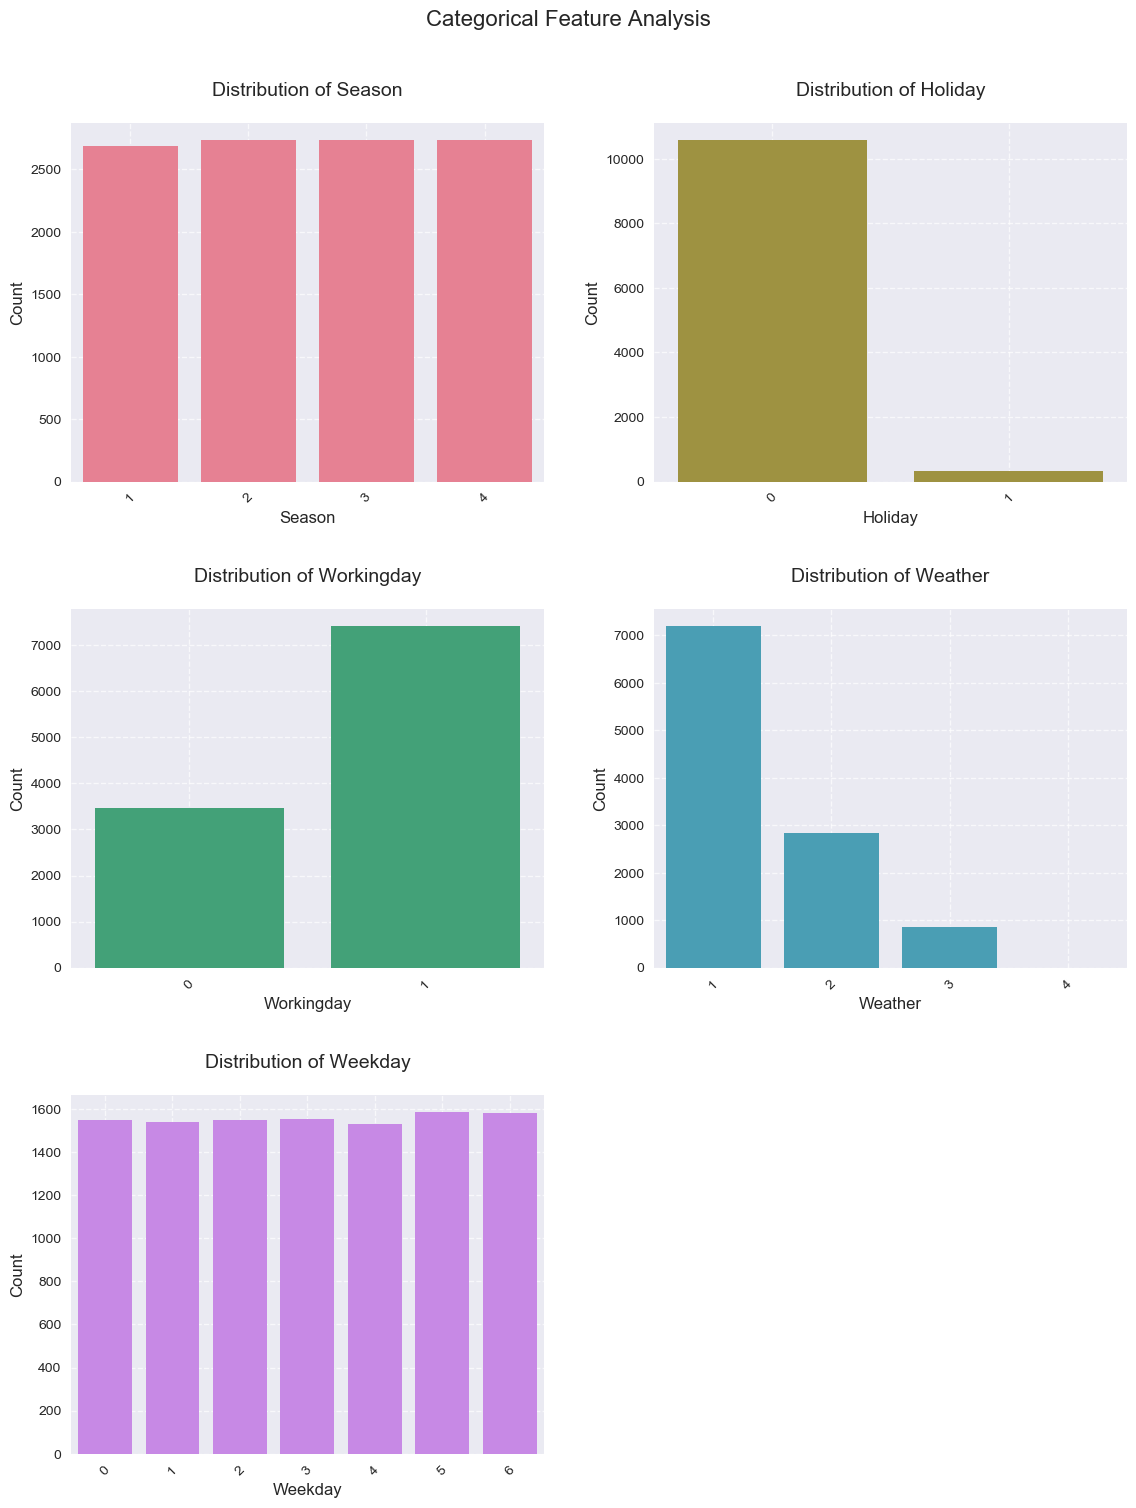

In [15]:
def analyze_categorical_features(data, categorical_features=None, target=None, n_cols=2, figsize=None):
    """
    分析类别型特征的描述性统计量和可视化
    
    参数:
    - data: DataFrame, 输入数据
    - categorical_features: list or None, 需要分析的类别型特征列表，默认为None(自动选择)
    - target: str or None, 目标变量名，默认为None
    - n_cols: int, 子图列数，默认为2
    - figsize: tuple or None, 图形大小，默认为None(自动计算大小)
    """
    # 1. 特征选择
    if categorical_features is None:
        categorical_features = data.select_dtypes(include=['object', 'category', 'int64']).columns.tolist()
        if target in categorical_features:
            categorical_features.remove(target)
        print(f"自动检测到的分类特征: {categorical_features}")
    
    # 2. 特征验证
    valid_features = []
    for feature in categorical_features:
        if feature not in data.columns:
            print(f"警告: 特征 {feature} 不存在")
            continue
        
        n_unique = data[feature].nunique()
        if n_unique > 50:
            print(f"警告: {feature} 的唯一值过多({n_unique})")
            continue
            
        valid_features.append(feature)
    
    if not valid_features:
        print("错误: 没有有效的分类特征")
        return
    
    # 3. 计算布局
    n_features = len(valid_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # 4. 设置图形大小
    if figsize is None:
        width = 6 * n_cols
        height = 5 * n_rows
        figsize = (width, height)
    
    # 5. 创建图形
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # 确保 axes 是二维数组
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 6. 设置样式
    plt.style.use('seaborn')
    colors = sns.color_palette("husl", n_features)
    
    # 7. 遍历特征进行分析和可视化
    for idx, (feature, color) in enumerate(zip(valid_features, colors)):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row][col] if n_rows > 1 or n_cols > 1 else axes[col]
        
        # 计算描述性统计量
        value_counts = data[feature].value_counts()
        percentages = data[feature].value_counts(normalize=True) * 100
        stats_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage': percentages
        })
        
        # 打印描述性统计量
        print(f"\n=== {feature.capitalize()} 的描述性统计 ===")
        print(stats_df)
        
        # 绘制条形图
        sns.barplot(
            x=stats_df.index,
            y='Count',
            data=stats_df,
            ax=ax,
            color=color
        )
        
        # 设置标题和标签
        ax.set_title(f'Distribution of {feature.capitalize()}', fontsize=14, pad=20)
        ax.set_xlabel(feature.capitalize(), fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        
        # 设置刻度
        ax.tick_params(axis='both', labelsize=10)
        ax.tick_params(axis='x', rotation=45)
        
        # 添加网格
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # 8. 删除多余的子图
    if n_features % n_cols != 0 and (n_rows > 1 or n_cols > 1):
        for j in range(n_features, n_rows * n_cols):
            row = j // n_cols
            col = j % n_cols
            fig.delaxes(axes[row][col])
    
    # 9. 调整布局
    plt.tight_layout(pad=3.0)
    
    # 10. 添加总标题
    fig.suptitle(
        'Categorical Feature Analysis', 
        fontsize=16, 
        y=1.02
    )
    
    plt.show()

# 使用示例
"""
# 基本使用
analyze_categorical_features(train_data)

# 指定特征
analyze_categorical_features(
    data=train_data,
    categorical_features=['season', 'holiday', 'workingday', 'weather']
)

# 自定义大小
analyze_categorical_features(
    data=train_data,
    categorical_features=['hour', 'weekday', 'month'],
    figsize=(15, 20)
)
"""
categorical_features=['season','holiday',  'workingday','weather','weekday']
analyze_categorical_features(
    data=train_data,
    categorical_features=categorical_features,
    n_cols=2
)

## 统计量分析- 双变量/多变量分析

### 1. 数值型特征 vs. 数值型特征

#### 散点图

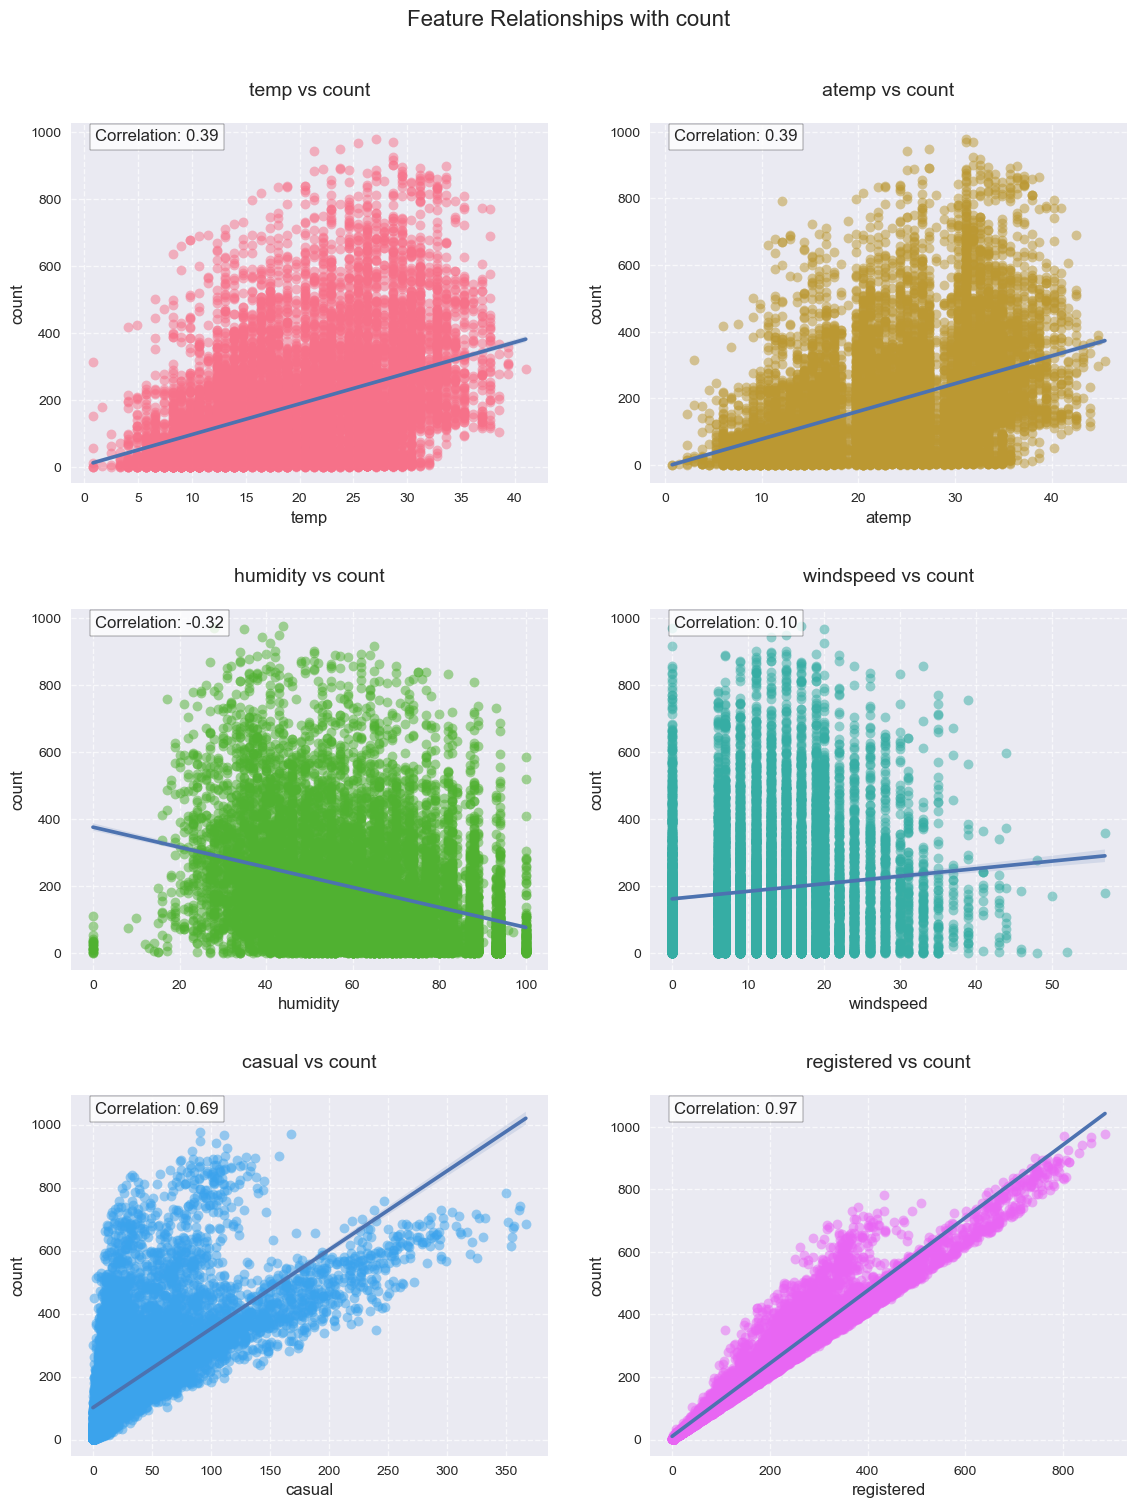

In [16]:
def plot_feature_target_relationships(data, features_to_plot=None, target='count', figsize=None, n_cols=1):
    """
    绘制特征与目标变量的关系图，支持自定义布局
    
    参数:
    - data: DataFrame, 输入数据
    - features_to_plot: list or None, 需要绘制的特征列表，默认为None(自动选择数值特征)
    - target: str, 目标变量名，默认为'count'
    - figsize: tuple or None, 图形大小，默认为None(自动计算大小)
    - n_cols: int, 子图列数，默认为1
    """
    # 1. 特征选择
    if features_to_plot is None:
        features_to_plot = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
        if target in features_to_plot:
            features_to_plot.remove(target)
    
    # 2. 计算行列数
    n_features = len(features_to_plot)
    n_rows = (n_features - 1) // n_cols + 1
    
    # 3. 智能计算图形尺寸（如果未指定）
    if figsize is None:
        width = 6 * n_cols  # 每列6个单位宽度
        height = 5 * n_rows  # 每行5个单位高度
        figsize = (width, height)
    
    # 4. 创建图形
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # 确保axes是二维数组
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 5. 设置样式
    plt.style.use('seaborn')
    colors = sns.color_palette("husl", n_features)
    
    # 6. 绘制每个特征
    for idx, (feature, color) in enumerate(zip(features_to_plot, colors)):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # 散点图和回归线
        sns.regplot(
            x=feature, 
            y=target, 
            data=data,
            ax=ax,
            scatter_kws={
                'alpha': 0.5,
                's': 50,
                'color': color
            },
            # line_kws={
            #     'color': 'red',
            #     'linewidth': 2
            # }
        )
        
        # 设置标题和标签
        ax.set_title(f'{feature} vs {target}', fontsize=14, pad=20)
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel(target, fontsize=12)
        
        # 设置刻度
        ax.tick_params(axis='both', labelsize=10)
        
        # 添加网格
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # 添加相关系数
        corr = data[[feature, target]].corr().iloc[0, 1]
        ax.text(
            0.05, 0.95, 
            f'Correlation: {corr:.2f}',
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    # 7. 删除多余的子图
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])
    
    # 8. 调整布局
    plt.tight_layout(pad=3.0)
    
    # 9. 添加总标题
    fig.suptitle(
        f'Feature Relationships with {target}', 
        fontsize=16, 
        y=1.02
    )
    
    # 10. 只显示图形,不返回对象
    plt.show()

# 使用示例
"""
# 1. 默认单列布局
plot_feature_target_relationships(train_data)

# 2. 双列布局
plot_feature_target_relationships(train_data, n_cols=2)

# 3. 三列布局并自定义大小
plot_feature_target_relationships(
    train_data,
    n_cols=3,
    figsize=(20, 15)
)

# 4. 完整自定义
features = ['temp', 'atemp', 'humidity', 'windspeed']
plot_feature_target_relationships(
    data=train_data,
    features_to_plot=features,
    target='registered',
    n_cols=2,
    figsize=(15, 10)
)
"""
features_to_plot = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']
plot_feature_target_relationships(
    train_data,
    features_to_plot,
    target='count',
    n_cols=2,
)

#### 热力图

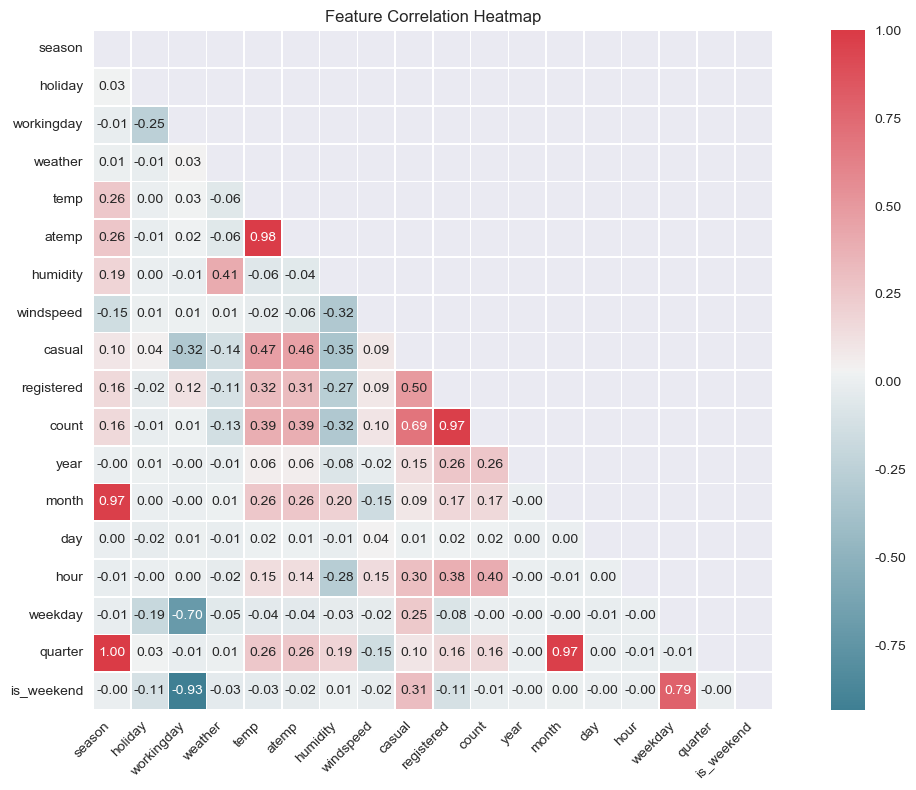


=== 特征相关性分析结果 ===

已排除的特征 (2个):
['minute', 'is_month_end']

1. 相关系数大于 0.3 的特征 (7个):
['count', 'registered', 'casual', 'hour', 'temp', 'atemp', 'humidity']

2. 相关性最强的前 5 个特征:
['count', 'registered', 'casual', 'hour', 'temp']

3. 同时满足以上两个条件的特征:
['temp', 'hour', 'count', 'registered', 'casual']

4. 按相关性强度划分的特征:

Extremely Strong Correlation (|r| >= 0.7):
registered: 0.9709

Strong Correlation (|r| >= 0.5):
casual: 0.6904

Moderate Correlation (|r| >= 0.3):
hour: 0.4006
temp: 0.3945
atemp: 0.3898
humidity: -0.3174

Weak Correlation (|r| >= 0.1):
year: 0.2604
month: 0.1669
quarter: 0.1634
season: 0.1634
windspeed: 0.1014
weather: -0.1287

Very Weak Correlation (|r| >= 0):
day: 0.0198
workingday: 0.0116
weekday: -0.0023
holiday: -0.0054
is_weekend: -0.0099


In [17]:
def analyze_feature_correlations(
    data, 
    target='target', 
    k=10, 
    threshold=0.5, 
    figsize=(12, 8),
    exclude_features=None  # 新增参数：要排除的特征列表
):
    """
    分析特征与目标变量的相关性
    
    参数:
    - data: DataFrame, 输入数据
    - target: str, 目标变量名
    - k: int, 选择最相关的特征数量
    - threshold: float, 相关系数阈值
    - figsize: tuple, 图形大小
    - exclude_features: list, 要排除的特征列表，默认为None
    
    返回:
    - dict: 包含分析结果的字典
    """
    # 处理要排除的特征
    if exclude_features is None:
        exclude_features = []
    
    # 确保target不在排除列表中
    if target in exclude_features:
        exclude_features.remove(target)
        print(f"警告：目标变量 {target} 已从排除列表中移除")
    
    # 获取参与分析的特征列
    analysis_features = [col for col in data.columns 
                        if col not in exclude_features]
    
    # 使用筛选后的特征计算相关系数矩阵
    corr_matrix = data[analysis_features].corr()
    
    # 相关性强度阈值
    correlation_thresholds = {
        'extremely_strong': 0.7,  # 极强相关
        'strong': 0.5,           # 强相关
        'moderate': 0.3,         # 中等相关
        'weak': 0.1              # 弱相关
    }
    
    # 创建图形
    plt.figure(figsize=figsize)
    
    # 创建遮罩
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # 绘制热力图
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, 
                mask=mask,
                cmap=cmap,
                square=True,
                annot=True,
                fmt='.2f',
                cbar=True,
                linewidths=.5,
                linecolor='white'
                ) 
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=45, ha='right')  # 优化x轴标签显示
    plt.yticks(rotation=0)
    plt.tight_layout()  # 优化布局
    plt.show()
    
    # 获取所有特征与目标变量的相关系数并排序
    target_correlations = corr_matrix[target].sort_values(ascending=False)
    
    # 按相关性强度分类特征
    correlation_categories = {
        'extremely_strong': [],
        'strong': [],
        'moderate': [],
        'weak': [],
        'very_weak': []
    }
    
    for feature, corr in target_correlations.items():
        if feature == target:
            continue
        abs_corr = abs(corr)
        if abs_corr >= correlation_thresholds['extremely_strong']:
            correlation_categories['extremely_strong'].append((feature, corr))
        elif abs_corr >= correlation_thresholds['strong']:
            correlation_categories['strong'].append((feature, corr))
        elif abs_corr >= correlation_thresholds['moderate']:
            correlation_categories['moderate'].append((feature, corr))
        elif abs_corr >= correlation_thresholds['weak']:
            correlation_categories['weak'].append((feature, corr))
        else:
            correlation_categories['very_weak'].append((feature, corr))
    
    # 特征筛选
    high_corr_features = corr_matrix.index[abs(corr_matrix[target]) > threshold]
    high_corr_series = corr_matrix[target][high_corr_features]
    high_corr_series = high_corr_series.reindex(
        high_corr_series.abs().sort_values(ascending=False).index
    )
    
    top_k_features = corr_matrix.nlargest(k, target)[target].index
    common_features = list(set(high_corr_series.index).intersection(set(top_k_features)))
    
    # 打印分析结果
    print("\n=== 特征相关性分析结果 ===")
    if exclude_features:
        print(f"\n已排除的特征 ({len(exclude_features)}个):")
        print(exclude_features)
        
    print(f"\n1. 相关系数大于 {threshold} 的特征 ({len(high_corr_features)}个):")
    print(high_corr_series.index.tolist())
    
    print(f"\n2. 相关性最强的前 {k} 个特征:")
    print(top_k_features.tolist())
    
    print("\n3. 同时满足以上两个条件的特征:")
    print(common_features)
    
    print("\n4. 按相关性强度划分的特征:")
    for category, features in correlation_categories.items():
        if features:
            print(f"\n{category.replace('_', ' ').title()} Correlation (|r| >= {correlation_thresholds.get(category, 0)}):")
            for feature, corr in features:
                print(f"{feature}: {corr:.4f}")
    
    # 返回结果字典
    return {
        'high_corr_features': high_corr_series.index,
        'top_k_features': top_k_features,
        'target_correlations': target_correlations,
        'common_features': common_features,
        'correlation_categories': correlation_categories,
        'excluded_features': exclude_features  # 新增：返回被排除的特征
    }

# 使用示例

results = analyze_feature_correlations(
    data=train_data,
    target='count',
    k=5,
    threshold=0.3,
    exclude_features=['minute','is_month_end']  # 排除这些特征
)



### 2. 类别型特征 vs. 数值型特征

#### 箱线图 (Box Plot) 和小提琴图

初看之下，"count"变量包含许多异常数据点，这使得分布向右偏斜（因为有更多的数据点超出了外四分位限）。但除此之外，从下面的简单箱线图中还可以得出以下结论：

 - 春季的租赁数量相对较低。箱线图中位数值的下降证实了这一点。
 - "每日小时数"的箱线图非常有趣。在上午7-8点和下午5-6点，中位数值相对较高。这可以归因于该时段的常规上学和上班用户。
 - 大多数异常点主要来自"工作日"而不是"非工作日"。从图4中可以清楚地看到这一点。

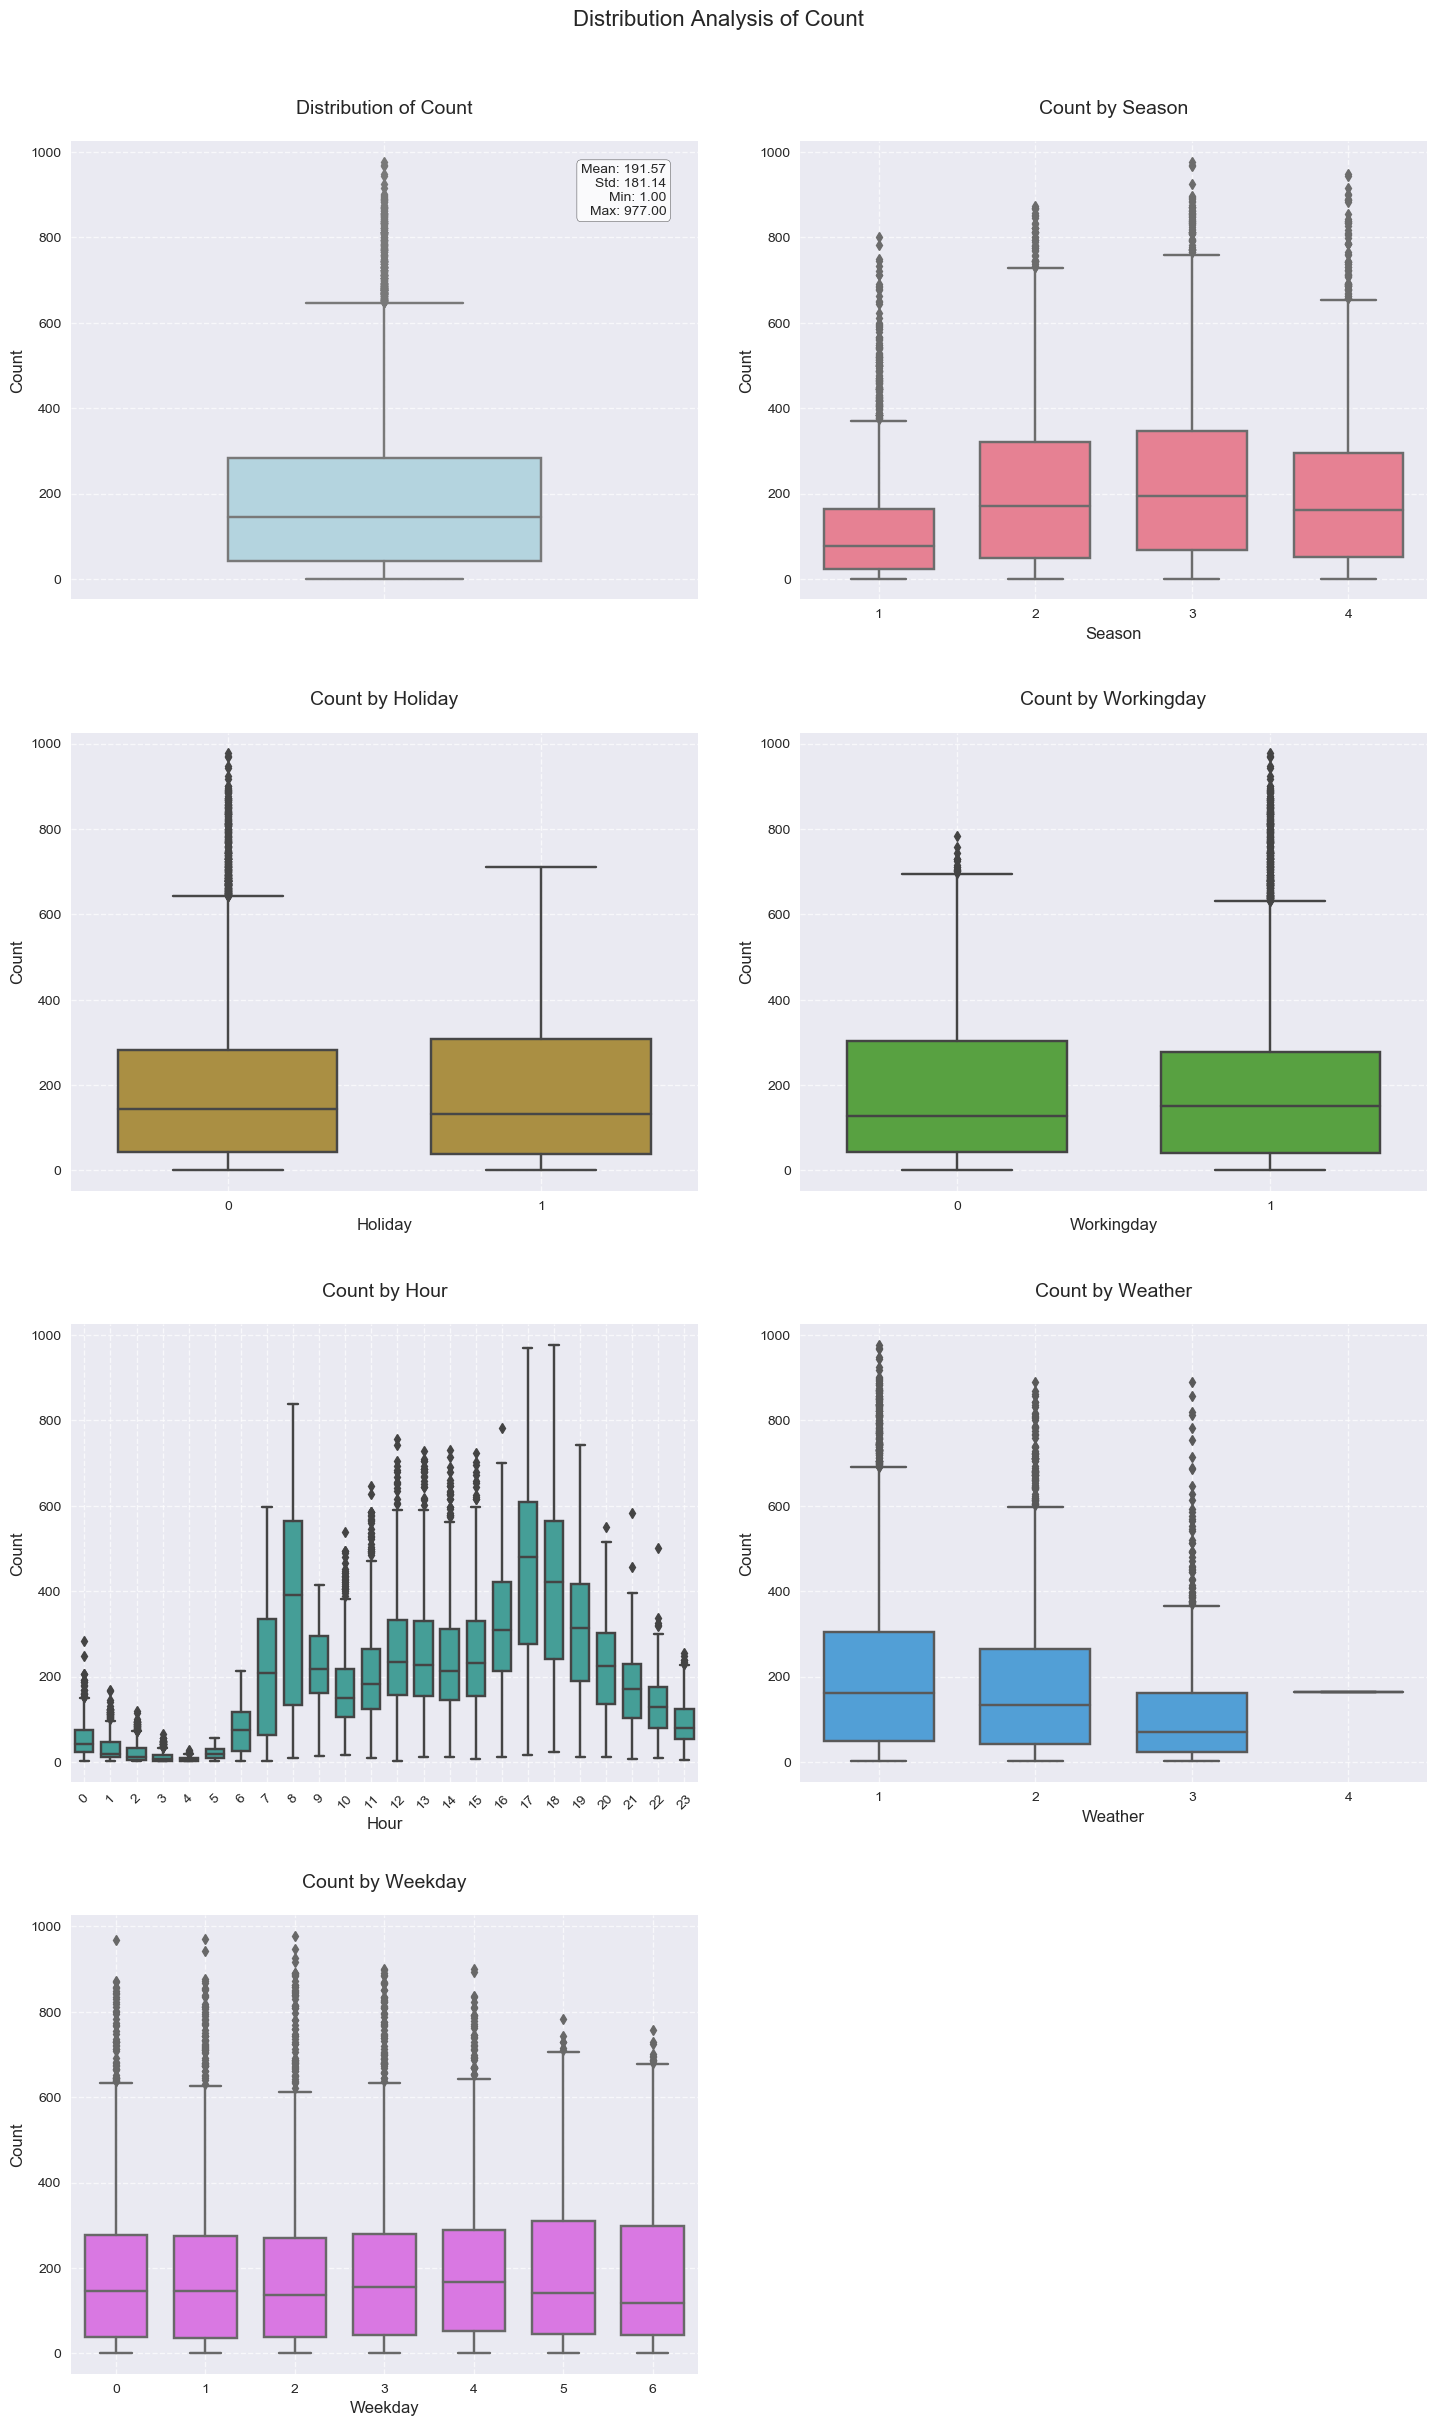

In [18]:
def plot_boxplots_with_target(data, target, categorical_features=None, figsize=None):
    """
    绘制优化版本的目标变量箱型图分析
    
    参数:
    - data: DataFrame, 输入数据
    - target: str, 目标变量名称
    - categorical_features: list or None, 分类特征列表
    - figsize: tuple or None, 图形大小，默认根据特征数量自动计算
    """
    # 1. 特征处理
    if categorical_features is None:
        categorical_features = data.select_dtypes(include=['object', 'category', 'int64']).columns
        categorical_features = [col for col in categorical_features if col != target]
        print(f"自动检测到的分类特征: {categorical_features}")
    
    # 2. 特征验证
    valid_features = []
    for feature in categorical_features:
        if feature not in data.columns:
            print(f"警告: 特征 {feature} 不存在")
            continue
        
        n_unique = data[feature].nunique()
        if n_unique > 50:
            print(f"警告: {feature} 的唯一值过多({n_unique})")
            continue
            
        valid_features.append(feature)
    
    if not valid_features:
        print("错误: 没有有效的分类特征")
        return
    
    # 3. 计算布局
    n_plots = len(valid_features) + 1
    n_cols = 2
    n_rows = (n_plots + 1) // n_cols
    
    # 4. 设置图形大小
    if figsize is None:
        figsize = (15, 6 * n_rows)  # 自动计算合适的高度
    
    # 5. 创建图形
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.style.use('seaborn')
    
    # 6. 绘制总体分布箱型图
    sns.boxplot(
        data=data,
        y=target,
        orient="v",
        ax=axes[0][0],
        color='lightblue',
        width=0.5
    )
    axes[0][0].set_title(f'Distribution of {target.capitalize()}', 
                        fontsize=14, pad=20)
    axes[0][0].set_ylabel(target.capitalize(), fontsize=12)
    axes[0][0].tick_params(labelsize=10)
    axes[0][0].grid(True, linestyle='--', alpha=0.7)
    
    # 添加描述性统计
    stats = data[target].describe()
    stats_text = (f'Mean: {stats["mean"]:.2f}\n'
                 f'Std: {stats["std"]:.2f}\n'
                 f'Min: {stats["min"]:.2f}\n'
                 f'Max: {stats["max"]:.2f}')
    axes[0][0].text(
        0.95, 0.95, stats_text,
        transform=axes[0][0].transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=10
    )
    
    # 7. 绘制特征关系箱型图
    colors = sns.color_palette("husl", len(valid_features))
    for i, (feature, color) in enumerate(zip(valid_features, colors)):
        row = (i + 1) // 2
        col = (i + 1) % 2
        
        # 绘制箱型图
        sns.boxplot(
            data=data,
            x=feature,
            y=target,
            orient="v",
            ax=axes[row][col],
            color=color,
            width=0.7
        )
        
        # 设置标题和标签
        axes[row][col].set_title(f'{target.capitalize()} by {feature.capitalize()}', 
                                fontsize=14, pad=20)
        axes[row][col].set_xlabel(feature.capitalize(), fontsize=12)
        axes[row][col].set_ylabel(target.capitalize(), fontsize=12)
        
        # 设置刻度
        axes[row][col].tick_params(axis='both', labelsize=10)
        if len(data[feature].unique()) > 10:
            axes[row][col].tick_params(axis='x', rotation=45)
        
        # 添加网格
        axes[row][col].grid(True, linestyle='--', alpha=0.7)
        

    
    # 8. 删除多余的子图
    if len(valid_features) % 2 == 0:
        fig.delaxes(axes[n_rows-1][1])
    
    # 9. 调整布局
    plt.tight_layout(pad=3.0)
    
    # 10. 添加总标题
    fig.suptitle(
        f'Distribution Analysis of {target.capitalize()}', 
        fontsize=16, 
        y=1.02
    )
    plt.show()
    #return fig, axes

# 使用示例
"""
# 基本使用
plot_boxplots_with_target(train_data, target='count')

# 指定特征
plot_boxplots_with_target(
    data=train_data,
    target='count',
    categorical_features=['season', 'holiday', 'workingday', 'weather']
)

# 自定义大小
plot_boxplots_with_target(
    data=train_data,
    target='count',
    categorical_features=['hour', 'weekday', 'month'],
    figsize=(15, 20)
)
"""
plot_boxplots_with_target(
    data=train_data,
    target='count',
    categorical_features=['season','holiday',  'workingday','hour','weather','weekday']
)

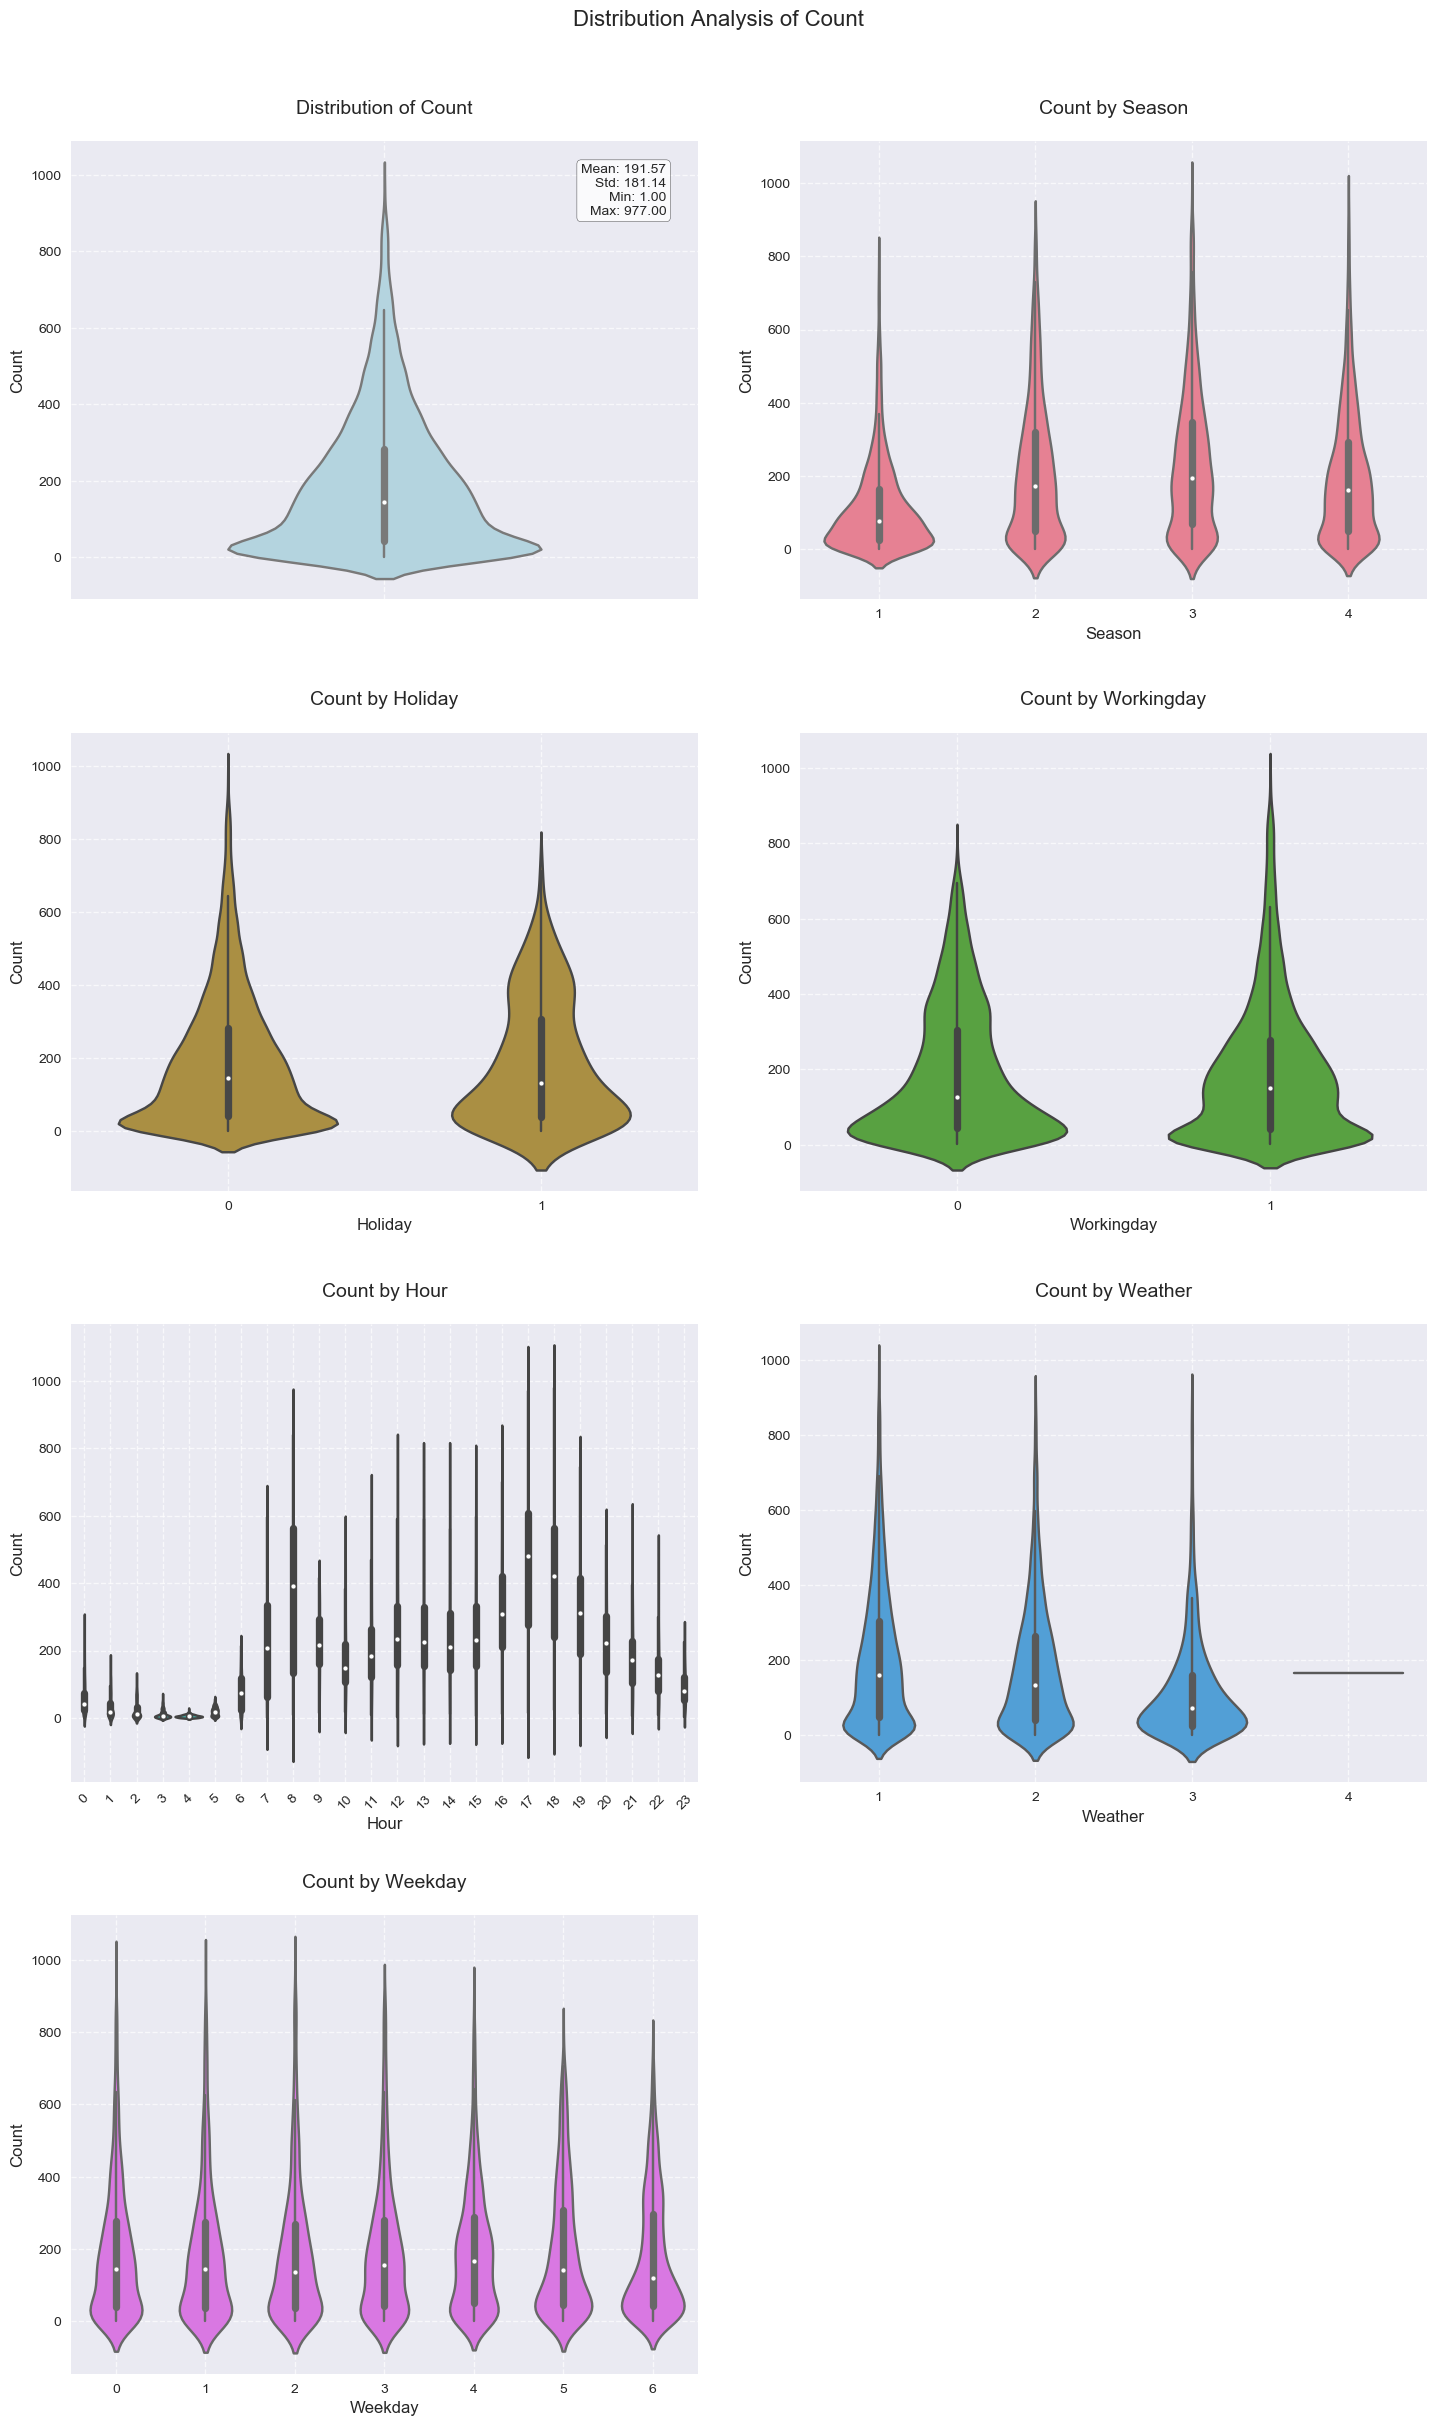

In [19]:
def plot_boxplots_with_target(data, target, categorical_features=None, n_cols=2, figsize=None, violin_width=0.7):
    """
    绘制目标变量小提琴图分析
    
    参数:
    - data: DataFrame, 输入数据
    - target: str, 目标变量名称
    - categorical_features: list or None, 分类特征列表
    - n_cols: int, 子图列数，默认为2
    - figsize: tuple or None, 图形大小，默认根据特征数量自动计算
    - violin_width: float, 小提琴图的宽度，默认为0.7
    """
    # 1. 特征处理
    if categorical_features is None:
        categorical_features = data.select_dtypes(include=['object', 'category', 'int64']).columns
        categorical_features = [col for col in categorical_features if col != target]
        print(f"自动检测到的分类特征: {categorical_features}")
    
    # 2. 特征验证
    valid_features = []
    for feature in categorical_features:
        if feature not in data.columns:
            print(f"警告: 特征 {feature} 不存在")
            continue
        
        n_unique = data[feature].nunique()
        if n_unique > 50:
            print(f"警告: {feature} 的唯一值过多({n_unique})")
            continue
            
        valid_features.append(feature)
    
    if not valid_features:
        print("错误: 没有有效的分类特征")
        return
    
    # 3. 计算布局
    n_plots = len(valid_features) + 1
    n_rows = (n_plots + n_cols - 1) // n_cols  # 使用向上取整
    
    # 4. 设置图形大小
    if figsize is None:
        figsize = (15, 6 * n_rows)  # 自动计算合适的高度
    
    # 5. 创建图形
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.style.use('seaborn')
    
    # 确保 axes 是二维数组
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 6. 绘制总体分布小提琴图
    sns.violinplot(
        data=data,
        y=target,
        orient="v",
        ax=axes[0][0] if n_rows > 1 or n_cols > 1 else axes[0], # 处理单子图情况
        color='lightblue',
        width=0.5
    )
    ax_main = axes[0][0] if n_rows > 1 or n_cols > 1 else axes[0]
    ax_main.set_title(f'Distribution of {target.capitalize()}', 
                        fontsize=14, pad=20)
    ax_main.set_ylabel(target.capitalize(), fontsize=12)
    ax_main.tick_params(labelsize=10)
    ax_main.grid(True, linestyle='--', alpha=0.7)
    
    # 添加描述性统计
    stats = data[target].describe()
    stats_text = (f'Mean: {stats["mean"]:.2f}\n'
                 f'Std: {stats["std"]:.2f}\n'
                 f'Min: {stats["min"]:.2f}\n'
                 f'Max: {stats["max"]:.2f}')
    ax_main.text(
        0.95, 0.95, stats_text,
        transform=ax_main.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=10
    )
    
    # 7. 绘制特征关系小提琴图
    colors = sns.color_palette("husl", len(valid_features))
    for i, (feature, color) in enumerate(zip(valid_features, colors)):
        row = (i + 1) // n_cols
        col = (i + 1) % n_cols
        ax = axes[row][col] if n_rows > 1 or n_cols > 1 else axes[col]
        
        # 绘制小提琴图
        sns.violinplot(
            data=data,
            x=feature,
            y=target,
            orient="v",
            ax=ax,
            color=color,
            width=violin_width if feature != 'hour' else violin_width * 1.5 # 调整hour的宽度
        )
        
        # 设置标题和标签
        ax.set_title(f'{target.capitalize()} by {feature.capitalize()}', 
                                fontsize=14, pad=20)
        ax.set_xlabel(feature.capitalize(), fontsize=12)
        ax.set_ylabel(target.capitalize(), fontsize=12)
        
        # 设置刻度
        ax.tick_params(axis='both', labelsize=10)
        if len(data[feature].unique()) > 10:
            ax.tick_params(axis='x', rotation=45)
        
        # 添加网格
        ax.grid(True, linestyle='--', alpha=0.7)
        

    
    # 8. 删除多余的子图
    if n_plots % n_cols != 0 and (n_rows > 1 or n_cols > 1):
        for j in range(n_plots, n_rows * n_cols):
            row = j // n_cols
            col = j % n_cols
            fig.delaxes(axes[row][col])
    
    # 9. 调整布局
    plt.tight_layout(pad=3.0)
    
    # 10. 添加总标题
    fig.suptitle(
        f'Distribution Analysis of {target.capitalize()}', 
        fontsize=16, 
        y=1.02
    )
    plt.show()
    #return fig, axes

# 使用示例
"""
# 基本使用
plot_boxplots_with_target(train_data, target='count')

# 指定特征
plot_boxplots_with_target(
    data=train_data,
    target='count',
    categorical_features=['season', 'holiday', 'workingday', 'weather']
)

# 自定义大小
plot_boxplots_with_target(
    data=train_data,
    target='count',
    categorical_features=['hour', 'weekday', 'month'],
    figsize=(15, 20)
)
"""
plot_boxplots_with_target(
    data=train_data,
    target='count',
    categorical_features=['season','holiday',  'workingday','hour','weather','weekday'],
    n_cols=2, # 自定义列数
)

### 3. 类别型特征 vs. 类别型特征

#### 交叉表

In [20]:
def plot_categorical_relationship(data, cat_features, n_cols=2, figsize=None):
    """
    绘制类别型特征之间的交叉表
    
    参数:
    - data: DataFrame, 输入数据
    - cat_features: list, 需要分析的两个类别型特征列表
    - n_cols: int, 子图列数，默认为2
    - figsize: tuple or None, 图形大小，默认为None(自动计算大小)
    """
    # 1. 特征验证
    if len(cat_features) != 2:
        print("错误: 请提供两个类别型特征进行分析")
        return
    
    for feature in cat_features:
        if feature not in data.columns:
            print(f"警告: 特征 {feature} 不存在")
            return
        
        n_unique = data[feature].nunique()
        if n_unique > 50:
            print(f"警告: {feature} 的唯一值过多({n_unique})")
            return
    
    # 2. 计算布局
    n_plots = 1  # 只绘制交叉表
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # 3. 设置图形大小
    if figsize is None:
        width = 10 * n_cols
        height = 6 * n_rows
        figsize = (width, height)
    
    # 4. 创建图形
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # 确保 axes 是二维数组
    if n_rows == 1 and n_cols == 1:
        ax_cross = axes
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
        ax_cross = axes[0][0]
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
        ax_cross = axes[0][0]
    else:
        ax_cross = axes[0][0]
    
    # 5. 设置样式
    plt.style.use('seaborn')
    
    # 6. 计算交叉表
    cross_tab = pd.crosstab(data[cat_features[0]], data[cat_features[1]])
    
    # 7. 绘制交叉表
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', ax=ax_cross)
    ax_cross.set_title(f'Crosstab of {cat_features[0].capitalize()} vs {cat_features[1].capitalize()}', fontsize=14, pad=20)
    ax_cross.set_xlabel(cat_features[1].capitalize(), fontsize=12)
    ax_cross.set_ylabel(cat_features[0].capitalize(), fontsize=12)
    ax_cross.tick_params(axis='both', labelsize=10)
    
    
    # 8. 删除多余的子图
    if n_plots % n_cols != 0 and (n_rows > 1 or n_cols > 1):
        for j in range(n_plots, n_rows * n_cols):
            row = j // n_cols
            col = j % n_cols
            fig.delaxes(axes[row][col])
    
    # 9. 调整布局
    plt.tight_layout(pad=3.0)
    
    # 10. 添加总标题
    fig.suptitle(
        f'Relationship Analysis of {cat_features[0].capitalize()} and {cat_features[1].capitalize()}', 
        fontsize=16, 
        y=1.02
    )
    
    plt.show()

# 使用示例
"""
# 基本使用
plot_categorical_relationship(train_data, cat_features=['season', 'weather'])

# 自定义大小
plot_categorical_relationship(
    data=train_data,
    cat_features=['weekday', 'hour'],
    figsize=(15, 10)
)
"""
#plot_categorical_relationship(data=train_data,cat_features=['weekday', 'hour'])


"\n# 基本使用\nplot_categorical_relationship(train_data, cat_features=['season', 'weather'])\n\n# 自定义大小\nplot_categorical_relationship(\n    data=train_data,\n    cat_features=['weekday', 'hour'],\n    figsize=(15, 10)\n)\n"

# 3 特征工程

https://www.kaggle.com/code/fatmakursun/bike-sharing-feature-engineering

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  object        
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  date        10886 non-null  datetime64[ns]
 13  year        10886 non-null  int32         
 14  month       10886 non-null  int32         
 15  day         10886 non-null  int32         
 16  hour        10886 non-

## 3.1 数据预处理

In [22]:
# 加载数据集
#train_data = pd.read_csv("./data/train.csv")
#submit_data = pd.read_csv("./data/test.csv")

### 数据清洗


#### **重复值处理**

In [23]:


def del_duplicates(data: pd.DataFrame) -> pd.DataFrame:
    """
    删除DataFrame中的重复行，并重置索引。

    Args:
        data: 输入的pandas DataFrame。

    Returns:
        处理后的pandas DataFrame，已删除重复行并重置索引。
    """
    num_duplicates = data.duplicated().sum()
    print(f"检测到 {num_duplicates} 条重复行。")

    if num_duplicates > 0:
        print(f"重复行如下：\n{data[data.duplicated()]}")
        data = data.drop_duplicates().reset_index(drop=True)
        print("已删除重复行并重置索引。")
    else:
        print("未检测到重复行。")

    return data


train_data = del_duplicates(train_data)




检测到 0 条重复行。
未检测到重复行。


#### **缺失值处理**

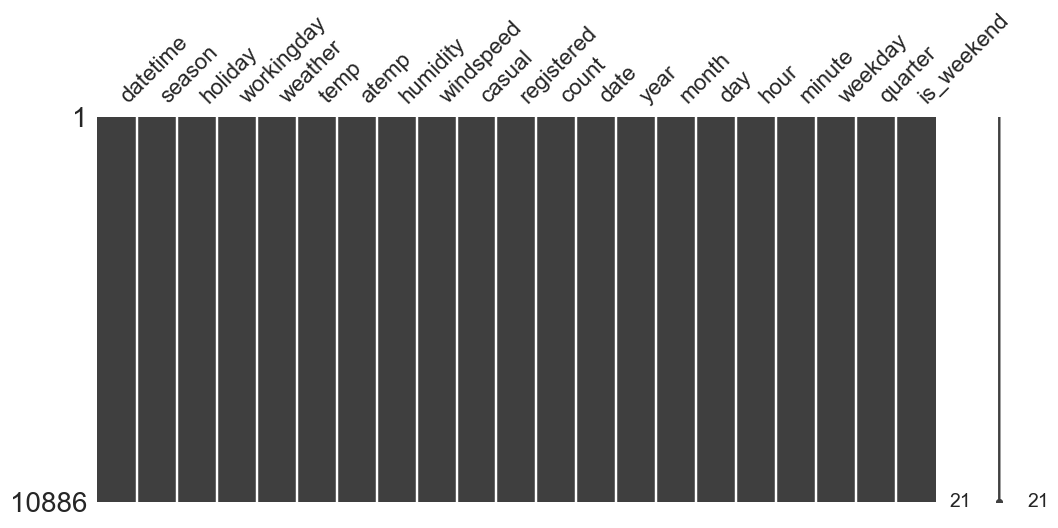

In [24]:
# 可视化缺失值
msno.matrix(train_data,figsize=(12,5))

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  object        
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  date        10886 non-null  datetime64[ns]
 13  year        10886 non-null  int32         
 14  month       10886 non-null  int32         
 15  day         10886 non-null  int32         
 16  hour        10886 non-

**使用随机森林模型预测风速中的0值**

d:\Development\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Development\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Development\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19982 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Development\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Development\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Development\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py

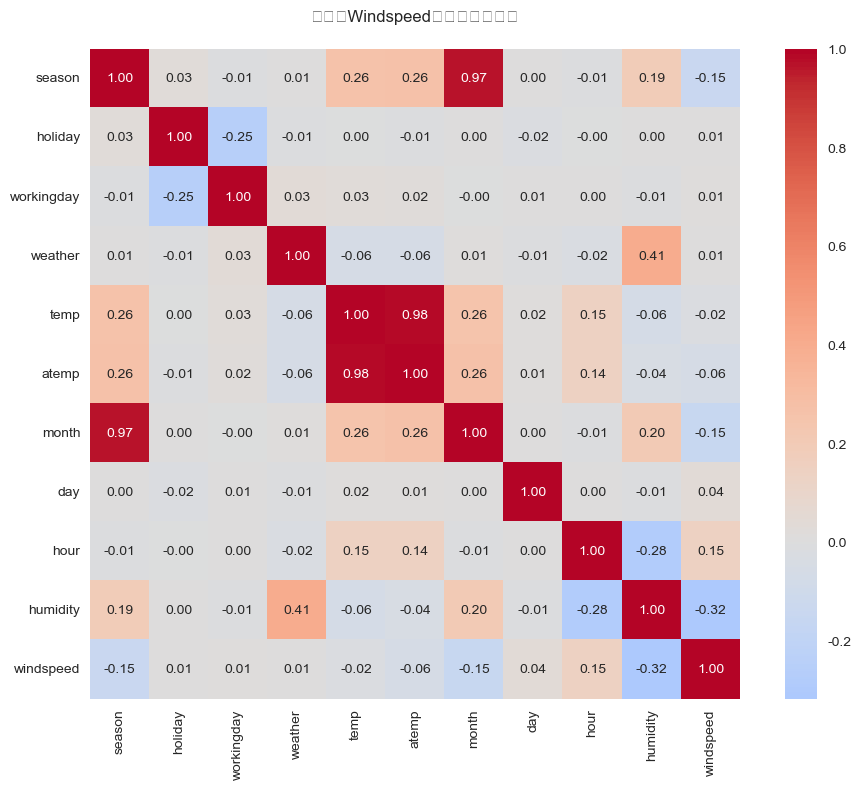


Windspeed相关性排序:
windspeed     1.000000
hour          0.146631
day           0.036157
workingday    0.013373
holiday       0.008409
weather       0.007261
temp         -0.017852
atemp        -0.057473
season       -0.147121
month        -0.150192
humidity     -0.318607
Name: windspeed, dtype: float64


In [26]:
def analyze_windspeed_correlations(data):
    """
    分析特征与windspeed的相关性并绘制热力图
    """
    # 选择需要分析的特征
    features = ['season', 'holiday', 'workingday', 'weather', 
                'temp', 'atemp','month','day', 'hour','humidity', 'windspeed']
    
    # 计算相关系数矩阵
    corr_matrix = data[features].corr()
    
    # 创建热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, 
                annot=True,  # 显示相关系数值
                fmt='.2f',   # 保留两位小数
                cmap='coolwarm',  # 使用蓝红配色
                center=0,    # 将相关系数0设为中心值
                square=True) # 保持方形
    
    plt.title('特征与Windspeed的相关性热力图', pad=20)
    plt.tight_layout()
    plt.show()
    
    # 打印与windspeed的相关性排序
    correlations = corr_matrix['windspeed'].sort_values(ascending=False)
    print("\nWindspeed相关性排序:")
    print(correlations)

# 调用函数
analyze_windspeed_correlations(train_data)

In [27]:
from sklearn.ensemble import RandomForestRegressor
def fill_missing_with_rf(data, target_columns, feature_columns=None, missing_value=np.NAN, random_state=42):
    """
    使用随机森林模型填充缺失值
    
    参数:
    - data: DataFrame, 输入数据
    - target_columns: str or list, 需要填充的目标列(可以是单个字符串或列表)
    - feature_columns: list or None, 用于预测的特征列。如果为None则自动选择数值列
    - missing_value: any, 需要填充的值(默认为0)可修改为np.nan # 有bug，缺失值类型无法与target_columns一一匹配
    - random_state: int, 随机种子(默认为42)
    
    返回:
    - DataFrame: 填充后的数据框
    """
    # 复制输入数据,避免修改原始数据
    df = data.copy()
    
    # 将target_columns转换为列表
    if isinstance(target_columns, str):
        target_columns = [target_columns]
        
    # 如果未指定特征列,自动选择数值列(排除目标列)
    if feature_columns is None:
        feature_columns = df.select_dtypes(include=['int64', 'float64']).columns
        feature_columns = [col for col in feature_columns if col not in target_columns]
        print(f"自动选择的特征列: {feature_columns}")
    
    # 对每个目标列进行填充
    for target_column in target_columns:
        print(f"\n开始处理列: {target_column}")
        
        # 检查目标列是否存在
        if target_column not in df.columns:
            print(f"警告: 列 {target_column} 不存在于数据中")
            continue
            
        # 将数据分为包含缺失值和不包含缺失值的两部分
        data_missing = df[df[target_column] == missing_value]
        data_not_missing = df[df[target_column] != missing_value]
        
        # 如果没有缺失值,跳过当前列
        if len(data_missing) == 0:
            print(f"列 {target_column} 中没有发现值为{missing_value}的记录,无需填充。")
            continue
            
        # 创建并训练随机森林模型
        rf_model = RandomForestRegressor(random_state=random_state)
        
        try:
            # 训练模型
            rf_model.fit(data_not_missing[feature_columns], 
                        data_not_missing[target_column])
            
            # 预测缺失值
            predicted_values = rf_model.predict(data_missing[feature_columns])
            
            # 将预测值填充到缺失值位置
            df.loc[df[target_column] == missing_value, target_column] = predicted_values
            
            print(f"列 {target_column} 已成功填充 {len(data_missing)} 条记录。")
            

            
        except Exception as e:
            print(f"错误: 处理列 {target_column} 时发生异常: {str(e)}")
            continue
    
    return df

# 使用示例:
# 1. 填充单个列的缺失值
train_data = fill_missing_with_rf(
    data=train_data,
    target_columns='windspeed',  # 单个列名
    feature_columns=['humidity','month','season', 'hour','weather',  'atemp'],
    missing_value=0,
    random_state=42
)




开始处理列: windspeed
列 windspeed 已成功填充 1313 条记录。


#### **异常值处理**

先用IQR检测特征列的异常值，发现humidity和windspeed含有异常值，对于异常值使用季节、温度、天气状况等进行回归插值预测填充。对于目标变量count使用基于模型的方法检测异常值，对异常值进行对数变换 (log transformation) 可以 平滑 count 的分布，减小高值异常值的杠杆效应，使模型更关注相对变化而非绝对变化。

##### IQR方法检测特征异常值


==================== IQR异常值检测报告 ====================

列名: season
Q1: 2.00
Q3: 4.00
IQR: 2.00
下界: -1.00
上界: 7.00
异常值数量: 0
异常值占比: 0.00%

列名: holiday
Q1: 0.00
Q3: 0.00
IQR: 0.00
下界: 0.00
上界: 0.00
异常值数量: 311
异常值占比: 2.86%

列名: workingday
Q1: 0.00
Q3: 1.00
IQR: 1.00
下界: -1.50
上界: 2.50
异常值数量: 0
异常值占比: 0.00%

列名: weather
Q1: 1.00
Q3: 2.00
IQR: 1.00
下界: -0.50
上界: 3.50
异常值数量: 1
异常值占比: 0.01%

列名: temp
Q1: 13.94
Q3: 26.24
IQR: 12.30
下界: -4.51
上界: 44.69
异常值数量: 0
异常值占比: 0.00%

列名: atemp
Q1: 16.66
Q3: 31.06
IQR: 14.39
下界: -4.93
上界: 52.65
异常值数量: 0
异常值占比: 0.00%

列名: humidity
Q1: 47.00
Q3: 77.00
IQR: 30.00
下界: 2.00
上界: 122.00
异常值数量: 22
异常值占比: 0.20%

列名: windspeed
Q1: 9.00
Q3: 19.00
IQR: 10.00
下界: -6.01
上界: 34.01
异常值数量: 147
异常值占比: 1.35%

列名: casual
Q1: 4.00
Q3: 49.00
IQR: 45.00
下界: -63.50
上界: 116.50
异常值数量: 749
异常值占比: 6.88%

列名: registered
Q1: 36.00
Q3: 222.00
IQR: 186.00
下界: -243.00
上界: 501.00
异常值数量: 423
异常值占比: 3.89%

列名: count
Q1: 42.00
Q3: 284.00
IQR: 242.00
下界: -321.00
上界: 647.00
异常值数量: 300
异常值占比: 2.

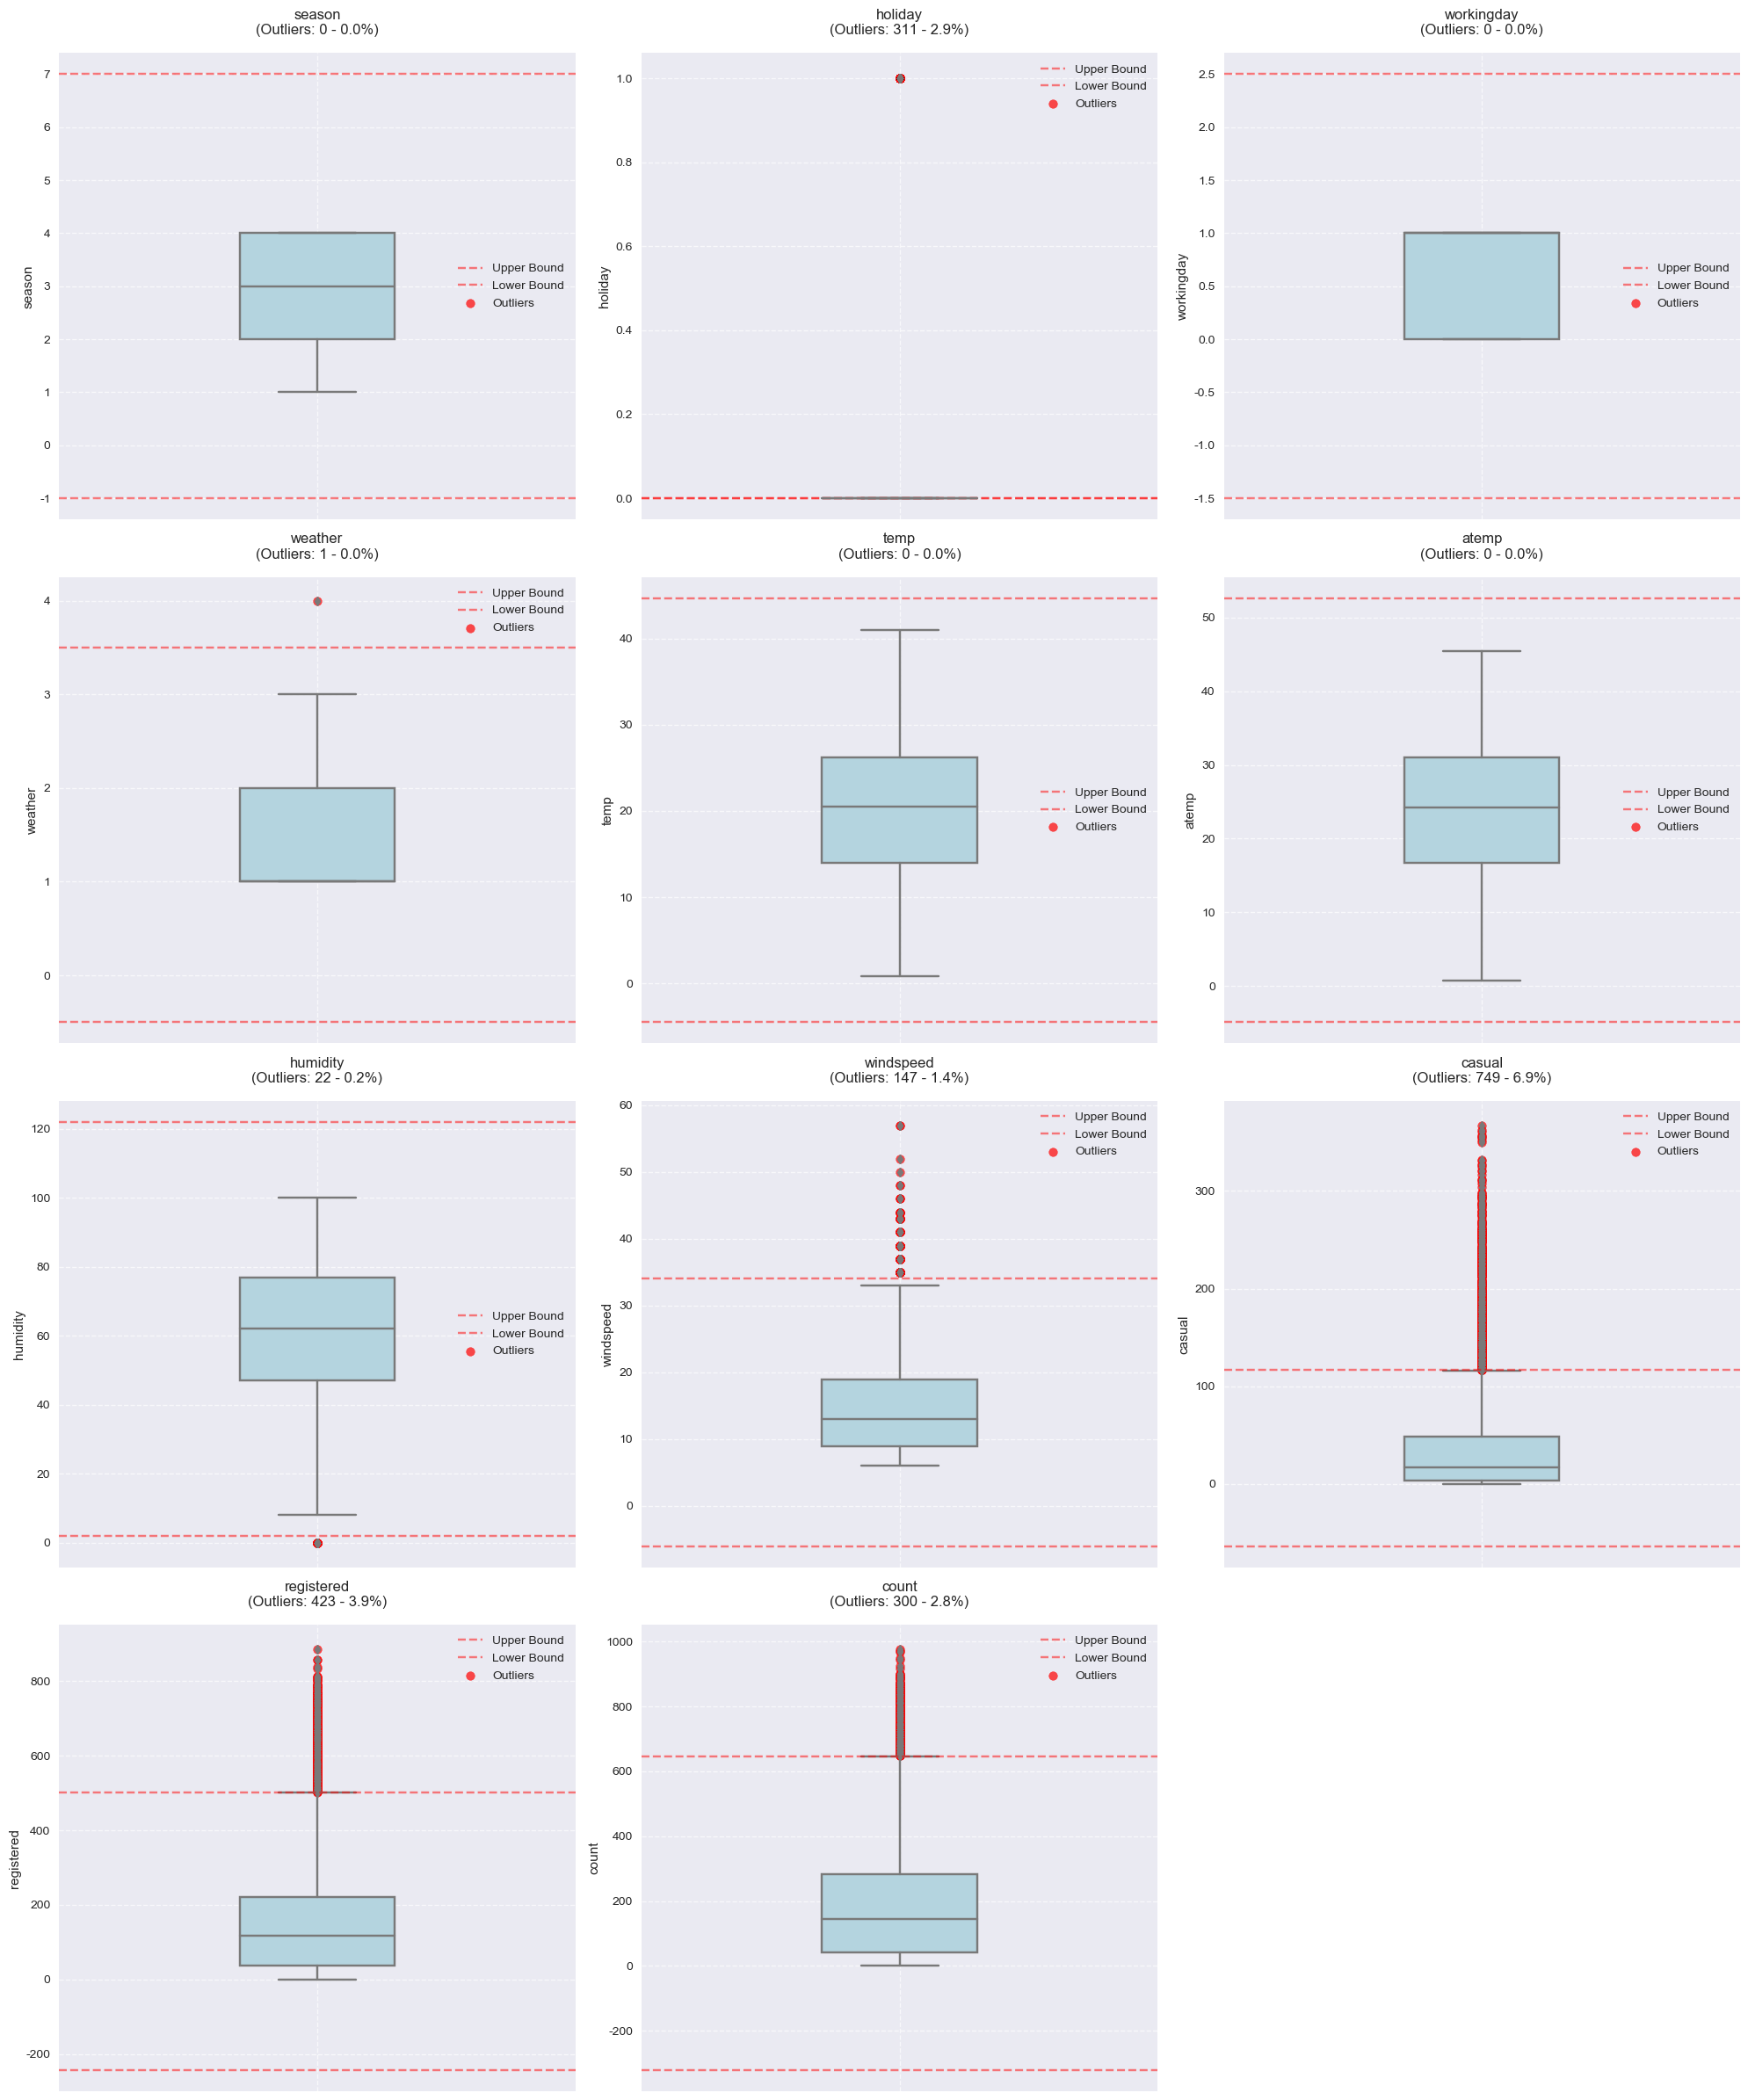

In [28]:
def plot_iqr_outliers_selected_columns(data, columns=None, threshold=1.5):
    """
    使用IQR方法检测并可视化指定列的异常值
    
    参数:
    - data: DataFrame, 输入数据
    - columns: list or None, 需要检测的列名列表。如果为None，则检测所有数值列
    - threshold: float, IQR的倍数阈值，默认为1.5
    
    返回:
    - outliers_summary: dict, 异常值检测结果摘要
    """
    # 如果未指定列，则获取所有数值型列
    if columns is None:
        columns = data.select_dtypes(include=['int64', 'float64']).columns
    else:
        # 验证指定的列是否存在于数据中
        for col in columns:
            if col not in data.columns:
                raise ValueError(f"列 '{col}' 不存在于数据中")
            # 验证指定的列是否为数值型
            if not np.issubdtype(data[col].dtype, np.number):
                raise ValueError(f"列 '{col}' 不是数值类型")
    
    # 计算每列的IQR统计量
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    IQR = Q3 - Q1
    
    # 计算异常值边界
    lower_bounds = Q1 - threshold * IQR
    upper_bounds = Q3 + threshold * IQR
    
    # 打印每列的异常值统计
    print(f"\n{'='*20} IQR异常值检测报告 {'='*20}")
    
    outliers_summary = {}
    for column in columns:
        # 标记异常值
        outliers = data[(data[column] < lower_bounds[column]) | 
                       (data[column] > upper_bounds[column])]
        
        outliers_count = len(outliers)
        outliers_percentage = (outliers_count/len(data))*100
        
        # 存储异常值的索引
        outliers_idx = outliers.index
        
        outliers_summary[column] = {
            'Q1': Q1[column],
            'Q3': Q3[column],
            'IQR': IQR[column],
            'lower_bound': lower_bounds[column],
            'upper_bound': upper_bounds[column],
            'outliers_count': outliers_count,
            'outliers_percentage': outliers_percentage,
            'outliers_index': outliers_idx,  # 添加异常值索引
            'outliers_values': data.loc[outliers_idx, column]  # 添加异常值
        }
        
        print(f"\n列名: {column}")
        print(f"Q1: {Q1[column]:.2f}")
        print(f"Q3: {Q3[column]:.2f}")
        print(f"IQR: {IQR[column]:.2f}")
        print(f"下界: {lower_bounds[column]:.2f}")
        print(f"上界: {upper_bounds[column]:.2f}")
        print(f"异常值数量: {outliers_count}")
        print(f"异常值占比: {outliers_percentage:.2f}%")
    
    # 可视化
    n_cols = min(3, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    plt.style.use('seaborn')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
    
    for idx, column in enumerate(columns):
        # 获取当前列的异常值
        outliers_idx = outliers_summary[column]['outliers_index']
        
        # 绘制箱线图
        sns.boxplot(data=data, y=column, ax=axes[idx], color='lightblue', width=0.3)
        
        # 添加异常值散点
        axes[idx].scatter(
            np.zeros(len(outliers_idx)), 
            data.loc[outliers_idx, column],
            c='red', alpha=0.7, label='Outliers'
        )
        
        # 添加边界线
        axes[idx].axhline(
            y=upper_bounds[column], 
            color='r', linestyle='--', 
            alpha=0.5, label='Upper Bound'
        )
        axes[idx].axhline(
            y=lower_bounds[column], 
            color='r', linestyle='--', 
            alpha=0.5, label='Lower Bound'
        )
        
        # 设置标题和标签
        axes[idx].set_title(
            f'{column}\n(Outliers: {outliers_summary[column]["outliers_count"]} - '
            f'{outliers_summary[column]["outliers_percentage"]:.1f}%)', 
            pad=15
        )
        axes[idx].legend()
        axes[idx].grid(True, linestyle='--', alpha=0.7)
    
    # 删除多余的子图
    for idx in range(len(columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return outliers_summary


# 使用示例
# 1. 检测所有数值列的异常值
outliers_summary_all = plot_iqr_outliers_selected_columns(train_data)

# 2. 检测指定列的异常值
# selected_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'count']
# outliers_summary_selected = plot_iqr_outliers_selected_columns(
#     data=train_data,
#     columns=selected_columns,
#     threshold=1.5
# )



In [29]:
import os
def get_column_outliers(outliers_summary, column_name, data, save_csv=True, output_dir='./outliers'):
    """
    获取指定列的异常值详情，并可选择保存完整样本数据为CSV文件
    
    参数:
    - outliers_summary: dict, 异常值检测结果字典
    - column_name: str, 列名
    - data: DataFrame, 原始数据集
    - save_csv: bool, 是否保存为CSV文件，默认为True
    - output_dir: str, CSV文件输出目录，默认为'./outliers'
    
    返回:
    - DataFrame: 包含异常值的完整样本数据
    """
    # 检查列名是否存在
    if column_name not in outliers_summary:
        raise ValueError(f"列 '{column_name}' 不在异常值检测结果中")
    
    # 获取异常值信息
    outliers_info = outliers_summary[column_name]
    
    # 打印异常值统计信息
    print(f"\n{'='*20} {column_name} 异常值详情 {'='*20}")
    print(f"异常值数量: {outliers_info['outliers_count']}")
    print(f"异常值占比: {outliers_info['outliers_percentage']:.2f}%")
    print(f"\n异常值分布:")
    print(f"最小值: {outliers_info['outliers_values'].min():.2f}")
    print(f"最大值: {outliers_info['outliers_values'].max():.2f}")
    print(f"均值: {outliers_info['outliers_values'].mean():.2f}")
    print(f"标准差: {outliers_info['outliers_values'].std():.2f}")
    
    # 获取包含异常值的完整样本数据
    outliers_data = data.loc[outliers_info['outliers_index']].copy()
    
    # 添加一列标记这是异常值
    outliers_data['is_outlier'] = True
    outliers_data['outlier_value'] = outliers_info['outliers_values']
    
    # 保存为CSV文件
    if save_csv:
        # 创建输出目录
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"\n创建输出目录: {output_dir}")
        
        # 生成文件名
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{column_name}_outliers_samples_{timestamp}.csv"
        filepath = os.path.join(output_dir, filename)
        
        # 保存CSV文件
        outliers_data.to_csv(filepath, index=True, encoding='utf-8')
        print(f"\n异常值完整样本数据已保存至: {filepath}")
    
    return outliers_data

# 使用示例
selected_columns_detail = ['humidity', 'windspeed']
for column in selected_columns_detail:
    print("\n")
    outliers_data = get_column_outliers(
        outliers_summary_all, # plot_iqr_outliers_selected_columns()函数返回结果
        column,
        data=train_data,  # 传入原始数据集
        save_csv=True,    # 保存为CSV
        output_dir='./outliers'  # 指定输出目录
    )
    print("\n异常值样本预览:")
    display(outliers_data.head())




==================== humidity 异常值详情 ====================
异常值数量: 22
异常值占比: 0.20%

异常值分布:
最小值: 0.00
最大值: 0.00
均值: 0.00
标准差: 0.00

异常值完整样本数据已保存至: ./outliers\humidity_outliers_samples_20250224_181014.csv

异常值样本预览:


datetime  season  holiday  workingday  weather   temp  \
1091  2011-03-10 00:00:00       1        0           1        3  13.94   
1092  2011-03-10 01:00:00       1        0           1        3  13.94   
1093  2011-03-10 02:00:00       1        0           1        3  13.94   
1094  2011-03-10 05:00:00       1        0           1        3  14.76   
1095  2011-03-10 06:00:00       1        0           1        3  14.76   

       atemp  humidity  windspeed  casual  ...  year  month day  hour  minute  \
1091  15.910         0    16.9979       3  ...  2011      3  10     0       0   
1092  15.910         0    16.9979       0  ...  2011      3  10     1       0   
1093  15.910         0    16.9979       0  ...  2011      3  10     2       0   
1094  17.425         0    12.9980       1  ...  2011      3  10     5       0   
1095  16.665         0    22.0028       0  ...  2011      3  10     6       0   

      weekday  quarter  is_weekend  is_outlier  outlier_value  
1091        3        1           0        True              0  
1092        3        1           0        True              0  
1093        3        1           0        True              0  
1094        3        1           0        True              0  
1095        3        1           0        True              0  

[5 rows x 23 columns]




==================== windspeed 异常值详情 ====================
异常值数量: 147
异常值占比: 1.35%

异常值分布:
最小值: 35.00
最大值: 57.00
均值: 38.54
标准差: 4.27

异常值完整样本数据已保存至: ./outliers\windspeed_outliers_samples_20250224_181015.csv

异常值样本预览:


datetime  season  holiday  workingday  weather  temp  atemp  \
178  2011-01-08 17:00:00       1        0           0        1  6.56  6.060   
194  2011-01-09 09:00:00       1        0           0        1  4.92  3.790   
196  2011-01-09 11:00:00       1        0           0        1  6.56  6.060   
265  2011-01-12 12:00:00       1        0           1        1  8.20  7.575   
271  2011-01-12 18:00:00       1        0           1        1  8.20  7.575   

     humidity  windspeed  casual  ...  year  month day  hour  minute  weekday  \
178        37    36.9974       5  ...  2011      1   8    17       0        5   
194        46    35.0008       0  ...  2011      1   9     9       0        6   
196        40    35.0008       2  ...  2011      1   9    11       0        6   
265        47    39.0007       3  ...  2011      1  12    12       0        2   
271        47    35.0008       2  ...  2011      1  12    18       0        2   

     quarter  is_weekend  is_outlier  outlier_value  
178        1           1        True        36.9974  
194        1           1        True        35.0008  
196        1           1        True        35.0008  
265        1           0        True        39.0007  
271        1           0        True        35.0008  

[5 rows x 23 columns]

##### 基于模型检测目标变量异常值

**代码整体思路：**

通过计算模型预测值和真实y值之间的残差，并利用残差的均值和标准差来计算z值。然后，根据设定的sigma阈值，将绝对值大于sigma的z值作为异常值进行检测和标记。最后，通过打印输出和可视化子图展示异常值的相关信息。目的是识别和理解模型中的异常值，以便进一步进行数据处理或模型调整。


==================== 异常值检测报告 ====================

1. 模型性能指标:
R² score: 0.9920
RMSE: 16.2065
MSE: 262.6518

2. 残差统计信息:
残差均值: -0.5107
残差标准差: 16.1992

3. 异常值统计:
检测到的异常值数量: 213
异常值占比: 1.96%


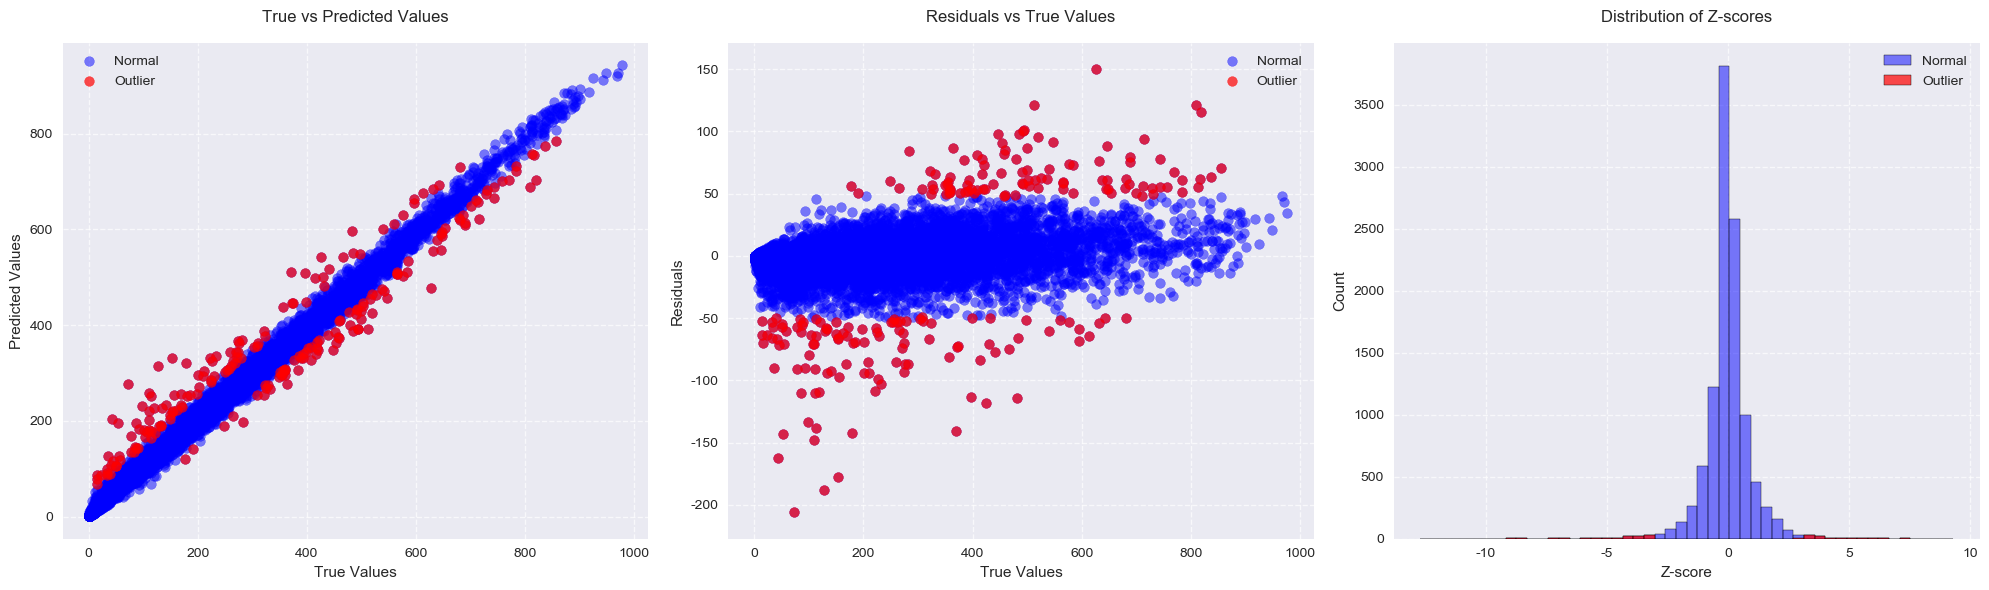

In [30]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    """均方根误差"""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def find_outliers(model, data, feature_columns, target='count', sigma=3):
    """
    检测数据集中的异常值。
    
    参数:
    - model: 用于预测的模型对象
    - data: DataFrame, 包含特征和目标变量的数据集
    - feature_columns: list, 用于预测的特征列名列表
    - target: str, 目标变量列名，默认为'count'
    - sigma: float, 标准差倍数阈值，默认为3
    
    返回:
    - outliers: 异常值的索引
    """
    # 准备数据
    X = data[feature_columns]
    y = data[target]
    
    # 使用模型预测y值
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # 计算残差统计量
    resid = y - y_pred     
    mean_resid = resid.mean()  
    std_resid = resid.std()    

    # 计算z统计量，标记异常值
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z) > sigma].index
    
    # 打印分析结果
    print(f"\n{'='*20} 异常值检测报告 {'='*20}")

    # 1. 模型性能指标
    print("\n1. 模型性能指标:")
    print(f"R² score: {model.score(X,y):.4f}")
    print(f"RMSE: {rmse(y, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y,y_pred):.4f}")
    
    # 2. 残差统计信息
    print("\n2. 残差统计信息:")
    print(f"残差均值: {mean_resid:.4f}")
    print(f"残差标准差: {std_resid:.4f}")
    
    # 3. 异常值统计
    print("\n3. 异常值统计:")
    print(f"检测到的异常值数量: {len(outliers)}")
    print(f"异常值占比: {(len(outliers)/len(data))*100:.2f}%")
    
    # 4. 可视化分析
    plt.style.use('seaborn')
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 4.1 真实值vs预测值的散点图
    axes[0].scatter(y, y_pred, c='blue', alpha=0.5, label='Normal')
    axes[0].scatter(y.loc[outliers], y_pred.loc[outliers], 
                   c='red', alpha=0.7, label='Outlier')
    axes[0].set_title('True vs Predicted Values', pad=15)
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # 4.2 真实值vs残差的散点图
    axes[1].scatter(y, y-y_pred, c='blue', alpha=0.5, label='Normal')
    axes[1].scatter(y.loc[outliers], y.loc[outliers]-y_pred.loc[outliers], 
                   c='red', alpha=0.7, label='Outlier')
    axes[1].set_title('Residuals vs True Values', pad=15)
    axes[1].set_xlabel('True Values')
    axes[1].set_ylabel('Residuals')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # 4.3 z统计量的直方图
    sns.histplot(z, bins=50, ax=axes[2], color='blue', 
                alpha=0.5, label='Normal')
    sns.histplot(z[outliers], bins=50, ax=axes[2], 
                color='red', alpha=0.7, label='Outlier')
    axes[2].set_title('Distribution of Z-scores', pad=15)
    axes[2].set_xlabel('Z-score')
    axes[2].set_ylabel('Count')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    #plt.savefig('outliers_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return outliers

# 使用示例
# 定义特征列
feature_columns = [
    'season', 'weather', 'temp', 'atemp', 
    'humidity', 'windspeed', 'year', 'month', 
    'hour', 'weekday'
]

# 使用随机森林模型检测异常值
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
outliers = find_outliers(
    model=rf_model,
    data=train_data,
    feature_columns=feature_columns,
    target='count',
    sigma=3
)

#train_data_outliers=train_data.loc[outliers]


In [31]:
train_data.loc[outliers]

datetime  season  holiday  workingday  weather   temp  \
380    2011-01-17 08:00:00       1        1           0        2   6.56   
1699   2011-04-16 17:00:00       2        0           0        3  20.50   
1802   2011-05-02 00:00:00       2        0           1        1  18.86   
2035   2011-05-11 17:00:00       2        0           1        1  26.24   
2036   2011-05-11 18:00:00       2        0           1        1  25.42   
...                    ...     ...      ...         ...      ...    ...   
10271  2012-11-13 09:00:00       4        0           1        3  13.12   
10466  2012-12-02 12:00:00       4        0           0        2  13.94   
10486  2012-12-03 08:00:00       4        0           1        1  14.76   
10533  2012-12-05 07:00:00       4        0           1        3  18.86   
10582  2012-12-07 08:00:00       4        0           1        2  12.30   

        atemp  humidity  windspeed  casual  ...  count       date  year  \
380     7.575        47  15.001300       3  ...     33 2011-01-17  2011   
1699   24.240        88  39.000700       1  ...     15 2011-04-16  2011   
1802   22.725        72   8.998100      68  ...    177 2011-05-02  2011   
2035   31.060        47   7.001500      17  ...    259 2011-05-11  2011   
2036   31.060        50  19.999500      40  ...    274 2011-05-11  2011   
...       ...       ...        ...     ...  ...    ...        ...   ...   
10271  15.150        81  22.002800       1  ...    110 2012-11-13  2012   
10466  16.665        81  11.001400     111  ...    520 2012-12-02  2012   
10486  18.940        93   7.776656      19  ...    731 2012-12-03  2012   
10533  22.725        59  19.999500       9  ...    398 2012-12-05  2012   
10582  14.395        75  12.998000      11  ...    441 2012-12-07  2012   

       month  day  hour  minute  weekday  quarter  is_weekend  
380        1   17     8       0        0        1           0  
1699       4   16    17       0        5        2           1  
1802       5    2     0       0        0        2           0  
2035       5   11    17       0        2        2           0  
2036       5   11    18       0        2        2           0  
...      ...  ...   ...     ...      ...      ...         ...  
10271     11   13     9       0        1        4           0  
10466     12    2    12       0        6        4           1  
10486     12    3     8       0        0        4           0  
10533     12    5     7       0        2        4           0  
10582     12    7     8       0        4        4           0  

[213 rows x 21 columns]

##### IQR与模型方法对比分析


==================== 异常值检测报告 ====================

1. 模型性能指标:
R² score: 0.9188
RMSE: 1.9433
MSE: 3.7765

2. 残差统计信息:
残差均值: -0.0311
残差标准差: 1.9432

3. 异常值统计:
检测到的异常值数量: 204
异常值占比: 1.87%


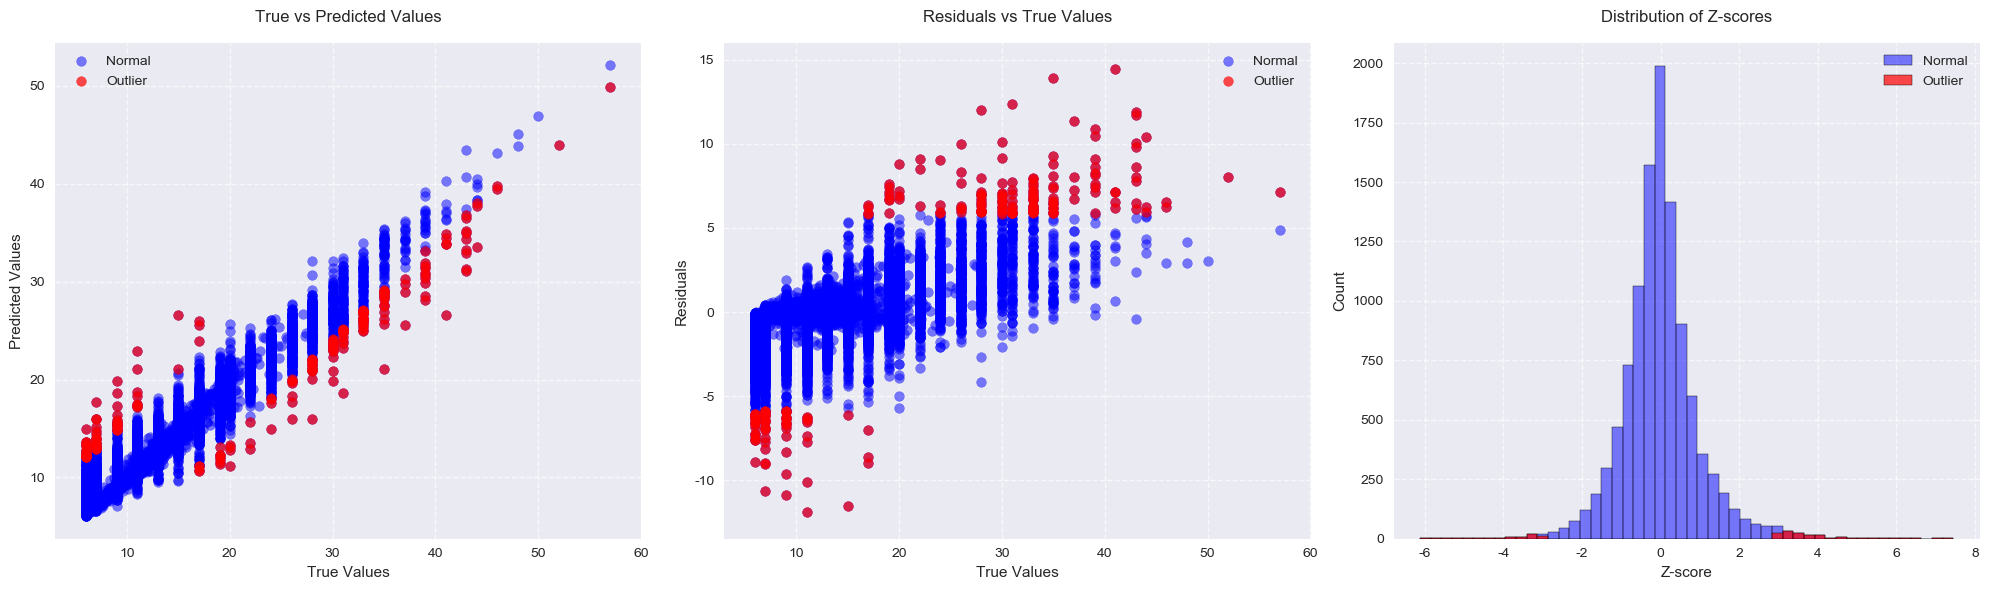


比较结果:
IQR方法检测到的异常值数量: 147
模型方法检测到的异常值数量: 204
两种方法共同检测到的异常值数量: 50


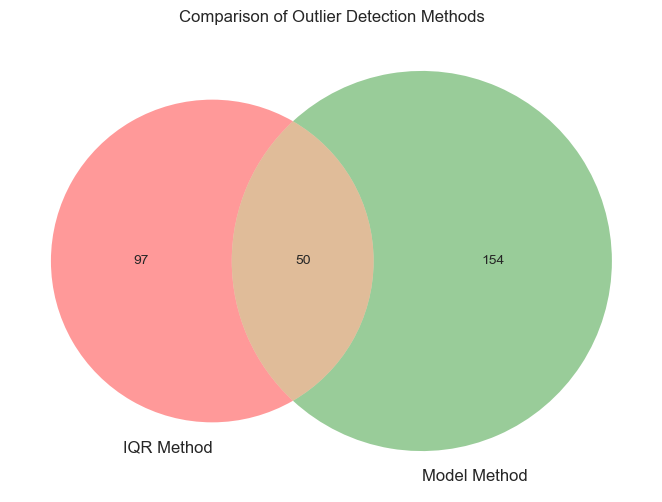

In [32]:
from matplotlib_venn import venn2
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
def compare_outlier_methods(data, feature_columns, target='count', 
                          iqr_threshold=1.5, model_sigma=3):
    """
    比较IQR方法和基于模型的异常值检测方法
    
    参数:
    - data: DataFrame, 输入数据
    - feature_columns: list, 用于检测target变量的特征
    - target: str, 待检测变量列名
    - iqr_threshold: float, IQR方法的阈值
    - model_sigma: float, 模型方法的sigma阈值
    """
    # 1. IQR方法检测
    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = data[
        (data[target] < Q1 - iqr_threshold * IQR) | 
        (data[target] > Q3 + iqr_threshold * IQR)
    ].index
    
    # 2. 模型方法检测
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    model_outliers = find_outliers(
        model=rf_model,
        data=data,
        feature_columns=feature_columns,
        target=target,
        sigma=model_sigma
    )
    
    # 3. 比较结果
    print("\n比较结果:")
    print(f"IQR方法检测到的异常值数量: {len(iqr_outliers)}")
    print(f"模型方法检测到的异常值数量: {len(model_outliers)}")
    
    # 计算重叠部分
    common_outliers = set(iqr_outliers) & set(model_outliers)
    print(f"两种方法共同检测到的异常值数量: {len(common_outliers)}")
    
    # 可视化比较
    plt.figure(figsize=(12, 6))
    venn2([set(iqr_outliers), set(model_outliers)], 
          set_labels=('IQR Method', 'Model Method'))
    plt.title('Comparison of Outlier Detection Methods')
    plt.show()
    
    return {
        'iqr_outliers': iqr_outliers,
        'model_outliers': model_outliers,
        'common_outliers': common_outliers
    }

# 使用示例
feature_columns = [
    'season', 'weather', 'temp', 'atemp', 
    'humidity', 'year', 'month', 
    'hour'
]
comparison_results = compare_outlier_methods(
    data=train_data,
    feature_columns=feature_columns,
    target='windspeed',
    iqr_threshold=1.5,
    model_sigma=3
)


```


{
    "IQR方法": {
        "优点": [
            "无需模型训练，计算简单快速",
            "基于数据分布特征，不受模型影响",
            "适用于单变量分析",
            "容易理解和解释",
            "对数据分布假设较少"
        ],
        "缺点": [
            "无法考虑特征之间的关系",
            "可能忽略多维数据中的复杂异常模式",
            "对多变量异常值检测效果不佳",
            "固定的阈值(1.5*IQR)可能不适合所有场景"
        ],
        "适用场景": [
            "数据预处理初期的快速异常检测",
            "单变量异常值分析",
            "数据分布较为对称的情况",
            "需要快速获得数据质量概览"
        ]
    },
    
    "基于模型的方法(find_outliers)": {
        "优点": [
            "考虑了特征间的相互关系",
            "可以发现复杂的异常模式",
            "基于预测残差，更符合业务逻辑",
            "可以根据模型预测效果动态调整",
            "适合处理多维特征的异常值"
        ],
        "缺点": [
            "需要训练模型，计算成本较高",
            "依赖模型的质量和选择",
            "可能受到模型过拟合的影响",
            "参数调整较为复杂"
        ],
        "适用场景": [
            "多变量异常值检测",
            "需要考虑特征关联性的场景",
            "有明确的预测目标",
            "数据量较大且特征较多的情况"
        ]
    }
}
```

建议:

1.  对于自行车租赁需求预测这个场景,我建议使用基
于模型的方法(find_outliers),原因是:
    *   需求预测涉及多个特征的交互作用
    *   异常值可能与多个因素相关(如天气、温度、时间等)
    *   预测目标明确,适合使用模型方法
    *   数据量较大,特征较多

2.  最佳实践:

    *   可以先用IQR方法进行初步筛查
    *   再使用模型方法进行深入分析
    *   重点关注两种方法都检测出的异常值
    *   结合业务逻辑判断是否需要处理这些异常值

3.  处理建议:

    *   对于共同检测出的异常值,优先考虑处理

    *   仅被单个方法检测出的异常值需要进一步分析

    *   结合业务场景判断是否为真实异常

    *   可以考虑对异常值进行分类处理而不是简单删除

4. 参数调整:

- IQR方法的threshold可以根据数据分布调整(1.5是常用值)

- 模型方法的sigma可以根据业务容忍度调整(3是常用值)

- 可以尝试不同的参数组合找到最适合的阈值

-------------

主要区别:

1. IQR方法（plot_iqr_outliers_all_columns）：

  *   检测所有数值列的异常值

  *   基于每列自身的分布特征（Q1, Q3, IQR）

  *   不考虑特征之间的关系

  *   适合单变量分析

2. 基于模型的方法（find_outliers）：

  *   只检测目标变量 'count' 的异常值

  *   基于所有特征列预测 'count' 的结果

  *   考虑了特征与目标变量之间的关系

  *   适合多变量分析

这个改进版本的主要特点：

1. 迭代处理：

   * 每轮迭代先处理特征列的异常值
   * 再检测目标变量的异常值
   * 合并两种方法检测到的异常值
2. 双重检测：

   * 使用IQR方法检测特征列异常值
   * 使用基于模型的方法检测目标变量异常值
3. 异常值处理：

   * 使用中位数替换检测到的异常值
   * 下一轮迭代使用处理后的数据继续检测
4. 终止条件：

   * 达到最大迭代次数
   * 或没有检测到新的异常值
5. 结果可视化：
   
   * 展示每轮迭代检测到的异常值数量
   * 帮助理解异常值检测的收敛过程
   
这种方法的优势：

1. 更全面：同时考虑特征列和目标变量的异常值
2. 更稳健：通过迭代方式逐步处理异常值
3. 更可靠：结合多种检测方法，互相验证
4. 可追踪：记录每轮迭代的检测结果

使用建议：

1. 根据数据特点调整 $sigma$ 和 $max\_iterations$ 参数
2. 观察迭代过程中异常值数量的变化
3. 结合业务逻辑判断是否需要处理所有检测到的异常值
4. 可以尝试不同的异常值替换方法（如均值、插值等）

##### 异常值处理策略
outlier_handling_methods = {
    "1. 保留异常值": {
        "方法描述": [
            "不对异常值进行处理",
            "保持数据的原始分布",
            "适用于异常值包含重要信息的场景"
        ],
        "优点": [
            "保持数据的真实性",
            "不损失信息",
            "适合非参数模型"
        ],
        "缺点": [
            "可能影响模型训练",
            "可能降低预测准确性",
            "可能导致模型偏差"
        ],
        "适用性评分": "中等",
        "适用场景": [
            "使用树模型等对异常值不敏感的模型",
            "异常值代表真实的业务场景",
            "数据量较大时"
        ]
    },
    
    "2. 删除异常值": {
        "方法描述": [
            "直接删除被识别为异常的样本",
            "清理数据集",
            "适用于异常值明显错误的场景"
        ],
        "优点": [
            "处理方法简单直接",
            "可以提高数据质量",
            "减少噪声影响"
        ],
        "缺点": [
            "可能丢失有用信息",
            "减少样本量",
            "可能引入选择偏差"
        ],
        "适用性评分": "低",
        "适用场景": [
            "异常值明显是错误数据",
            "样本量充足",
            "异常值比例较小"
        ]
    },
    
    "3. 替换异常值": {
        "统计替换": {
            "方法描述": [
                "使用统计量替换异常值",
                "常用统计量：均值、中位数、众数",
                "可以按分组进行替换"
            ],
            "优点": [
                "实现简单",
                "保持数据量",
                "不改变整体分布"
            ],
            "缺点": [
                "可能降低数据方差",
                "可能忽略特征关系",
                "替换值可能不符合实际"
            ],
            "适用性评分": "中等",
            "适用场景": [
                "异常值分布较随机",
                "特征间相关性不强",
                "需要快速处理"
            ]
        },
        
        "插值替换": {
            "方法描述": [
                "使用相邻值进行插值",
                "可以是线性插值或更复杂的插值方法",
                "考虑数据的时间序列特性"
            ],
            "优点": [
                "保持数据的连续性",
                "考虑时间序列特征",
                "更符合实际变化"
            ],
            "缺点": [
                "计算复杂度较高",
                "需要合适的时间窗口",
                "可能受噪声影响"
            ],
            "适用性评分": "高",
            "适用场景": [
                "时间序列数据",
                "数据具有连续性",
                "异常值周围有可靠数据"
            ]
        },
        
        "模型预测替换": {
            "方法描述": [
                "使用模型预测值替换异常值",
                "可以考虑多个特征的关系",
                "适合复杂的数据关系"
            ],
            "优点": [
                "考虑特征间关系",
                "预测值更准确",
                "适应性强"
            ],
            "缺点": [
                "计算成本高",
                "依赖模型质量",
                "可能过度平滑"
            ],
            "适用性评分": "高",
            "适用场景": [
                "特征间有强相关性",
                "有足够训练数据",
                "需要高精度替换"
            ]
        }
    },
    
    "4. 分箱处理": {
        "方法描述": [
            "将异常值映射到合适的分箱中",
            "可以是等宽分箱或等频分箱",
            "处理极端值"
        ],
        "优点": [
            "保持数据的相对关系",
            "减少极端值影响",
            "便于特征工程"
        ],
        "缺点": [
            "损失精确信息",
            "需要合理的分箱策略",
            "可能影响预测精度"
        ],
        "适用性评分": "中等",
        "适用场景": [
            "处理极端值",
            "特征工程需要",
            "类别化处理"
        ]
    }
}

针对自行车租赁需求预测项目的建议处理方案：
    "主要处理方法": "组合策略",
    "具体步骤": [
        {
            "步骤1": "时间序列特征异常值处理",
            "方法": "插值替换",
            "原因": [
                "租赁需求具有时间连续性",
                "可以利用相邻时间点的信息",
                "保持数据的时序特性"
            ]
        },
        {
            "步骤2": "天气相关特征异常值处理",
            "方法": "模型预测替换",
            "原因": [
                "天气特征间存在相关性",
                "可以利用多个特征的关系",
                "提高替换值的准确性"
            ]
        },
        {
            "步骤3": "极端需求值处理",
            "方法": "条件替换",
            "原因": [
                "考虑特殊事件（节假日、活动等）",
                "保留合理的高需求值",
                "替换明显错误的异常值"
            ]
        }
    ],


### 数据集成

### 数据重采样

### 数据变换- 连续变量离散化 (分箱)

### 数据变换- 长尾分布处理

长尾分布更多出现在以下两类场景中：

1. 多类别场景的类别分布：
在多分类任务或推荐系统、自然语言处理等场景下，可能发生极少数类别（或词汇、商品）出现频率远高于其余多数类别的现象。此时如果画出类别的频次直方图，会发现前几个“头部类别”占据了数据集绝大部分样本，而后续大量“尾部类别”则频次极低，但数目繁多，这种现象常被称为“长尾分布”或“帕累托分布”。

2. 某一离散特征的取值分布：
如果数据集中某个离散或类别型特征具有数百乃至上千种取值，并且取值频次分布极其不平衡（少数取值出现次数非常多，绝大多数取值仅出现极少量样本），这同样是长尾分布。典型例子包括：
词频统计：少数“高频词”占据文本大部分词汇量，而大部分“低频词”仅出现很少次数；
产品销量：少数“热销商品”卖得很好，而众多“冷门商品”销量极低。

**偏度调整**

> 根据直方图和Q-Q图考虑是否对数据进行变换，使之符合正态分布

Box-Cox变换
由于线性回归是基于正态分布的，因此在进行统计分析时，需要转换数据使其符合正态分布。

Box-Cox 变换是一种常见的数据转换技术，用于将非正态分布的数据**转换为近似正态分布**的数据。这一变换可以使线性回归模型在满足线性、正态性、独立性及方差齐性的同时，又不丢失信息。在对数据做Box-Cox变换之后，可以在一定程度上减小不可观测的误差和预测变量的相关性，这有**利于线性模型的拟合及分析出特征的相关性**。

**先归一化还是先转换？**

在做Box-Cox变换之前，需要对数据做归一化预处理。在归一化时，对数据进行合并操作可以使训练数据和测试数据一致。这种方式可以在线下分析建模中使用，而线上部署只需采用训练数据的归一化即可。

1.一般情况下，先Box-Cox后归一化

2.有负值时，考虑先归一化后Box-Cox

3.还原时顺序要与转换顺序相反

4.建议先检查数据特征再决定处理顺序

5.保持转换顶序的一致性和可追踪性

**对特征变量进行转换吗？**

是否需要对特征变量和目标变量都进行转换，取决于数据的分布、模型的要求以及你希望达成的目标。通常情况下，对目标变量进行转换更为常见，因为这有助于满足许多统计模型的假设。但是，在某些情况下，对特征变量进行转换也是有益的。最佳做法是尝试不同的转换方法，并根据模型的性能进行选择。 

Box-Cox转换 = {
    "适用场景": [
        "数据明显右偏",
        "需要满足线性模型假设",
        "方差不稳定"
    ],
    "不适用场景": [
        "分类变量",
        "已经接近正态分布",
        "有明确的物理意义需要保持"
    ],
    "注意事项": [
        "转换可能影响解释性",
        "需要考虑逆转换的需求",
        "注意保存转换参数"
    ]
}

In [33]:
class BoxCoxPipeline:
    """
    Box-Cox转换通用流程
    支持:
    1. 同时转换特征列和目标变量列
    2. 对测试集进行相同的转换
    3. 智能处理测试集中不存在的目标变量列

    1. 支持同时转换特征列和目标变量:
    * 通过`columns`参数指定特征列
    * 通过`target_col`参数指定目标变量
    * 内部分别存储特征列和目标变量信息

2. 测试集转换:
    * `transform`方法会自动检查哪些列存在于测试集中
    * 只对存在的列进行转换
    * 提供警告信息说明转换了哪些列

3. 处理测试集中不存在的目标变量列:
    * `transform`方法会跳过不存在的列
    * `inverse_transform`方法默认还原目标变量
    * 可以通过`columns`参数指定要还原的列
    """
    def __init__(self, visualization=False):
        self.lambda_params = {}  # 存储lambda参数
        self.shifts = {}        # 存储偏移量
        self.visualization = visualization
        self.transformed_columns = None  # 所有需要转换的列
        self.feature_columns = None     # 特征列
        self.target_column = None       # 目标变量列
    
    def _get_numeric_columns(self, data):
        """获取数值型列名"""
        return data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    def _handle_non_positive(self, x):
        """处理非正值"""
        min_val = x.min()
        if min_val <= 0:
            shift = abs(min_val) + 1
            return x + shift, shift
        return x, 0
    
    def _plot_transformation(self, original, transformed, col_name):
        """可视化转换效果"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f'Box-Cox Transformation for {col_name}')
        
        # 原始数据分布
        sns.histplot(original, ax=axes[0,0], kde=True)
        axes[0,0].set_title('Original Distribution')
        
        stats.probplot(original, plot=axes[0,1])
        axes[0,1].set_title(f'Original Q-Q Plot\nskew={stats.skew(original):.4f}')
        
        # 转换后数据分布
        sns.histplot(transformed, ax=axes[1,0], kde=True)
        axes[1,0].set_title('Transformed Distribution')
        
        stats.probplot(transformed, plot=axes[1,1])
        axes[1,1].set_title(f'Transformed Q-Q Plot\nskew={stats.skew(transformed):.4f}')
        
        plt.tight_layout()
        plt.show()
    
    def fit_transform(self, data, columns=None, target_col=None):
        """
        拟合并转换数据
        
        参数:
        - data: DataFrame, 输入数据
        - columns: list or str, 需要转换的特征列名列表或单个列名
        - target_col: str, 目标变量列名
        
        返回:
        - DataFrame: 转换后的数据
        """
        result = data.copy()
        
        # 1. 确定需要转换的列
        feature_cols = []
        if columns is not None:
            feature_cols = [columns] if isinstance(columns, str) else list(columns)
            
        # 验证列名
        all_cols = feature_cols + ([target_col] if target_col else [])
        for col in all_cols:
            if col not in data.columns:
                raise ValueError(f"列 {col} 不存在于数据中")
            if col not in self._get_numeric_columns(data):
                raise ValueError(f"列 {col} 不是数值型")
        
        # 保存转换信息
        self.feature_columns = feature_cols
        self.target_column = target_col
        self.transformed_columns = all_cols
        
        print(f"将进行以下转换:")
        if feature_cols:
            print(f"- 特征列: {feature_cols}")
        if target_col:
            print(f"- 目标变量: {target_col}")
        
        # 2. 执行转换
        for col in self.transformed_columns:
            try:
                # 处理非正值
                x, shift = self._handle_non_positive(data[col].values)
                self.shifts[col] = shift
                
                # 应用Box-Cox转换
                transformed_x, lambda_param = stats.boxcox(x)
                self.lambda_params[col] = lambda_param
                
                print(f"\n列 {col} 转换结果:")
                print(f"- Lambda参数: {lambda_param:.4f}")
                print(f"- 偏移量: {shift}")
                print(f"- 偏度变化: {stats.skew(data[col]):.4f} -> {stats.skew(transformed_x):.4f}")
                
                # 可视化
                if self.visualization:
                    self._plot_transformation(data[col].values, transformed_x, col)
                
                result[col] = transformed_x
                
            except Exception as e:
                print(f"警告: 列 {col} 转换失败: {str(e)}")
                continue
                
        return result
    
    def transform(self, data):
        """
        使用已有参数转换新数据
        
        参数:
        - data: DataFrame, 需要转换的数据
        
        返回:
        - DataFrame: 转换后的数据
        """
        if not self.lambda_params:
            raise ValueError("请先调用fit_transform")
            
        result = data.copy()
        
        # 只转换在数据中存在的列
        columns_to_transform = [col for col in self.transformed_columns 
                              if col in data.columns]
        
        if not columns_to_transform:
            print("警告: 没有需要转换的列")
            return result
            
        print(f"对以下列进行转换: {columns_to_transform}")
        
        for col in columns_to_transform:
            # 应用偏移和转换
            x = data[col].values + self.shifts[col]
            lambda_param = self.lambda_params[col]
            
            if lambda_param == 0:
                result[col] = np.log(x)
            else:
                result[col] = (np.power(x, lambda_param) - 1) / lambda_param
                
        return result
    
    def inverse_transform(self, data, columns=None):
        """
        逆转换回原始尺度
        
        参数:
        - data: DataFrame或array-like, 需要还原的数据
        - columns: list or str, 需要还原的列名(如果data是DataFrame)
                  如果data是array-like且未指定columns，默认还原目标变量
        
        返回:
        - DataFrame或array: 还原后的数据
        """
        if not self.lambda_params:
            raise ValueError("请先调用fit_transform")
            
        # 处理单列数组数据
        if isinstance(data, (pd.Series, list, np.ndarray)):
            if columns is None:
                # 如果未指定列名，默认还原目标变量
                if self.target_column:
                    col = self.target_column
                elif len(self.transformed_columns) == 1:
                    col = self.transformed_columns[0]
                else:
                    raise ValueError("无法确定要还原的列,请指定columns参数")
            else:
                col = columns[0] if isinstance(columns, list) else columns
                
            x = np.array(data)
            # 执行逆变换
            if self.lambda_params[col] == 0:
                restored = np.exp(x)
            else:
                restored = np.power(self.lambda_params[col] * x + 1, 
                                  1/self.lambda_params[col])
            # 还原偏移并处理负值    
            restored = np.maximum(restored - self.shifts[col], 0)
            return restored
                
        # DataFrame的情况
        result = data.copy()
        columns_to_restore = columns or self.transformed_columns
        
        for col in columns_to_restore:
            if col not in self.lambda_params or col not in data.columns:
                continue
                
            x = data[col].values
            lambda_param = self.lambda_params[col]
            
            if lambda_param == 0:
                result[col] = np.exp(x)
            else:
                result[col] = np.power(lambda_param * x + 1, 1/lambda_param)
                
            result[col] = np.maximum(result[col] - self.shifts[col], 0)
                
        return result

将进行以下转换:
- 目标变量: count

列 count 转换结果:
- Lambda参数: 0.3157
- 偏移量: 0
- 偏度变化: 1.2419 -> -0.1539


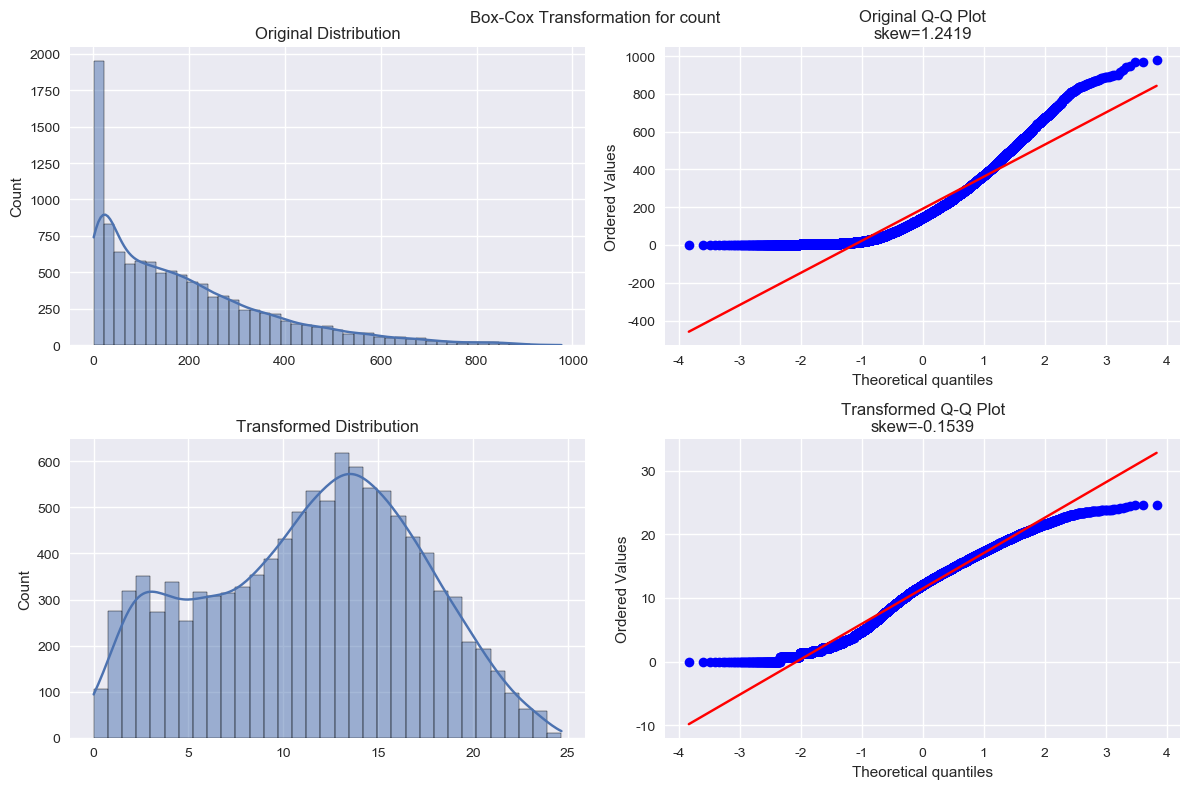

In [34]:
# 1. 初始化转换器
transformer = BoxCoxPipeline(visualization=True)

# 2. 同时转换特征列和目标变量
train_data = transformer.fit_transform(
    data=train_data,
    columns=[],  # 特征列
    target_col='count'            # 目标变量
)

# 3. 转换测试集(自动处理不存在的目标变量列)
#transformed_submit = transformer.transform(submit_data)

# 4. 还原预测结果
# 不指定列名时默认还原目标变量
#restored_predictions = transformer.inverse_transform(stacking_predictions)

## 3.2 特征构造

特征组合： 将多个特征进行组合，例如加减乘除、交叉组合等，以创建新的特征。

多项式特征： 创建原始特征的多项式组合，例如平方、立方等。

基于业务逻辑的特征： 根据业务逻辑和领域知识，设计新的特征。例如，在电商场景中，可以构建“最近一个月购买次数”等特征。

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class BikeShareFeatureEngineering(BaseEstimator, TransformerMixin):
    """自行车共享系统的特征工程类"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        """转换数据"""
        df = df.copy()
        
        # 1. 时间特征处理
        df = self._create_time_features(df)
        
        # 2. 天气特征处理
        df = self._process_weather_features(df)
        
        # 3. 温度特征处理
        df = self._process_temperature_features(df)
        
        # 4. 流量特征处理
        #df = self._create_demand_features(df)
        
        # 5. 特征交互
        df = self._create_interaction_features(df)
        
        # 6. 特征选择
        df = self._select_features(df)
        
        return df
    
    def _create_time_features(self, df):
        """创建时间特征"""
        # 解析datetime
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # 基础时间特征
        #df['year'] = df['datetime'].dt.year
        #df['month'] = df['datetime'].dt.month
        #df['day'] = df['datetime'].dt.day
        #df['hour'] = df['datetime'].dt.hour
        df['dayofweek'] = df['datetime'].dt.dayofweek
        
        # 周期性编码
        df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
        df['month_sin'] = np.sin(2 * np.pi * (df['month']-1)/12)
        df['month_cos'] = np.cos(2 * np.pi * (df['month']-1)/12)
        
        # 工作日/周末时段
        df['workday_hour'] = df['hour'] * df['workingday']
        df['weekend_hour'] = df['hour'] * (1 - df['workingday'])
        
        # 通勤高峰时段
        df['rush_hour'] = ((df['hour'].between(7,9) | 
                           df['hour'].between(17,19)) & 
                          (df['workingday'] == 1)).astype(int)
        
        return df
    
    def _process_weather_features(self, df):
        """处理天气特征"""
        # 天气分组
        df['weather_group'] = np.where(df['weather'].isin([3, 4]), 'bad', 'good')
        
        # 复合天气指数
        df['weather_index'] = (0.6 * (df['weather']/4) + 
                             0.3 * (df['humidity']/100) + 
                             0.1 * (df['windspeed']/50))
        
        # 极端天气标记
        df['extreme_weather'] = (df['weather'] == 4).astype(int)
        
        # 天气-时段交互
        df['bad_weather_rush'] = ((df['weather_group'] == 'bad') & 
                                 (df['rush_hour'] == 1)).astype(int)
        
        return df
    
    def _process_temperature_features(self, df):
        """处理温度特征"""
        # 保留atemp，删除temp（高度相关）
        if 'temp' in df.columns:
            df = df.drop('temp', axis=1)
        
        # # 温度分箱
        # df['temp_bin'] = pd.cut(df['atemp'], 
        #                        bins=[-np.inf, 0, 15, 25, 35, np.inf],
        #                        labels=['very_cold', 'cold', 'mild', 'warm', 'hot'])
        
        # 修改温度分箱的边界值，确保所有数据都能被正确分类，测试集中有0，训练集中无0
        df['temp_bin'] = pd.cut(df['atemp'], 
                           bins=[-np.inf, 10, 20, 30, np.inf],
                           labels=['cold', 'mild', 'warm', 'hot'])
    
        # 最适温度区间
        df['optimal_temp'] = df['atemp'].between(15, 25).astype(int)
        
        # 温度趋势（如果是时序数据）
        if len(df) > 3:
            df['temp_trend'] = df['atemp'].rolling(3).mean()
            df['temp_trend'] = df['temp_trend'].fillna(method='bfill')
        
        return df
    
    '''
    def _create_demand_features(self, df):
        """创建需求特征"""
        if 'count' in df.columns:  # 只在训练集上创建
            # 历史需求
            df['last_3h_demand'] = df['count'].shift(3)
            df['same_hour_last_day'] = df['count'].shift(24)
            
            # 填充缺失值
            df['last_3h_demand'] = df['last_3h_demand'].fillna(df['count'].mean())
            df['same_hour_last_day'] = df['same_hour_last_day'].fillna(df['count'].mean())
            
            # 需求变化率
            df['demand_change'] = df['count'].pct_change()
            df['demand_change'] = df['demand_change'].fillna(0)
        
        return df
     '''
    
    def _create_demand_features(self, df):
        """创建需求特征
        改进说明:
        1. 特征设计思路:
        不再使用基于实际需求的滞后特征
        改用基于统计信息的特征(均值、标准差等)
        这些统计特征可以在训练集和测试集中保持一致
        2. 主要特征:
        时间特征: 每个小时的平均需求和波动
        天气特征: 不同天气条件下的需求特征
        工作日特征: 工作日/非工作日的需求特征
        复合特征: 综合考虑多个因素的期望需求
        3. 实现机制:
        在训练集上计算统计值并保存
        在测试集上使用保存的统计值
        确保特征的一致性
        4. 优点:
        训练集和测试集特征保持一致
        捕捉了不同条件下的需求模式
        提供了需求预测的基准信息
        5. 这种方法更适合实际预测场景，因为它:
        1. 保证了训练和预测时特征的一致性
        2. 利用了历史统计信息而不是实时数据
        3. 考虑了多个影响因素的组合效应
        """
        if 'datetime' in df.columns:
            # 1. 基于时间的特征
            if 'count' in df.columns:  # 训练集
                hour_stats = df.groupby('hour').agg({
                    'count': ['mean', 'std']
                }).reset_index()
                self.hour_means = dict(zip(hour_stats['hour'], hour_stats['count']['mean']))
                self.hour_stds = dict(zip(hour_stats['hour'], hour_stats['count']['std']))
            
            # 使用get方法设置默认值，避免KeyError
            df['hour_avg_demand'] = df['hour'].map(lambda x: self.hour_means.get(x, 0)) if hasattr(self, 'hour_means') else 0
            df['hour_std_demand'] = df['hour'].map(lambda x: self.hour_stds.get(x, 0)) if hasattr(self, 'hour_stds') else 0
            
            # 2. 基于天气的需求特征
            if 'count' in df.columns:  # 训练集
                # 先打印天气类型的分布情况
                print("训练集天气类型分布：")
                print(df['weather'].value_counts())
                
                weather_stats = df.groupby('weather').agg({
                    'count': ['mean', 'std']
                }).reset_index()
                self.weather_means = dict(zip(weather_stats['weather'], weather_stats['count']['mean']))
                self.weather_stds = dict(zip(weather_stats['weather'], weather_stats['count']['std']))
            else:  # 测试集
                print("测试集天气类型分布：")
                print(df['weather'].value_counts())
            
            # 使用get方法设置默认值，对于未见过的天气类型使用所有天气类型的平均值
            if hasattr(self, 'weather_means'):
                default_mean = np.mean(list(self.weather_means.values()))
                default_std = np.mean(list(self.weather_stds.values()))
                df['weather_avg_demand'] = df['weather'].map(lambda x: self.weather_means.get(x, default_mean))
                df['weather_std_demand'] = df['weather'].map(lambda x: self.weather_stds.get(x, default_std))
            else:
                df['weather_avg_demand'] = 0
                df['weather_std_demand'] = 0
            
            # 3. 基于工作日的需求特征
            if 'count' in df.columns:  # 训练集
                workingday_stats = df.groupby('workingday').agg({
                    'count': ['mean', 'std']
                }).reset_index()
                self.workingday_means = dict(zip(workingday_stats['workingday'], workingday_stats['count']['mean']))
                self.workingday_stds = dict(zip(workingday_stats['workingday'], workingday_stats['count']['std']))
            
            # 使用get方法设置默认值
            df['workingday_avg_demand'] = df['workingday'].map(lambda x: self.workingday_means.get(x, 0)) if hasattr(self, 'workingday_means') else 0
            df['workingday_std_demand'] = df['workingday'].map(lambda x: self.workingday_stds.get(x, 0)) if hasattr(self, 'workingday_stds') else 0
            
            # 4. 复合特征
            df['expected_demand'] = (
                df['hour_avg_demand'] * 0.5 + 
                df['weather_avg_demand'] * 0.3 + 
                df['workingday_avg_demand'] * 0.2
            )
            
            df['demand_volatility'] = (
                df['hour_std_demand'] * 0.5 + 
                df['weather_std_demand'] * 0.3 + 
                df['workingday_std_demand'] * 0.2
            )
            
            # 5. 验证没有NaN值
            nan_cols = df.columns[df.isna().any()].tolist()
            if nan_cols:
                print("警告：以下列存在NaN值：", nan_cols)
                print("NaN值数量：")
                print(df[nan_cols].isna().sum())
        
        return df

    def _create_interaction_features(self, df):
        """创建交互特征"""
        # 温度-时段交互
        df['warm_rush'] = ((df['temp_bin'].isin(['mild', 'warm'])) & 
                          (df['rush_hour'] == 1)).astype(int)
        
        # 天气-周末交互
        df['good_weather_weekend'] = ((df['weather_group'] == 'good') & 
                                    (df['workingday'] == 0)).astype(int)
        
        # 季节-时段交互
        df['summer_evening'] = ((df['season'] == 2) & 
                              (df['hour'].between(17, 20))).astype(int)
        
        return df
    
    def _select_features(self, df):
        """特征选择"""
        # 删除不需要的特征
        drops = ['datetime', 'date','casual', 'registered', 'holiday', 
                'is_month_start', 'is_month_end']
        
        # 只删除存在的列
        drops = [col for col in drops if col in df.columns]
        df = df.drop(drops, axis=1)
        
        # 类别特征编码
        cat_features = ['weather','weather_group', 'temp_bin', 'season']
        for feature in cat_features:
            if feature in df.columns:
                if feature not in self.label_encoders:
                    self.label_encoders[feature] = LabelEncoder()
                    df[feature] = self.label_encoders[feature].fit_transform(df[feature])
                else:
                    df[feature] = self.label_encoders[feature].transform(df[feature])
        
        return df

# 使用示例
def prepare_features(train_data, test_data):
    """准备特征"""
    # 初始化特征工程类
    feature_engineering = BikeShareFeatureEngineering()
    
    # 转换训练集和测试集
    train_features = feature_engineering.transform(train_data)
    test_features = feature_engineering.transform(test_data)
    
    return train_features, test_features





## 使用示例
# 读取数据


# 特征工程
train_data, submit_data = prepare_features(train_data, submit_data)



# 查看结果
print("训练集特征:", train_data.shape)
print("测试集特征:", submit_data.shape)
print("\n特征列表:", train_data.columns.tolist())


训练集特征: (10886, 33)
测试集特征: (6493, 32)

特征列表: ['season', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour', 'minute', 'weekday', 'quarter', 'is_weekend', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'workday_hour', 'weekend_hour', 'rush_hour', 'weather_group', 'weather_index', 'extreme_weather', 'bad_weather_rush', 'temp_bin', 'optimal_temp', 'temp_trend', 'warm_rush', 'good_weather_weekend', 'summer_evening']


In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                10886 non-null  int64  
 1   workingday            10886 non-null  int64  
 2   weather               10886 non-null  int64  
 3   atemp                 10886 non-null  float64
 4   humidity              10886 non-null  int64  
 5   windspeed             10886 non-null  float64
 6   count                 10886 non-null  float64
 7   year                  10886 non-null  int32  
 8   month                 10886 non-null  int32  
 9   day                   10886 non-null  int32  
 10  hour                  10886 non-null  int32  
 11  minute                10886 non-null  int32  
 12  weekday               10886 non-null  int32  
 13  quarter               10886 non-null  int32  
 14  is_weekend            10886 non-null  int32  
 15  dayofweek          

## 3.3 特征选择

> 根据热力图和多重共线性分析选择特征

过滤法 (Filter)： 根据特征的统计指标（例如方差、相关系数、互信息等）进行特征选择，与模型无关。

包裹法 (Wrapper)： 将特征选择视为一个搜索问题，使用模型性能作为评价指标，例如递归特征消除 (RFE)。

嵌入法 (Embedded)： 将特征选择嵌入到模型训练过程中，例如 Lasso 回归、决策树等。
基于树模型的特征重要性： 使用随机森林或 XGBoost 等树模型，根据特征在模型中的重要性进行选择。

目标：  选择对目标变量最有预测能力的特征，减少特征数量，降低模型复杂度，防止过拟合，提高模型性能和训练速度。

先归一化、编码在选择特征，还是反之：

一般情况： 通常推荐 先选择特征，再归一化和编码 的方法。
这样可以显著减少计算量，并避免对无用特征进行不必要的操作，提高效率。
对于大多数问题，这种方法在效率和性能之间取得了较好的平衡。
特殊情况：
如果你的特征集不大，或者你认为特征之间的相互作用非常重要，可以考虑 先归一化和编码，再选择特征。
在使用某些依赖距离度量的特征选择方法（如基于 KNN 的方法）时，可能需要先对特征进行归一化。
在使用某些模型时，例如 SVM，特征的缩放非常重要，应该先进行归一化。

In [37]:
# 选择特征
# train_features_to_keep=['season','holiday','workingday','weather','temp','humidity','windspeed','count','year','month','day','hour','weekday']
# train_data=train_data[train_features_to_keep]
# submit_features_to_keep=['season','holiday','workingday','weather','temp','humidity','windspeed','year','month','day','hour','weekday']
# submit_data=submit_data[submit_features_to_keep]


## 3.4 特征提取 

领域知识： 利用领域知识，从原始数据中提取有意义的特征。例如，在自然语言处理中，可以提取文本长度、词频等特征；在图像处理中，可以提取颜色直方图、纹理特征等。

自动特征提取： 使用自动化的方法提取特征，例如主成分分析 (PCA)、独立成分分析 (ICA)、线性判别分析 (LDA) 等降维技术，以及深度学习方法（如自编码器）来学习数据的低维表示。

## 数据变换-数据规范化


In [38]:
class NormalizationPipeline:
    """
    归一化处理通用流程
    1. 支持对不同列使用不同的归一化方法
    2. 对目标变量以外的特征进行合并归一化，目标变量仅使用训练集归一化
    3. 根据原始列名选择对应的还原方法还原数据
    """
    def __init__(self):
        self.scalers = {}  # 存储每个列的归一化器
        self.normalized_columns = None  # 记录已归一化的列
        
    # def _get_numeric_columns(self, data):
    #     """
    #     拟合并转换数据
        
    #     参数:
    #     - data: DataFrame或dict, 输入数据
    #     - method: str, 归一化方法，默认为None(自动选择)
    #     - combined: bool, 是否采用合并归一化，默认为True
    #     - columns: list, 指定需要归一化的列，默认为None(所有数值列)
    #     - target_col: str, 目标变量列名，默认为'count'
        
    #     返回:
    #     - list: 需要归一化的列名列表
    #     """
    #     """
    #     拟合并转换数据
    #     """
    #     if combined:
    #         if not isinstance(data, dict):
    #             raise ValueError("combined=True时,data应为包含train和test的字典")
        
    #         # 分离目标变量和特征列
    #         feature_cols = [col for col in columns if col != target_col]
        
    #         # 初始化结果字典
    #         normalized_data = {'train': data['train'].copy(), 'test': data['test'].copy()}
        
    #         return numeric_columns
    
    def _check_data_characteristics(self, data):
        """
                    data['train'][feature_cols], 
                    data['test'][feature_cols]
                ])
            
        
        返回:
        - str: 建议使用的归一化方法名称
        """
        # 转换为numpy数组进行统计分析
        if isinstance(data, pd.DataFrame):
            X = data.values
        else:
            X = data
            
        # 1. 检查是否存在异常值
        z_scores = np.abs((X - np.mean(X, axis=0)) / np.std(X, axis=0))
        has_outliers = np.any(z_scores > 3)
        
        # 2. 检查数据分布是否接近正态
        from scipy import stats
        _, p_value = stats.normaltest(X.flatten())
        is_normal = p_value > 0.05
        
        # 3. 检查是否为稀疏矩阵
        sparsity = 1.0 - (np.count_nonzero(X) / float(X.size))
        is_sparse = sparsity > 0.5
        
        # 根据特征选择归一化方法
        if has_outliers:
            return 'robust' # 基于四分位数（IQR）的范围
        elif is_normal:
            return 'standard' # 均值为 0，标准差为 1的范围
        elif is_sparse:
            return 'maxabs' # [-1, 1]
        else:
            return 'minmax' # [0,1]
            
    def _get_scaler(self, method):
        """根据方法名获取对应的归一化器"""
        scalers = {
            'minmax': MinMaxScaler(),
            'standard': StandardScaler(),
            'robust': RobustScaler(),
            'maxabs': MaxAbsScaler()
        }
        return scalers.get(method, MinMaxScaler())
    def fit_transform(self, data, method=None, combined=True, columns=None, target_col='count'):   

        """
        拟合并转换数据
        
        参数:
        - data: DataFrame或dict, 输入数据
        - method: str, 归一化方法，默认为None(自动选择)
        - combined: bool, 是否采用合并归一化，默认为True
        - columns: list, 指定需要归一化的列，默认为None(所有数值列)
        - target_col: str, 目标变量列名，默认为'count'
        
        返回:
        - DataFrame或dict: 归一化后的数据
        """

        if combined:
            if not isinstance(data, dict):
                raise ValueError("combined=True时,data应为包含train和test的字典")
        
            # 分离目标变量和特征列
            feature_cols = [col for col in columns if col != target_col]
        
            # 初始化结果字典
            normalized_data = {'train': data['train'].copy(), 'test': data['test'].copy()}
        
            # 1. 对特征列进行合并归一化
            if feature_cols:
                # 合并特征数据
                combined_features = pd.concat([
                    data['train'][feature_cols], 
                    data['test'][feature_cols]
                ])
            
                for col in feature_cols:
                    if method is None:
                        col_method = self._check_data_characteristics(combined_features[[col]])
                    else:
                        col_method = method
                    print(f"特征列 {col} 使用 {col_method} 归一化方法")
                
                    self.scalers[col] = self._get_scaler(col_method)
                    normalized_values = self.scalers[col].fit_transform(
                        combined_features[[col]]
                    ).ravel()
                
                    # 分别更新训练集和测试集
                    normalized_data['train'][col] = normalized_values[:len(data['train'])]
                    normalized_data['test'][col] = normalized_values[len(data['train']):]
        
        # 2. 单独处理目标变量(仅在训练集上)
            if target_col in columns:
                target_method = method or self._check_data_characteristics(
                    data['train'][[target_col]]
                )
                print(f"目标变量 {target_col} 使用 {target_method} 归一化方法")
            
                self.scalers[target_col] = self._get_scaler(target_method)
                normalized_data['train'][target_col] = self.scalers[target_col].fit_transform(
                    data['train'][[target_col]]
                ).ravel()
        
            return normalized_data
    
          
        else:
            # 分开归一化
            self.normalized_columns = self._get_columns_to_normalize(
                data, columns
            )
            print(f"将对以下列进行归一化: {self.normalized_columns}")
            
            normalized_data = data.copy()
            for col in self.normalized_columns:
                if method is None:
                    col_method = self._check_data_characteristics(
                        data[[col]]
                    )
                else:
                    col_method = method
                    
                print(f"列 {col} 使用 {col_method} 归一化方法")
                
                self.scalers[col] = self._get_scaler(col_method)
                normalized_data[col] = self.scalers[col].fit_transform(
                    data[[col]]
                ).ravel()
            
            return normalized_data
            
    def transform(self, data):
        """使用已拟合的归一化器转换新数据"""
        if not self.scalers:
            raise ValueError("请先调用fit_transform")
            
        normalized_data = data.copy()
        for col, scaler in self.scalers.items():
            if col in data.columns:
                normalized_data[col] = scaler.transform(
                    data[[col]]
                ).ravel()
        return normalized_data

    def restore_predictions(self, predictions, source_column='count'):
        """
        还原预测结果到原始尺度
        
        参数:
        - predictions: array或DataFrame, 归一化尺度的预测结果
        - source_column: str, 对应的原始列名，默认为'count'
        
        返回:
        - array: 原始尺度的预测结果
        """
        if not self.scalers or source_column not in self.scalers:
            raise ValueError(f"没有找到列 {source_column} 的归一化器")
            
        try:
            # 转换输入格式为二维数组
            if isinstance(predictions, (pd.Series, list, np.ndarray)):
                predictions = np.array(predictions).reshape(-1, 1)
            elif isinstance(predictions, pd.DataFrame):
                predictions = predictions.values.reshape(-1, 1)
                
            # 使用对应列的归一化器进行还原
            restored_values = self.scalers[source_column].inverse_transform(predictions).ravel()
            
            # 处理负值
            restored_values = np.maximum(restored_values, 0)
            
            return restored_values
            
        except Exception as e:
            print(f"还原预测结果时出错: {str(e)}")
            return None
# 使用示例：

# 1. 初始化归一化器
normalizer = NormalizationPipeline()

# 2. 对数据进行归一化
normalized_data = normalizer.fit_transform(
    data={'train': train_data, 'test': submit_data},
    columns=['count'],  # 指定所有需要归一化的列，若归一化目标变量则需要包含
    target_col='count',  # 指定目标变量
    #method='minmax',
    combined=True
)

# 3. 获取归一化后的数据
train_data = normalized_data['train']
submit_data = normalized_data['test']

# 4. 训练模型并预测
#predictions = pipeline.predict(submit_data_normalized)

# 5. 还原预测结果
#restored_predictions = normalizer.restore_predictions(predictions, source_column='count')

# 6. 保存结果
# submission = pd.DataFrame({
#     'datetime': submit_data.index,
#     'count': restored_predictions
# })
# submission.to_csv('submission.csv', index=False)


目标变量 count 使用 minmax 归一化方法



## 数据变换- 离散变量编码


In [39]:
'''
# 强制转换为类别类型
from sklearn.preprocessing import LabelEncoder
def convert_to_category(data, category_columns=None):
    """
    将指定列转换为分类(category)类型
    
    参数:
    - data: DataFrame, 输入数据
    - category_columns: list, 需要转换的列名列表
    
    返回:
    - DataFrame: 转换后的数据框
    """
    if category_columns is None:
        print("category_columns is none")
        return
        
    df = data.copy()
    for col in category_columns:
        if col in df.columns:
            df[col] = df[col].astype("category")
        else:
            print(f"警告: 列 {col} 不存在于数据中")
        
    return df

# 转换数据类型
#train_data = convert_to_category(train_data,
#                                 category_columns=["season","holiday","workingday","weather","weekday","month","year","hour"])

## 分类特征编码
class CategoryEncoder:
    """分类特征编码器"""
    def __init__(self):
        self.label_encoders = {}  # 存储每个特征的LabelEncoder
        self.feature_columns = {}  # 存储One-Hot编码后的列名

    def fit_transform(self, data, ordinal_features=None, nominal_features=None):
        """拟合并转换训练数据"""
        df = data.copy()
        
        # 1. 处理有序特征(Label Encoding)
        if ordinal_features:
            for col in ordinal_features:
                if col in df.columns:
                    le = LabelEncoder()
                    df[col] = le.fit_transform(df[col].astype(str))
                    self.label_encoders[col] = le
                else:
                    print(f"警告: 列 {col} 不存在于数据中")
        
        # 2. 处理无序特征(One-Hot Encoding)
        if nominal_features:
            df = pd.get_dummies(df, 
                              columns=nominal_features,
                              prefix=nominal_features)
            # 保存生成的One-Hot列名
            for col in nominal_features:
                self.feature_columns[col] = [c for c in df.columns if c.startswith(f"{col}_")]
        
        return df

    def transform(self, data):
        """转换测试数据"""
        df = data.copy()
        
        # 1. 使用已拟合的LabelEncoder转换有序特征
        for col, le in self.label_encoders.items():
            if col in df.columns:
                # 处理测试集中的未知类别
                df[col] = df[col].astype(str)
                for val in df[col].unique():
                    if val not in le.classes_:
                        print(f"警告: 特征 {col} 中发现新类别 {val}，将其替换为最频繁类别")
                df[col] = df[col].map(lambda x: x if x in le.classes_ else le.classes_[0])
                df[col] = le.transform(df[col])
        
        # 2. 处理无序特征的One-Hot编码
        for col, columns in self.feature_columns.items():
            if col in df.columns:
                # 创建One-Hot编码
                temp_df = pd.get_dummies(df[col], prefix=col)
                # 确保所有训练集中的列都存在
                for column in columns:
                    if column not in temp_df.columns:
                        temp_df[column] = 0
                # 删除多余的列
                temp_df = temp_df[columns]
                # 替换原始列
                df = df.drop(col, axis=1)
                df = pd.concat([df, temp_df], axis=1)
        
        return df

# # 1. 先转换为category类型（如果需要）
# train_data = convert_to_category(
#     train_data,
#     category_columns=["season", "holiday", "weather"]
# )
# submit_data = convert_to_category(
#     submit_data,
#     category_columns=["season", "holiday", "weather"]
# )

# 2. 使用编码器进行特征编码
encoder = CategoryEncoder()

# 拟合并转换训练集
train_data = encoder.fit_transform(
    train_data,
    ordinal_features=['season'],
    nominal_features=['weather', 'holiday']
)

# 使用相同的编码器转换测试集
submit_data = encoder.transform(submit_data)
 '''


'\n# 强制转换为类别类型\nfrom sklearn.preprocessing import LabelEncoder\ndef convert_to_category(data, category_columns=None):\n    """\n    将指定列转换为分类(category)类型\n    \n    参数:\n    - data: DataFrame, 输入数据\n    - category_columns: list, 需要转换的列名列表\n    \n    返回:\n    - DataFrame: 转换后的数据框\n    """\n    if category_columns is None:\n        print("category_columns is none")\n        return\n        \n    df = data.copy()\n    for col in category_columns:\n        if col in df.columns:\n            df[col] = df[col].astype("category")\n        else:\n            print(f"警告: 列 {col} 不存在于数据中")\n        \n    return df\n\n# 转换数据类型\n#train_data = convert_to_category(train_data,\n#                                 category_columns=["season","holiday","workingday","weather","weekday","month","year","hour"])\n\n## 分类特征编码\nclass CategoryEncoder:\n    """分类特征编码器"""\n    def __init__(self):\n        self.label_encoders = {}  # 存储每个特征的LabelEncoder\n        self.feature_columns = {}  # 存储One-Hot编码后的列名\n\n    d



对于时间特征：
1. 周期性特征(hour,month,weekday)->倾向转分类
2. 顺序性特征(year,day)->倾向保持数值

选择建议:
1. 使用Label Encoding:
- 特征有明显的顺序关系
- 使用树模型
- 特征的唯一值较多
- 需要保持特征维度不变
2. 使用One-Hot Encoding:
- 特征无顺序关系
- 使用线性模型
- 特征的唯一值较少
- 需要避免数值大小带来的影响

# 4 模型训练

In [40]:
# 忽略警告信息
import warnings
warnings.filterwarnings("ignore")

# 绘图相关
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

# 数据处理
import pandas as pd
import numpy as np

# 模型选择与评估
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    cross_val_predict,
    KFold,
    RepeatedKFold,
    TimeSeriesSplit,
    StratifiedKFold 
)
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score
)

from sklearn.metrics import accuracy_score


# 线性模型
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# 支持向量机
from sklearn.svm import LinearSVR, SVR

# 最近邻模型
from sklearn.neighbors import KNeighborsRegressor

# 集成学习模型
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)

#  XGBoost 和 LightGBM 模型
import xgboost as xgb
import lightgbm as lgb

# 抽象基类 (虽然这里没有使用，但被引入了，保留)
from abc import ABC, abstractmethod


In [41]:
def rmse(y_true, y_pred):
    """均方根误差"""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def rmsle(y_true, y_pred):
    """
    计算RMSLE (Root Mean Squared Logarithmic Error)
    """
    # 确保预测值和真实值都是正数
    y_true = np.maximum(0, np.array(y_true))  # 将负值截断为0
    y_pred = np.maximum(0, np.array(y_pred))  # 将负值截断为0
    
    # 计算RMSLE
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    squared_errors = np.square(log_pred - log_true)
    mean_squared_errors = np.mean(squared_errors)
    rmsle_score = np.sqrt(mean_squared_errors)
    
    return rmsle_score


In [42]:

class BaseDataSplitter(ABC):
    """
    数据分割器的抽象基类
    """
    @abstractmethod
    def split(self, data, target_col=None):
        """
        将数据分割成训练集和验证集。

        参数:
        - data: 数据集
        - target_col: 目标列名

        返回:
        - X_train, X_val, y_train, y_val
        """
        pass

    @abstractmethod
    def get_cv(self, data, n_splits=5, *args, **kwargs):
        """
        获取交叉验证迭代器。

        参数:
        - data: 数据集
        - n_splits: 交叉验证折数
        - *args, **kwargs: 其他参数

        返回:
        - 交叉验证迭代器
        """
        pass

class RegressionSplitter(BaseDataSplitter):
    """
    用于回归任务的数据分割器
    """
    def __init__(self, test_size=0.2, random_state=42):
        self.test_size = test_size
        self.random_state = random_state

    def split(self, data, target_col=None):
        if target_col is None:
            raise ValueError("target_col must be specified for regression tasks.")
        X = data.drop(target_col, axis=1)
        y = data[target_col]
        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def get_cv(self, data, n_splits=5, *args, **kwargs):
        return KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)

class ClassificationSplitter(BaseDataSplitter):
    """
    用于分类任务的数据分割器
    """
    def __init__(self, test_size=0.2, random_state=42, stratify=True):
        self.test_size = test_size
        self.random_state = random_state
        self.stratify = stratify

    def split(self, data, target_col=None):
        if target_col is None:
            raise ValueError("target_col must be specified for classification tasks.")
        X = data.drop(target_col, axis=1)
        y = data[target_col]
        if self.stratify:
            return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        else:
            return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def get_cv(self, data, n_splits=5, *args, **kwargs):
        target_col = kwargs.get('target_col', None)
        if target_col and self.stratify:
             y = data[target_col]
             return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        else:
             return KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)

class TimeSeriesSplitter(BaseDataSplitter):
    """
    用于时间序列任务的数据分割器
    """
    def __init__(self, test_size=0.2):
        self.test_size = test_size

    def split(self, data, target_col=None):
        data = data.sort_index()
        n_samples = len(data)
        test_samples = int(n_samples * self.test_size)
        train_samples = n_samples - test_samples

        train = data.iloc[:train_samples]
        test = data.iloc[train_samples:]

        if target_col is not None:
            X_train = train.drop(target_col, axis=1)
            y_train = train[target_col]
            X_test = test.drop(target_col, axis=1)
            y_test = test[target_col]
            return X_train, X_test, y_train, y_test
        else:
            return train, test

    def get_cv(self, data, n_splits=5, gap=0, *args, **kwargs):
        test_size = int(len(data) * self.test_size)
        max_splits = (len(data) - gap) // test_size - 1
        n_splits = min(n_splits, max_splits)
        if n_splits < 1:
            raise ValueError(f"数据量不足以进行{n_splits}折交叉验证")
                  
        return TimeSeriesSplit(n_splits=n_splits, gap=gap, test_size=test_size)

class DataSplitterFactory:
    """
    数据分割器的工厂类
    """
    def __init__(self):
        self._splitters = {}

    def register_splitter(self, name, splitter):
        self._splitters[name] = splitter

    def create_splitter(self, name, **kwargs):
        splitter = self._splitters.get(name)
        if not splitter:
            raise ValueError(f"Unknown splitter type: {name}")
        return splitter(**kwargs)


In [60]:
import numpy as np
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Assuming these are defined elsewhere in your code
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

class ModelFactory:
    """
    Model factory class for creating model instances
    """
    def __init__(self):
        self._models = {}
    
    def register_model(self, name, model):
        self._models[name] = model

    def create_model(self, name, **kwargs):
        model = self._models.get(name)
        if not model:
            raise ValueError(f"Unknown model type: {name}")
        return model(**kwargs)

class ModelTrainingPipeline:
    """
    Model training pipeline class with enhanced stacking
    """
    def __init__(self, model_factory, param_optimizer=None, metrics=None, primary_metric='rmse', model_fusion=None, meta_model=None, n_folds=5):
        self.model_factory = model_factory
        self.models = {}
        self.param_optimizer = param_optimizer
        self.meta_model = meta_model
        self.n_folds = n_folds  # Number of folds for stacking CV

        # Metrics setup (unchanged)
        self.available_metrics = {
            'mse': {'func': mean_squared_error, 'greater_is_better': False},
            'rmse': {'func': rmse, 'greater_is_better': False},
            'rmsle': {'func': rmsle, 'greater_is_better': False},
            'r2': {'func': r2_score, 'greater_is_better': True},
            'accuracy': {'func': accuracy_score, 'greater_is_better': True},
            'f1': {'func': f1_score, 'greater_is_better': True},
            'precision': {'func': precision_score, 'greater_is_better': True},
            'recall': {'func': recall_score, 'greater_is_better': True},
            'auc': {'func': roc_auc_score, 'greater_is_better': True}
        }
        self.metrics = self.available_metrics if metrics is None else {
            name: self.available_metrics[name] for name in metrics if name in self.available_metrics
        }
        if primary_metric not in self.metrics:
            raise ValueError(f"Primary metric {primary_metric} not in defined metrics")
        self.primary_metric = primary_metric
        
        self.model_fusion = model_fusion if model_fusion is not None else self.simple_average_fusion
        self.model_scores = {}
        self.train_results = {}
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.training_history = {}
        self.feature_importance = {}
        self.optimization_history = {}
        self.prediction_history = {}
        self.stacking_features = None  # Store stacking features for prediction

    def register_model(self, name, model, **kwargs):
        """Register a model to the pipeline"""
        self.models[name] = self.model_factory.create_model(model, **kwargs)

    def _train_model(self, model_name, X_train, y_train, X_val, y_val, param_grid=None, cv=None):
        """Train a single model (unchanged)"""
        model = self.models[model_name]
        try:
            if param_grid and self.param_optimizer:
                metric_info = self.metrics[self.primary_metric]
                optimized_model = self.param_optimizer(
                    model, param_grid, X_train, y_train, cv,
                    metric_info['func'], metric_info['greater_is_better'],
                    callback=self._update_optimization_history
                )
                self.models[model_name] = optimized_model
                model = optimized_model
            else:
                model.fit(X_train, y_train)
            val_pred = model.predict(X_val)
            model_scores = self._calculate_metrics(y_val, val_pred)
            model_scores['model'] = model
            self.model_scores[model_name] = model_scores
            self.train_results[model_name] = val_pred
            return val_pred
        except Exception as e:
            print(f"Warning: Model {model_name} training failed: {str(e)}")
            return None

    def _calculate_metrics(self, y_true, y_pred):
        """Calculate evaluation metrics (unchanged)"""
        scores = {}
        for metric_name, metric_info in self.metrics.items():
            try:
                scores[metric_name] = metric_info['func'](y_true, y_pred)
            except Exception as e:
                print(f"Warning: Metric {metric_name} calculation failed: {str(e)}")
        return scores

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, param_grids=None, cv=None):
        """Train and evaluate all models, including stacking"""
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

        if param_grids is None:
            param_grids = {}
        predictions = {}

        # Train base models
        for model_name in self.models:
            print(f"\nStarting training model: {model_name}")
            param_grid = param_grids.get(model_name, None)
            val_pred = self._train_model(model_name, X_train, y_train, X_val, y_val, param_grid, cv)
            if val_pred is not None:
                predictions[model_name] = val_pred
        
        # Simple average fusion
        if len(predictions) > 1 and self.model_fusion:
            print("Performing simple average fusion...")
            fusion_pred = self.model_fusion(list(predictions.values()))
            fusion_scores = self._calculate_metrics(y_val, fusion_pred)
            self.model_scores["fusion"] = fusion_scores
            self.train_results["fusion"] = fusion_pred
        
        # Perform stacking with k-fold CV
        if len(predictions) > 1 and self.meta_model is not None:
            print("Performing Stacking fusion...")
            # Combine train and validation sets for full stacking
            X_full = np.vstack([X_train, X_val])
            y_full = np.concatenate([y_train, y_val])
            stacking_pred = self.perform_stacking(X_full, y_full, X_val)
            if stacking_pred is not None:
                self.train_results["stacking"] = stacking_pred
        
        self._analyze_performance()
        return self.model_scores

    def _analyze_performance(self):
        """Analyze and print model performance (unchanged)"""
        print("\nModel performance comparison:")
        print("-" * 50)
        sorted_models = sorted(
            self.model_scores.items(),
            key=lambda x: x[1].get(self.primary_metric, float('inf'))
        )
        for name, scores in sorted_models:
            print(f"{name}:")
            for metric_name, score in scores.items():
                if metric_name != 'model':
                    print(f"  {metric_name}: {score:.4f}")

    # def predict(self, X_test, method='stacking'):
    #     """Generate predictions with enhanced stacking support"""
    #     try:
    #         if method in self.models:
    #             return self.models[method].predict(X_test)
    #         elif method == 'fusion':
    #             predictions = [self.models[name].predict(X_test) for name in self.models]
    #             return self.model_fusion(predictions)
    #         elif method == 'stacking' and self.meta_model is not None:
    #             if not hasattr(self.meta_model, 'fitted_') or self.stacking_features is None:
    #                 raise ValueError("Meta-model not trained or stacking features not prepared. Run train_and_evaluate first.")
    #             # Generate base model predictions on test data
    #             base_predictions = [self.models[name].predict(X_test) for name in self.models]
    #             stacking_features = np.column_stack(base_predictions)
    #             predictions = self.meta_model.predict(stacking_features)
    #             if predictions.ndim == 1:
    #                 predictions = predictions.reshape(-1, 1)
    #             return predictions
    #         else:
    #             raise ValueError(f"Unknown prediction method: {method}")
    #     except Exception as e:
    #         print(f"Prediction failed: {str(e)}")
    #         return None


    def predict(self, X_test, method='stacking'):
        """Generate predictions with enhanced stacking support"""
        try:
            if method in self.models:
                return self.models[method].predict(X_test)
            elif method == 'fusion':
                predictions = [self.models[name].predict(X_test) for name in self.models]
                return self.model_fusion(predictions)
            elif method == 'stacking' and self.meta_model is not None:
                if not hasattr(self.meta_model, 'fitted_') or self.stacking_features is None:
                    raise ValueError("Meta-model not trained or stacking features not prepared. Run train_and_evaluate first.")
                
                # Generate base model predictions on test data
                base_predictions = [self.models[name].predict(X_test) for name in self.models]
                stacking_features = np.column_stack(base_predictions)
                
                # 如果训练时使用了原始特征，预测时也需要使用
                if hasattr(self, 'concat_original_features') and self.concat_original_features:
                    stacking_features = np.column_stack([stacking_features, X_test])
                    
                predictions = self.meta_model.predict(stacking_features)
                if predictions.ndim == 1:
                    predictions = predictions.reshape(-1, 1)
                return predictions
            else:
                raise ValueError(f"Unknown prediction method: {method}")
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None




    def simple_average_fusion(self, predictions):
        """Simple average fusion method (unchanged)"""
        return np.mean(predictions, axis=0)



    def perform_stacking(self, X_full, y_full, X_val, concat_original_features=False):
        """
        Perform stacking with k-fold cross-validation for base model predictions
        """
        try:
            if self.meta_model is None:
                raise ValueError("Meta-model not provided for stacking")
            
            # 保存concat_original_features设置，以便predict方法使用
            self.concat_original_features = concat_original_features
            
            # Initialize k-fold cross-validation
            kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
            base_predictions = {name: np.zeros(len(X_full)) for name in self.models}
            
            # Generate out-of-fold predictions for base models
            for train_idx, val_idx in kf.split(X_full):
                X_train_fold, X_val_fold = X_full[train_idx], X_full[val_idx]
                y_train_fold, y_val_fold = y_full[train_idx], y_full[val_idx]
                
                for model_name in self.models:
                    model = self.models[model_name]
                    model.fit(X_train_fold, y_train_fold)
                    val_pred = model.predict(X_val_fold)
                    base_predictions[model_name][val_idx] = val_pred
            
            # Stack base predictions
            all_predictions = np.column_stack([base_predictions[name] for name in self.models])
            if concat_original_features:
                all_predictions = np.column_stack([all_predictions, X_full])
            
            # Train meta-model on out-of-fold predictions
            print("Training stacking meta-model...")
            self.meta_model.fit(all_predictions, y_full)
            self.meta_model.fitted_ = True  # Flag to indicate training
            

            # Retrain base models on full data
            print("Retraining base models on full training data...")
            for model_name in self.models:
                self.models[model_name].fit(X_full, y_full)

            # Generate stacking predictions on validation set for evaluation
            val_base_preds = [self.models[name].predict(X_val) for name in self.models]
            val_stacking_features = np.column_stack(val_base_preds)
            if concat_original_features:
                val_stacking_features = np.column_stack([val_stacking_features, X_val])
            stacking_pred = self.meta_model.predict(val_stacking_features)
            
            # Store stacking features structure for prediction
            self.stacking_features = val_stacking_features
            
            # Calculate and store stacking performance
            scores = self._calculate_metrics(y_full[-len(X_val):], stacking_pred)
            scores['model'] = self.meta_model
            self.model_scores['stacking'] = scores
            
            print(f"\nStacking model performance:")
            for metric_name, score in scores.items():
                if metric_name != 'model':
                    print(f"  {metric_name}: {score:.4f}")
            
            return stacking_pred
            
        except Exception as e:
            print(f"Warning: Stacking failed: {str(e)}")
            return None



    # 原模型超参数-未调整好
    # def perform_stacking(self, X_full, y_full, X_val, concat_original_features=False, meta_param_grid=None):
    #     """
    #     Perform stacking with k-fold cross-validation for base model predictions
        
    #     参数:
    #     - X_full: 训练数据特征
    #     - y_full: 训练数据标签
    #     - X_val: 验证数据特征
    #     - concat_original_features: 是否将原始特征与基础模型预测拼接
    #     - meta_param_grid: 元模型的超参数网格，用于网格搜索
    #     """
    #     try:
    #         if self.meta_model is None:
    #             raise ValueError("Meta-model not provided for stacking")
            
    #         # 保存concat_original_features设置，以便predict方法使用
    #         self.concat_original_features = concat_original_features
            
    #         # Initialize k-fold cross-validation
    #         kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
    #         base_predictions = {name: np.zeros(len(X_full)) for name in self.models}
            
    #         # Generate out-of-fold predictions for base models
    #         for train_idx, val_idx in kf.split(X_full):
    #             X_train_fold, X_val_fold = X_full[train_idx], X_full[val_idx]
    #             y_train_fold, y_val_fold = y_full[train_idx], y_full[val_idx]
                
    #             for model_name in self.models:
    #                 model = self.models[model_name]
    #                 model.fit(X_train_fold, y_train_fold)
    #                 val_pred = model.predict(X_val_fold)
    #                 base_predictions[model_name][val_idx] = val_pred
            
    #         # Stack base predictions
    #         all_predictions = np.column_stack([base_predictions[name] for name in self.models])
    #         if concat_original_features:
    #             all_predictions = np.column_stack([all_predictions, X_full])
            
    #         # 训练meta-model，如果提供了参数网格则进行网格搜索
    #         print("Training stacking meta-model...")
    #         if meta_param_grid is not None:
    #             print(f"执行元模型网格搜索，参数网格: {meta_param_grid}")
                
    #             # 创建网格搜索对象
    #             metric_info = self.metrics[self.primary_metric]
    #             meta_cv = KFold(n_splits=min(5, len(X_full) // 3), shuffle=True, random_state=42)
                
    #             gsearch = GridSearchCV(
    #                 self.meta_model,
    #                 meta_param_grid,
    #                 cv=meta_cv,
    #                 scoring=make_scorer(
    #                     metric_info['func'],
    #                     greater_is_better=metric_info['greater_is_better']
    #                 ),
    #                 verbose=1,
    #                 return_train_score=True
    #             )
                
    #             # 执行网格搜索
    #             gsearch.fit(all_predictions, y_full)
                
    #             # 输出优化结果
    #             metric_name = self.primary_metric.upper()
    #             best_score = abs(gsearch.best_score_) if not metric_info['greater_is_better'] else gsearch.best_score_
                
    #             print(f"\n元模型网格搜索结果:")
    #             print(f"- 最佳参数：{gsearch.best_params_}")
    #             print(f"- 最佳{metric_name}得分：{best_score:.4f}")
    #             print(f"- 验证集标准差：{np.mean(gsearch.cv_results_['std_test_score']):.4f}")
                
    #             # 更新meta_model为最佳模型
    #             self.meta_model = gsearch.best_estimator_
                
    #             # 保存优化历史
    #             if 'stacking' not in self.optimization_history:
    #                 self.optimization_history['stacking'] = {
    #                     'params': [],
    #                     'scores': []
    #                 }
                
    #             for i, params in enumerate(gsearch.cv_results_['params']):
    #                 mean_score = abs(gsearch.cv_results_['mean_test_score'][i]) if not metric_info['greater_is_better'] else gsearch.cv_results_['mean_test_score'][i]
    #                 self.optimization_history['stacking']['params'].append(params)
    #                 self.optimization_history['stacking']['scores'].append(mean_score)
    #         else:
    #             # 直接训练meta_model
    #             self.meta_model.fit(all_predictions, y_full)
            
    #         self.meta_model.fitted_ = True  # Flag to indicate training

    #         # Retrain base models on full data
    #         print("Retraining base models on full training data...")
    #         for model_name in self.models:
    #             self.models[model_name].fit(X_full, y_full)

    #         # Generate stacking predictions on validation set for evaluation
    #         val_base_preds = [self.models[name].predict(X_val) for name in self.models]
    #         val_stacking_features = np.column_stack(val_base_preds)
    #         if concat_original_features:
    #             val_stacking_features = np.column_stack([val_stacking_features, X_val])
    #         stacking_pred = self.meta_model.predict(val_stacking_features)
            
    #         # Store stacking features structure for prediction
    #         self.stacking_features = val_stacking_features
            
    #         # Calculate and store stacking performance
    #         scores = self._calculate_metrics(y_full[-len(X_val):], stacking_pred)
    #         scores['model'] = self.meta_model
    #         self.model_scores['stacking'] = scores
            
    #         print(f"\nStacking model performance:")
    #         for metric_name, score in scores.items():
    #             if metric_name != 'model':
    #                 print(f"  {metric_name}: {score:.4f}")
            
    #         return stacking_pred
            
    #     except Exception as e:
    #         print(f"Warning: Stacking failed: {str(e)}")
    #         return None



    def visualize_training(self):
        """综合可视化函数"""
        self._plot_model_comparison()
        self._plot_feature_importance()
        self._plot_optimization_history()
        self._plot_prediction_vs_actual()
        self._plot_residual_analysis()
        self._plot_learning_curves()
        self._plot_cross_validation_scores()
        self._plot_correlation_matrix()
        self._plot_error_distribution()
        
    def _plot_model_comparison(self):
        """绘制模型性能对比图"""
        try:
                    # 设置中文字体
            plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
            plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
            
            plt.figure(figsize=(12, 6))
            
            # 准备数据
            models = list(self.model_scores.keys())
            metrics_data = {
                metric: [self.model_scores[model][metric] 
                        for model in models if metric in self.model_scores[model] and metric != 'model']
                for metric in self.metrics.keys()
            }
            
            # 绘制柱状图
            x = np.arange(len(models))
            width = 0.8 / len(metrics_data)
            
            for i, (metric, scores) in enumerate(metrics_data.items()):
                plt.bar(x + i * width, scores, width, label=metric.upper())
            
            plt.xlabel('模型')
            plt.ylabel('评分')
            plt.title('模型性能对比')
            plt.xticks(x + width * (len(metrics_data) - 1) / 2, models, rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"绘制模型对比图失败: {str(e)}")
            
    def _plot_feature_importance(self):
        """绘制特征重要性图"""
        try:
            # 设置中文字体
            plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
            plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
            
            for model_name, model in self.models.items():
                if hasattr(model, 'feature_importances_'):
                    plt.figure(figsize=(12, 6))
                    importances = model.feature_importances_
                    
                    # 确保有特征名称
                    if hasattr(self, 'feature_names'):
                        features = self.feature_names
                    else:
                        features = [f'特征_{i}' for i in range(len(importances))]
                        
                    # 创建特征重要性的DataFrame
                    importance_df = pd.DataFrame({
                        '特征': features,
                        '重要性': importances
                    })
                    
                    # 按重要性降序排序
                    importance_df = importance_df.sort_values('重要性', ascending=False)
                    
                    # 绘制条形图
                    sns.barplot(data=importance_df, x='特征', y='重要性')
                    
                    # 设置图表样式
                    plt.xticks(rotation=45, ha='right')
                    plt.xlabel('特征')
                    plt.ylabel('重要性')
                    plt.title(f'{model_name} 特征重要性分析')
                    
                    # 调整布局以防止标签被切割
                    plt.tight_layout()
                    plt.show()
                    
        except Exception as e:
            print(f"绘制特征重要性图失败: {str(e)}")

    def _plot_optimization_history(self):
        """绘制参数优化过程图"""
        try:
            # 设置中文字体
            plt.rcParams['font.sans-serif'] = ['SimHei']  
            plt.rcParams['axes.unicode_minus'] = False  
        
            if hasattr(self, 'optimization_history'):
                for model_name, history in self.optimization_history.items():
                    if 'params' in history and 'scores' in history:
                        # 获取所有参数名
                        param_names = list(history['params'][0].keys())
                        n_params = len(param_names)
                        
                        # 创建子图网格
                        n_rows = (n_params + 1) // 2  # 参数图 + 得分图
                        fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
                        axes = axes.flatten()
                        
                        # 1. 绘制总体优化得分
                        ax = axes[0]
                        scores = history['scores']
                        ax.plot(scores, marker='o')
                        ax.set_xlabel('迭代次数')
                        ax.set_ylabel(f'{self.primary_metric} 分数')
                        ax.set_title(f'{model_name} 整体优化过程')
                        
                        # 标注最优点
                        metric_info = self.metrics[self.primary_metric]
                        if metric_info['greater_is_better']:
                            best_idx = np.argmax(scores)
                        else:
                            best_idx = np.argmin(scores)
                        ax.scatter(best_idx, scores[best_idx], 
                                color='red', s=100, label='最优点')
                        ax.legend()
                        ax.grid(True)
                        
                        # 2. 为每个参数绘制优化轨迹
                        for i, param_name in enumerate(param_names, 1):
                            if i < len(axes):  # 确保有足够的子图
                                ax = axes[i]
                                param_values = [params[param_name] for params in history['params']]
                                
                                # 绘制参数变化
                                ax.plot(param_values, marker='o')
                                ax.set_xlabel('迭代次数')
                                ax.set_ylabel(param_name)
                                ax.set_title(f'{param_name} 参数变化')
                                
                                # 标注最优点
                                ax.scatter(best_idx, param_values[best_idx], 
                                        color='red', s=100, label='最优值')
                                ax.legend()
                                ax.grid(True)
                        
                        # 删除多余的子图
                        for i in range(n_params + 1, len(axes)):
                            fig.delaxes(axes[i])
                        
                        plt.tight_layout()
                        plt.show()
                            
        except Exception as e:
            print(f"绘制优化过程图失败: {str(e)}")
          
    def _update_optimization_history(self, model_name, params, score):
        """更新优化历史记录"""
        if model_name not in self.optimization_history:
            self.optimization_history[model_name] = {
                'params': [],
                'scores': []
            }
        self.optimization_history[model_name]['params'].append(params)
        self.optimization_history[model_name]['scores'].append(score)

    def _plot_prediction_vs_actual(self):
        """绘制预测值与实际值对比图"""
        try:
            plt.figure(figsize=(10, 6))
            for model_name, pred in self.train_results.items():
                plt.scatter(self.y_val, pred, alpha=0.5, label=model_name)
            
            # 添加对角线
            min_val = min(plt.xlim()[0], plt.ylim()[0])
            max_val = max(plt.xlim()[1], plt.ylim()[1])
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='理想预测线')
            
            plt.xlabel('实际值')
            plt.ylabel('预测值')
            plt.title('预测值 vs 实际值')
            plt.legend()
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"绘制预测对比图失败: {str(e)}")
            
    def _plot_residual_analysis(self):
        """绘制残差分析图"""
        try:
            for model_name, pred in self.train_results.items():
                residuals = self.y_val - pred
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                
                # 残差散点图
                ax1.scatter(pred, residuals, alpha=0.5)
                ax1.axhline(y=0, color='r', linestyle='--')
                ax1.set_xlabel('预测值')
                ax1.set_ylabel('残差')
                ax1.set_title(f'{model_name} 残差散点图')
                
                # 残差分布图
                sns.histplot(residuals, kde=True, ax=ax2)
                ax2.set_xlabel('残差')
                ax2.set_title('残差分布')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"绘制残差分析图失败: {str(e)}")

    def _plot_learning_curves(self):
        """绘制学习曲线"""
        try:
            from sklearn.model_selection import learning_curve

            # 设置中文字体
            plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
            plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

            for model_name, model in self.models.items():
                try:
                    # 1. 样本数设置
                    total_samples = len(self.X_train)
                    max_samples = min(total_samples, 10000)  # 限制最大样本数

                    # 根据总样本数动态设置点数
                    n_points = 5 if total_samples < 10000 else 7
                    train_sizes = np.linspace(0.1, 1.0, n_points)

                    # 2. 交叉验证设置
                    # 根据样本数动态调整折数
                    if total_samples < 1000:
                        cv_folds = 3  # 小数据集用较少的折数
                    elif total_samples < 10000:
                        cv_folds = 5  # 中等数据集用适中的折数
                    else:
                        cv_folds = min(10, total_samples // 1000)  # 大数据集可以用更多折数

                    # 3. 计算学习曲线
                    train_sizes, train_scores, val_scores = learning_curve(
                        estimator=model,
                        X=self.X_train[:max_samples],  # 使用限制后的样本数
                        y=self.y_train[:max_samples],
                        train_sizes=train_sizes,
                        cv=cv_folds,
                        n_jobs=1,  # 避免并行计算的内存问题
                        scoring=make_scorer(
                            self.metrics[self.primary_metric]['func'],
                            greater_is_better=self.metrics[self.primary_metric]['greater_is_better']
                        ),
                        verbose=0
                    )

                    # 获取 greater_is_better 标志
                    greater_is_better = self.metrics[self.primary_metric]['greater_is_better']

                    # 根据 greater_is_better 调整分数
                    if not greater_is_better:
                        train_scores = -train_scores
                        val_scores = -val_scores


                    # 计算平均值和标准差
                    train_mean = np.mean(train_scores, axis=1)
                    train_std = np.std(train_scores, axis=1)
                    val_mean = np.mean(val_scores, axis=1)
                    val_std = np.std(val_scores, axis=1)

                    # 绘制图形
                    plt.figure(figsize=(10, 6))

                    # 绘制训练集得分
                    plt.plot(train_sizes, train_mean, label='训练集得分',
                                color='blue', marker='o')
                    plt.fill_between(train_sizes,
                                    train_mean - train_std,
                                    train_mean + train_std,
                                    alpha=0.15, color='blue')

                    # 绘制验证集得分
                    plt.plot(train_sizes, val_mean, label='验证集得分',
                                color='green', marker='o')
                    plt.fill_between(train_sizes,
                                    val_mean - val_std,
                                    val_mean + val_std,
                                    alpha=0.15, color='green')

                    # 设置图形属性
                    plt.xlabel('训练样本数')
                    plt.ylabel(f'{self.primary_metric.upper()} 得分')
                    plt.title(f'{model_name} 学习曲线')
                    plt.grid(True)
                    plt.legend(loc='lower right')

                    # 添加当前性能指标
                    current_score = self.model_scores[model_name].get(self.primary_metric)
                    if current_score is not None:
                        plt.axhline(y=current_score, color='r', linestyle='--',
                                        label=f'当前性能: {current_score:.4f}')
                        plt.legend()

                    plt.tight_layout()
                    plt.show()

                    # 清理内存
                    plt.close()
                    gc.collect()

                except Exception as model_error:
                    print(f"警告: 模型 {model_name} 的学习曲线绘制失败: {str(model_error)}")
                    print(f"样本总数: {total_samples}, 使用样本数: {max_samples}")
                    print(f"交叉验证折数: {cv_folds}")
                    continue

        except Exception as e:
            print(f"绘制学习曲线失败: {str(e)}")

    def _plot_cross_validation_scores(self):
        """绘制交叉验证得分分布"""
        try:
            plt.figure(figsize=(10, 6))
            scores_data = []
            labels = []
            
            for model_name in self.model_scores:
                if isinstance(self.model_scores[model_name], dict):
                    for metric, score in self.model_scores[model_name].items():
                        if metric != 'model' and isinstance(score, (int, float)):  # 确保score是数值
                            scores_data.append([score])  # 将单个分数包装成列表
                            labels.append(f'{model_name}-{metric}')
            
            if scores_data:  # 确保有数据要绘制
                plt.boxplot(scores_data, labels=labels)
                plt.xticks(rotation=45)
                plt.ylabel('得分')
                plt.title('交叉验证得分分布')
                plt.tight_layout()
                plt.show()
            else:
                print("没有有效的分数数据用于绘图")
            
        except Exception as e:
            print(f"绘制交叉验证得分分布图失败: {str(e)}")
            
    def _plot_correlation_matrix(self):
        """绘制特征相关性矩阵"""
        try:
            corr_matrix = pd.DataFrame(self.X_train).corr()
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(corr_matrix, 
                       annot=True, 
                       cmap='coolwarm', 
                       center=0,
                       fmt='.2f')
            plt.title('特征相关性矩阵')
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"绘制相关性矩阵失败: {str(e)}")
            
    def _plot_error_distribution(self):
        """绘制预测误差分布"""
        try:
            plt.figure(figsize=(12, 6))
            for model_name, pred in self.train_results.items():
                errors = np.abs(self.y_val - pred)
                sns.kdeplot(errors, label=model_name)
                
            plt.xlabel('绝对误差')
            plt.ylabel('密度')
            plt.title('预测误差分布')
            plt.legend()
            plt.show()
            
        except Exception as e:
            print(f"绘制误差分布图失败: {str(e)}")


####################################################################################################################
def grid_search_optimizer(model, param_grid, X_train, y_train, cv, scoring_func, greater_is_better, callback=None):
    
        """
        网格搜索参数优化
        
        参数:
        - scoring_func: 评价指标函数
        - greater_is_better: 是否越大越好
        """
        try:
            # 1. 验证输入数据
            if len(X_train) < cv.n_splits * 2:  # 确保每折至少有2个样本
                print(f"警告: 样本量过少({len(X_train)})，使用默认参数训练")
                model.fit(X_train, y_train)
                return model
                
            # 2. 调整交叉验证参数
            n_splits = min(cv.n_splits, len(X_train) // 3)  # 确保每折至少有3个样本
            cv.n_splits = n_splits
            
            # 3. 执行网格搜索
            gsearch = GridSearchCV(
                model, 
                param_grid, 
                cv=cv,
                scoring=make_scorer(scoring_func, greater_is_better=greater_is_better),
                verbose=-1,
                return_train_score=True,
                error_score='raise'
            )
            
            # 4. 训练模型
            gsearch.fit(X_train, y_train)
            
            # 记录优化过程
            if callback and hasattr(model, '__class__'):
                model_name = model.__class__.__name__
                for i, params in enumerate(gsearch.cv_results_['params']):
                    mean_score = abs(gsearch.cv_results_['mean_test_score'][i]) if not greater_is_better else gsearch.cv_results_['mean_test_score'][i]
                    callback(model_name, params, mean_score)
            

            # 5. 输出优化结果时转换分数
            # 注意：当greater_is_better=False时（对于RMSLE这种越小越好的指标），scikit-learn会自动将分数取负数，若不取绝对值则直接输出gsearch.best_score_时为负值
            metric_name = scoring_func.__name__.upper()
            best_score = abs(gsearch.best_score_) if not greater_is_better else gsearch.best_score_
            mean_score = abs(np.mean(gsearch.cv_results_['mean_test_score'])) if not greater_is_better else np.mean(gsearch.cv_results_['mean_test_score'])
            
            print(f"网格搜索结果:")
            print(f"- 最佳参数：{gsearch.best_params_}")
            print(f"- 最佳{metric_name}得分：{best_score:.4f}")
            print(f"- 验证集平均得分：{mean_score:.4f}")
            print(f"- 验证集标准差：{np.mean(gsearch.cv_results_['std_test_score']):.4f}")


            return gsearch.best_estimator_
            
        except Exception as e:
            print(f"网格搜索参数优化失败: {str(e)}")
            print("使用默认参数训练模型")
            model.fit(X_train, y_train)
            return model
def train_and_evaluate_with_cv(pipeline, data, splitter, n_splits=5, target_col='count', param_grids=None):
        """
        使用交叉验证训练和评估模型。

        参数:
        - pipeline: 模型训练管道实例
        - data: 数据集
        - splitter: 数据分割器实例
        - n_splits: 交叉验证折数
        - target_col: 目标列名
        - param_grids: 超参数网格字典
        """
        try:
            # 1. 参数验证
            if len(data) < n_splits * 3:
                raise ValueError(f"数据量({len(data)})不足以进行{n_splits}折交叉验证")
                
            # 2. 获取交叉验证迭代器
            cv = splitter.get_cv(
                data, 
                n_splits=min(n_splits, len(data) // 3),
                target_col=target_col
            )
            
            # 3. 执行交叉验证
            fold_scores = []
            for fold_idx, (train_idx, val_idx) in enumerate(cv.split(data)):
                print(f"\n\n执行第 {fold_idx + 1} 折交叉验证")
                print(f"训练集大小: {len(train_idx)}, 验证集大小: {len(val_idx)}")
                
                # 获取当前折数据
                fold_train = data.iloc[train_idx]
                fold_val = data.iloc[val_idx]
                
                # 分割特征和目标
                if isinstance(splitter, TimeSeriesSplitter):
                    fold_X_train, fold_X_val, fold_y_train, fold_y_val = splitter.split(
                        fold_train, target_col=target_col
                    )
                else:
                    fold_X_train = fold_train.drop(target_col, axis=1)
                    fold_y_train = fold_train[target_col]
                    fold_X_val = fold_val.drop(target_col, axis=1)
                    fold_y_val = fold_val[target_col]
                
                # 训练和评估
                fold_model_scores = pipeline.train_and_evaluate(
                    fold_X_train, fold_y_train,
                    fold_X_val, fold_y_val,
                    param_grids, cv
                )
                
                fold_scores.append(fold_model_scores)
                
            return fold_scores
            
        except Exception as e:
            print(f"交叉验证训练失败: {str(e)}")
            return None





执行第 1 折交叉验证
训练集大小: 7622, 验证集大小: 1088

Starting training model: ridge

Starting training model: gbdt

Starting training model: xgb

Starting training model: lgb

Starting training model: rf
Performing simple average fusion...
Performing Stacking fusion...
Training stacking meta-model...
Retraining base models on full training data...

Stacking model performance:
  rmse: 0.0528
  rmsle: 0.0351
  r2: 0.9526

Model performance comparison:
--------------------------------------------------
stacking:
  rmse: 0.0528
  rmsle: 0.0351
  r2: 0.9526
lgb:
  rmse: 0.0566
  rmsle: 0.0379
  r2: 0.9455
xgb:
  rmse: 0.0572
  rmsle: 0.0384
  r2: 0.9444
gbdt:
  rmse: 0.0597
  rmsle: 0.0400
  r2: 0.9393
fusion:
  rmse: 0.0593
  rmsle: 0.0405
  r2: 0.9402
rf:
  rmse: 0.0703
  rmsle: 0.0459
  r2: 0.9159
ridge:
  rmse: 0.1081
  rmsle: 0.0788
  r2: 0.8010


执行第 2 折交叉验证
训练集大小: 8710, 验证集大小: 1088

Starting training model: ridge

Starting training model: gbdt

Starting training model: xgb

Starting training mode

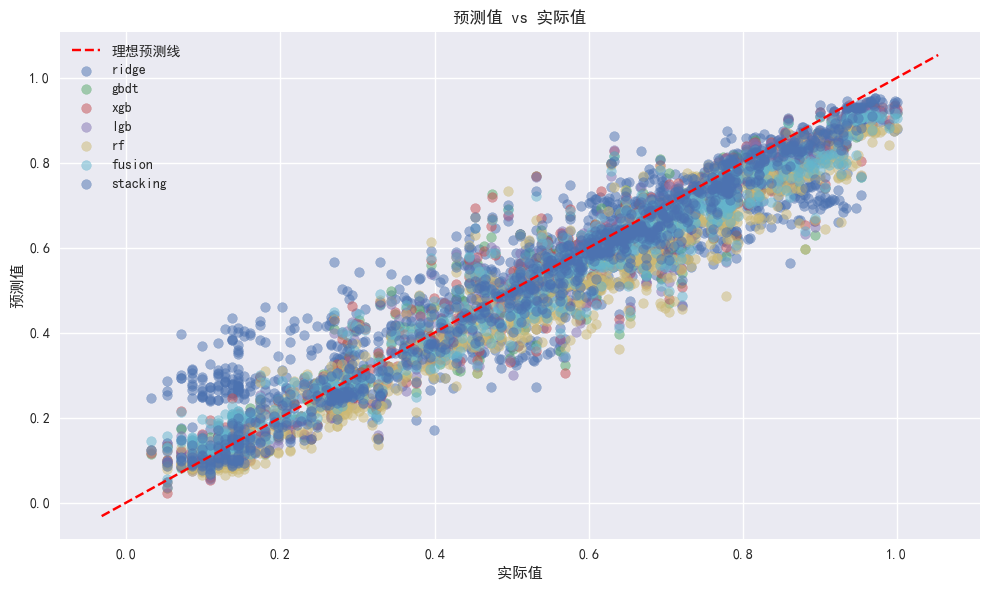

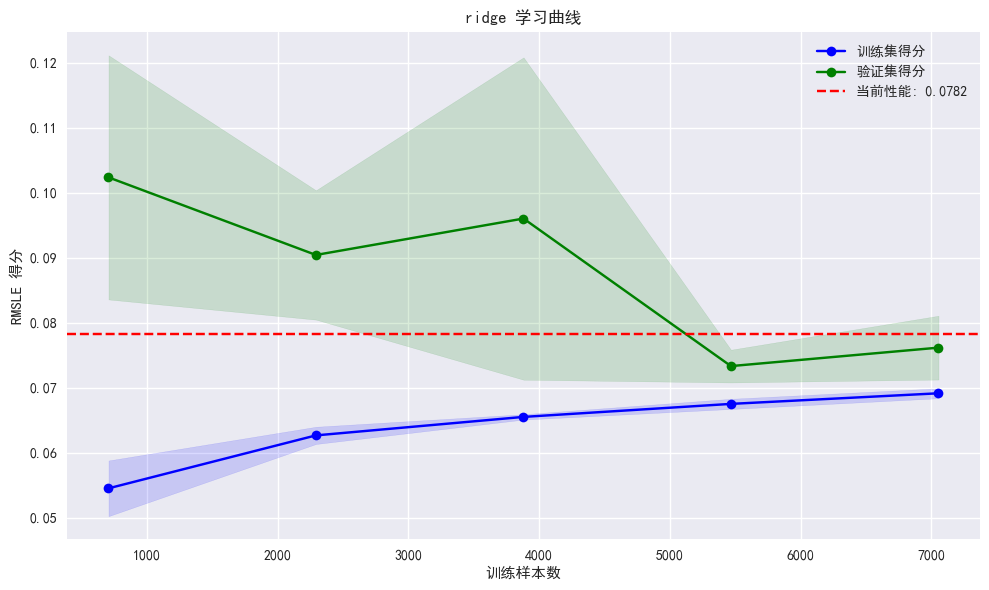

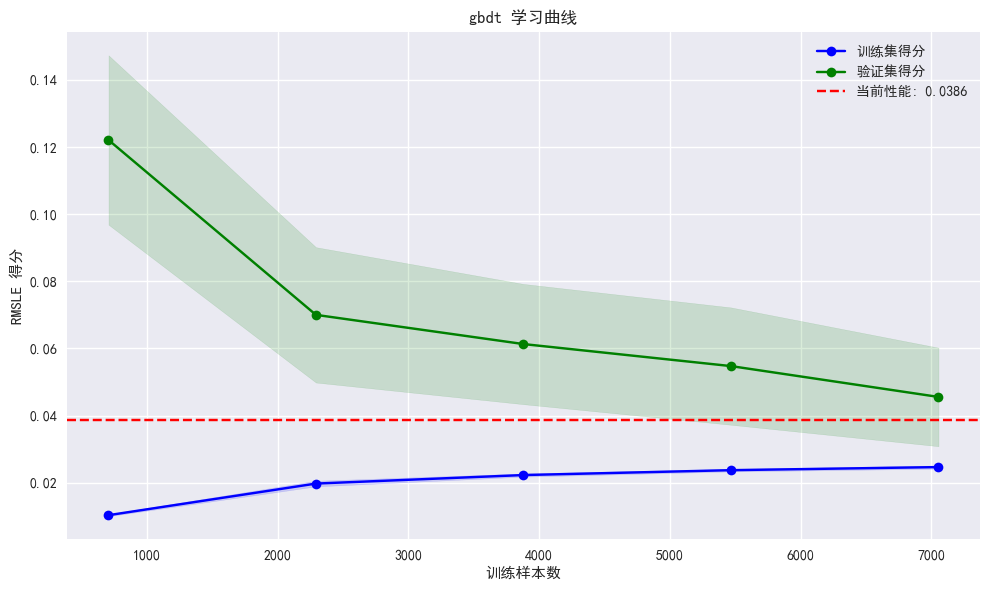

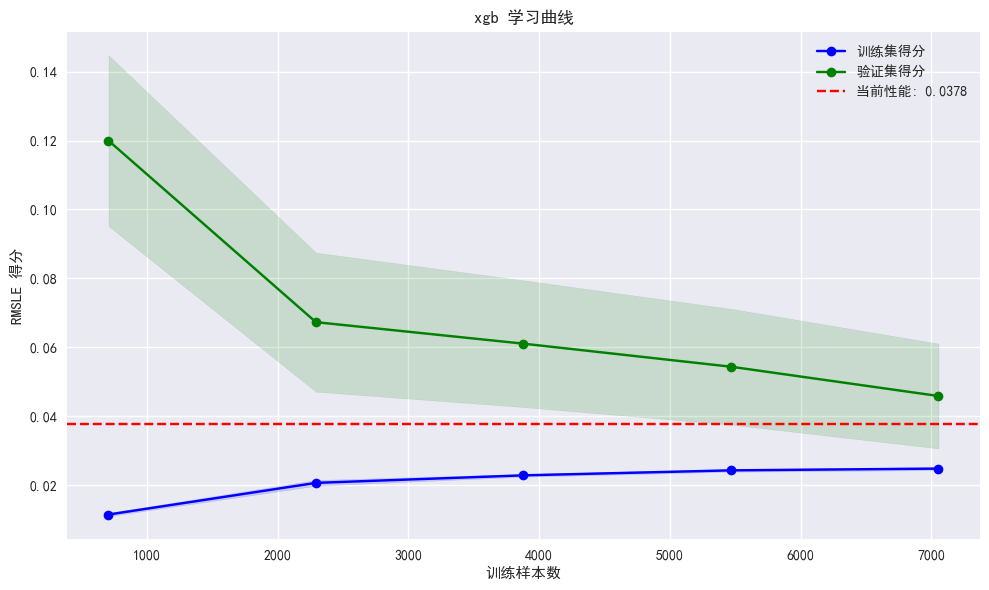

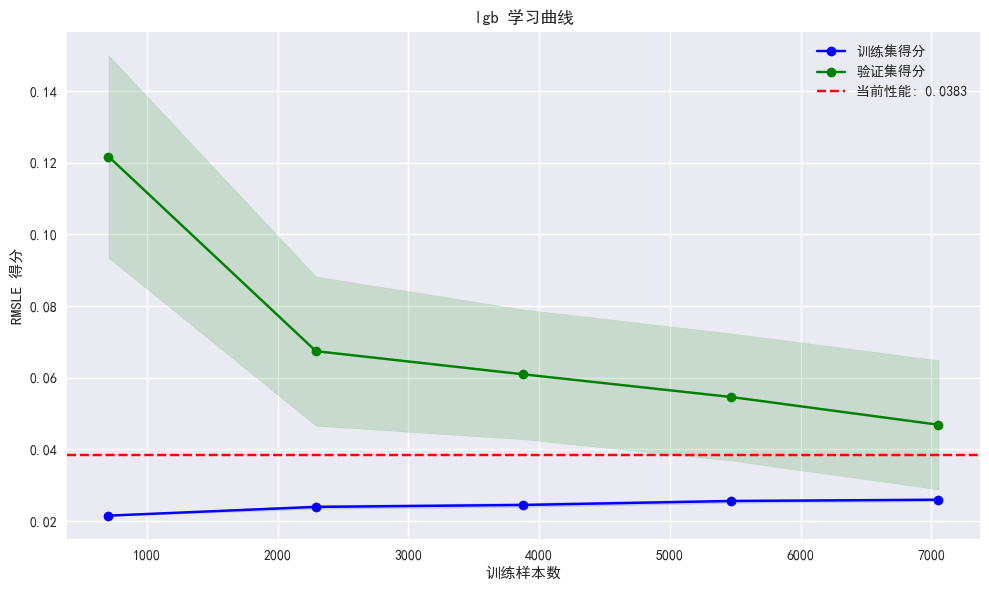

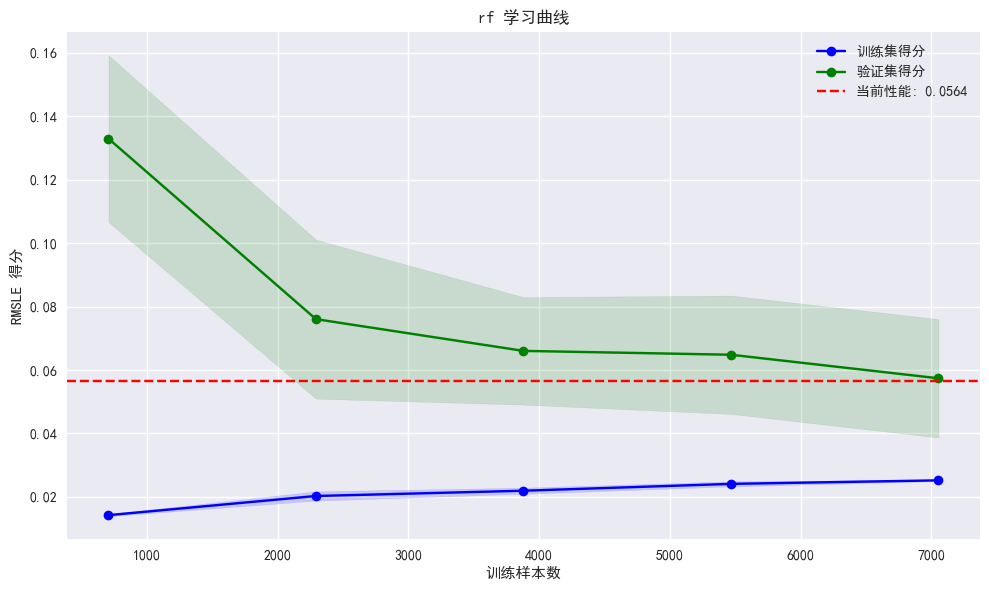

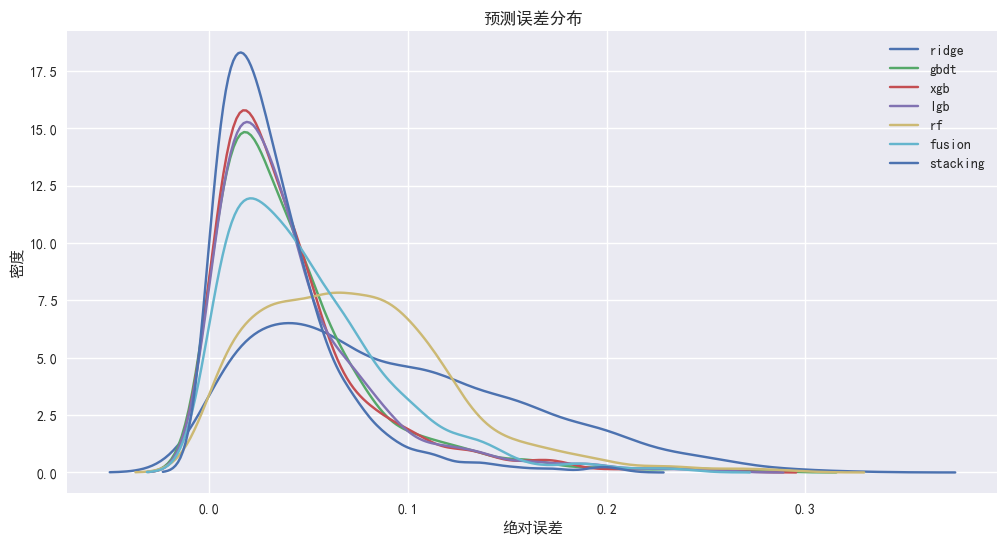

In [61]:
# 1. 初始化工厂类
model_factory = ModelFactory()

# 基础模型
model_factory.register_model('ridge', Ridge)  

# 树模型（主力）
model_factory.register_model('gbdt', GradientBoostingRegressor)  # 处理非线性关系
model_factory.register_model('xgb', xgb.XGBRegressor)  # 强大的非线性建模能力
model_factory.register_model('lgb', lgb.LGBMRegressor)  # 高效处理大规模数据
model_factory.register_model('rf', RandomForestRegressor)  # 良好的泛化能力


# 2. 创建数据分割器
splitter_factory = DataSplitterFactory()
splitter_factory.register_splitter('time_series', TimeSeriesSplitter)
splitter_factory.register_splitter('regression', RegressionSplitter)
splitter_factory.register_splitter('classification', ClassificationSplitter)

# 创建meta_model(可以使用任何回归模型)
meta_model = Ridge(alpha=1.0)
#推荐方案：LightGBM（平衡方案，在基础模型中表现最佳）
# meta_model = lgb.LGBMRegressor(
#     # 基础参数
#     n_estimators=1000,         # 增加树的数量以提高性能
#     max_depth=12,              # 较大的树深度，根据基础模型最佳参数
#     learning_rate=0.05,        # 中等学习率，平衡稳定性和性能
    
#     # 防止过拟合的参数
#     min_child_samples=20,      # 每个叶子节点最少样本数
#     min_split_gain=1e-3,       # 最小分裂增益
#     subsample=0.8,             # 样本采样比例
#     colsample_bytree=0.8,      # 特征采样比例
#     num_leaves=15,             # 叶子节点数量，根据基础模型最佳参数
    
#     # 其他优化参数
#     n_jobs=-1,                 # 使用所有CPU核心
#     verbosity=-1,              # 禁用警告输出
#     force_col_wise=True        # 避免自动选择线程方式的警告
# )

# 3. 初始化模型训练管道
pipeline = ModelTrainingPipeline(
    model_factory, 
    param_optimizer=grid_search_optimizer, 
    metrics=['rmse', 'rmsle', 'r2'],  # 使用这些评价指标
    primary_metric='rmsle',  # Kaggle比赛使用RMSLE
    meta_model=meta_model
)  

# 4. 注册模型（设置初始参数）
pipeline.register_model('ridge', 'ridge', alpha=1.0)
pipeline.register_model('gbdt', 'gbdt', 
                       n_estimators=100,            # 树的数量。
                       max_depth=5,
                       learning_rate=0.1,
                       verbose=0)
pipeline.register_model('xgb', 'xgb',
                       n_estimators=100,
                       max_depth=5,
                       learning_rate=0.1,
                       objective='reg:squarederror',
                       verbosity=0,                 # xgb使用verbosity替代verbose
                       n_jobs=-1)                   # 使用所有CPU核心)
pipeline.register_model('lgb', 'lgb',
                       n_estimators=100,
                       max_depth=5,
                       learning_rate=0.1,
                       # 其他优化参数
                       min_child_samples=20,     # 每个叶子节点最少样本数-控制过拟合
                       min_split_gain=1e-3,      # 最小分裂增益-控制过拟合
                       subsample=0.8,            # 样本采样比例-增加随机性
                       colsample_bytree=0.8,     # 特征采样比例-增加随机性
                       verbosity=-1,             # 禁用警告输出
                       force_col_wise=True,      # 避免自动选择线程方式的警告
                       n_jobs=-1)
pipeline.register_model('rf', 'rf',
                       n_estimators=100,
                       max_depth=10,
                       verbose=0,
                       n_jobs=-1,
                       warm_start=True
                       )    


# 5. 定义超参数网格
param_grids = {
    'ridge': {'alpha': np.logspace(-5, 1, 20)},  # 生成一个从 10^-5 到 10^1 的等比数列，包含 20 个元素
    'gbdt': {
        'n_estimators': [800, 1000],  # 增加树的数量
        'max_depth': [8,10],         # 增加树的深度
        'learning_rate': [0.03,0.05], 
        'min_samples_split': [5, 8],     # 降低分裂阈值
        'subsample': [0.8, 0.9]      # 增加采样比例
    },
    'xgb': {
        'n_estimators': [500, 800],
        'max_depth': [10,15,17],
        'learning_rate': [0.01,0.03, 0.1],
        'min_child_weight': [5, 8,10],
        'reg_alpha': [0.1, 0.3,0.5],        # 减小L1正则化
        'reg_lambda': [0.1, 0.3,0.5]       # 减小L2正则化
    },
    'lgb': {
        'n_estimators': [1000, 1500],
        'max_depth': [8, 10, 12],
        'learning_rate': [0.03, 0.05, 0.08],
        'num_leaves': [15, 20, 31] 
    },
    'rf': {
        'n_estimators': [800, 1000, 1200],
        'max_depth': [8, 10, 12],
        'min_samples_split': [5, 8, 10]
    }
}


# 6. 选择数据分割器和分割数据
data_splitter = splitter_factory.create_splitter('time_series', test_size=0.1)
# data_splitter = splitter_factory.create_splitter('regression', test_size=0.2, random_state = 42)

# 7. 进行交叉验证和训练
#fold_scores = train_and_evaluate_with_cv(pipeline, train_data, data_splitter, n_splits=3, target_col='count',param_grids=param_grids)
fold_scores = train_and_evaluate_with_cv(pipeline, train_data, data_splitter, n_splits=3, target_col='count')
#--------------------启动可视化-----------------------
# 1. 获取特征名称（需要在数据分割后执行）
try:
    X_train, X_val, y_train, y_val = data_splitter.split(train_data, target_col='count')
    pipeline.feature_names = X_train.columns.tolist()
except Exception as e:
    print(f"获取特征名称失败: {str(e)}")

# 2. 执行综合可视化（包含所有可视化内容）
#pipeline.visualize_training()

# 3. 或者单独使用某个可视化功能
# pipeline._plot_model_comparison()# 查看模型性能对比
# pipeline._plot_feature_importance()# 查看特征重要性
# pipeline._plot_optimization_history()# 查看参数优化过程
pipeline._plot_prediction_vs_actual()  # 预测值与实际值对比
# pipeline._plot_residual_analysis()     # 残差分析
pipeline._plot_learning_curves()       # 学习曲线
# pipeline._plot_cross_validation_scores()  # 交叉验证得分分布
# pipeline._plot_correlation_matrix()     # 特征相关性矩阵
pipeline._plot_error_distribution()     # 预测误差分布


**学习曲线解读：**


*   **三条线:**

    1.  **蓝色实线 (训练集得分):** 表示模型在不同数量的训练数据上的平均性能。每个蓝色的点代表使用特定数量的训练样本训练模型后，在*训练集本身*上的平均 RMSLE 得分。通常，训练集得分会随着训练样本数的增加而变得更好（或保持不变），因为模型在见过的训练数据上表现通常会更好。

    2.  **绿色实线 (验证集得分):** 表示模型在不同数量的训练数据上的交叉验证性能。每个绿色的点代表使用特定数量的训练样本训练模型后，在*验证集*（未用于训练的数据）上的平均 RMSLE 得分。这是对模型泛化能力（对未见数据的预测能力）的更可靠的估计。

    3.  **红色虚线 (当前性能):** 表示模型在整个数据集上评估得到的当前性能（RMSLE 得分）。这条线提供了一个参考，用于比较不同训练样本数量下的模型性能与当前模型性能。

*   **阴影区域:**

    *   蓝色阴影区域表示训练得分的标准差。
    *   绿色阴影区域表示验证得分的标准差。

    标准差反映了模型性能在不同交叉验证折叠（或不同随机种子）上的波动程度。阴影区域越大，表示模型性能的波动越大，可能存在不稳定性或过拟合。

**如何通过学习曲线诊断模型问题：**

1.  **高偏差 (欠拟合):**

    *   如果训练集得分和验证集得分都很差，并且两条曲线都收敛到一个较低的水平（即，得分都不理想，且随着训练样本数增加，得分不再显著提高），则模型可能存在高偏差（欠拟合）。
    *   这意味着模型过于简单，无法捕捉数据中的复杂模式。
    *   **解决办法:** 尝试更复杂的模型、增加特征、减少正则化等。

2.  **高方差 (过拟合):**

    *   如果训练集得分很好，但验证集得分较差，并且两条曲线之间存在较大差距，则模型可能存在高方差（过拟合）。
    *   这意味着模型过于复杂，过度拟合了训练数据中的噪声，导致泛化能力差。
    *   **解决办法:** 增加训练数据、使用更简单的模型、增加正则化、特征选择等。

3.  **理想情况:**

    *   训练集得分和验证集得分都很好，并且两条曲线都收敛到一个较高的水平，且差距较小。
    *   这意味着模型既能很好地拟合训练数据，又能很好地泛化到未见数据。


In [62]:
# 预测并保存结果
stacking_predictions = pipeline.predict(submit_data, method='stacking')
if stacking_predictions is not None:
    # 确保预测结果为一维数组
    if stacking_predictions.ndim > 1:
        stacking_predictions = stacking_predictions.ravel()
    
    # 还原预测结果
    restored_predictions = normalizer.restore_predictions(
        stacking_predictions, 
        source_column='count'
    )
    
    final_predictions = transformer.inverse_transform(restored_predictions)
    
    # 保存结果
    submission = pd.DataFrame({
        'datetime': pd.read_csv("./data/test.csv")['datetime'],
        'count': final_predictions
    })
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')  
    filename = f'./output/submission_{timestamp}.csv' 
    submission.to_csv(filename, index=False)
    print(f"预测结果已保存至 {filename}") 

else:
    print("预测失败，请检查错误信息")

预测结果已保存至 ./output/submission_20250225_1047.csv


In [46]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')        
# filename = f"{column_name}_outliers_samples_{timestamp}.csv"
# filepath = os.path.join(output_dir, filename)

# 使用方法

In [48]:
''' 
# 2. 初始化模型工厂和注册模型
model_factory = ModelFactory()

# 注册传统机器学习模型
model_factory.register_model('gbdt', GradientBoostingRegressor)  
model_factory.register_model('xgb', xgb.XGBRegressor)  
model_factory.register_model('lgb', lgb.LGBMRegressor)  

# 3. 创建pipeline
meta_model = Ridge(alpha=1.0)
pipeline = ModelTrainingPipeline(
    model_factory, 
    param_optimizer=grid_search_optimizer, 
    metrics=['rmse', 'rmsle', 'r2'],
    primary_metric='r2',
    meta_model=meta_model
)  

# 4. 注册模型参数
pipeline.register_model('gbdt', 'gbdt', 
                       n_estimators=100,
                       max_depth=5,
                       learning_rate=0.1)

pipeline.register_model('xgb', 'xgb',
                       n_estimators=100,
                       max_depth=5,
                       learning_rate=0.1,
                       objective='reg:squarederror')

pipeline.register_model('lgb', 'lgb',
                       n_estimators=100,
                       max_depth=5,
                       learning_rate=0.1)

# 5. 定义参数网格
param_grids = {
    'gbdt': {
        'n_estimators': [3,5,8],
        'max_depth': [3,5,7],
        'learning_rate': [0.01,0.03]
    },
    'xgb': {
        'n_estimators': [3,5,8],
        'max_depth': [3,5,7],
        'learning_rate': [0.01,0.03]
    },
    'lgb': {
        'n_estimators': [3,5,8],
        'max_depth': [3,5,7],
        'learning_rate': [0.01,0.03]
    },
}

# 6. 训练模型
data_splitter = splitter_factory.create_splitter('time_series', test_size=0.1)
fold_scores = train_and_evaluate_with_cv(
    pipeline, 
    train_data, 
    data_splitter, 
    n_splits=3, 
    target_col='count', 
    param_grids=param_grids
)

# 7. 预测
# 单模型预测
gbdt_pred = pipeline.predict(submit_data, method='gbdt')
xgb_pred = pipeline.predict(submit_data, method='xgb')
lgb_pred = pipeline.predict(submit_data, method='lgb')

# 融合预测
fusion_pred = pipeline.predict(submit_data, method='fusion')  # 简单平均融合
stacking_pred = pipeline.predict(submit_data, method='stacking')  # stacking融合

# 8. 保存预测结果
predictions = {
    'gbdt': gbdt_pred,
    'xgb': xgb_pred,
    'lgb': lgb_pred,
    'fusion': fusion_pred,
    'stacking': stacking_pred
}

for method, pred in predictions.items():
    submission = pd.DataFrame({
        'datetime': submit_data.index,
        'count': pred
    })
    submission.to_csv(f'submission_{method}.csv', index=False)

'''

" \n# 2. 初始化模型工厂和注册模型\nmodel_factory = ModelFactory()\n\n# 注册传统机器学习模型\nmodel_factory.register_model('gbdt', GradientBoostingRegressor)  \nmodel_factory.register_model('xgb', xgb.XGBRegressor)  \nmodel_factory.register_model('lgb', lgb.LGBMRegressor)  \n\n# 3. 创建pipeline\nmeta_model = Ridge(alpha=1.0)\npipeline = ModelTrainingPipeline(\n    model_factory, \n    param_optimizer=grid_search_optimizer, \n    metrics=['rmse', 'rmsle', 'r2'],\n    primary_metric='r2',\n    meta_model=meta_model\n)  \n\n# 4. 注册模型参数\npipeline.register_model('gbdt', 'gbdt', \n                       n_estimators=100,\n                       max_depth=5,\n                       learning_rate=0.1)\n\npipeline.register_model('xgb', 'xgb',\n                       n_estimators=100,\n                       max_depth=5,\n                       learning_rate=0.1,\n                       objective='reg:squarederror')\n\npipeline.register_model('lgb', 'lgb',\n                       n_estimators=100,\n                     